In [1]:
import sys
sys.path.append('..')

import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gaussian, threshold_otsu
from skimage.transform import resize
from skimage import io
import pickle
from skimage.measure import regionprops

import matplotlib.pyplot as plt
import torch
import time
import model.model_cnnvae_conditional
import model.optimizer as optimizer
from sklearn.decomposition import PCA
import pandas as pd
from model.model_cnnvae import FC_l2

In [2]:
prevSampled=0
nSamples=36
holdOutSamples_samples=[['HV1','P22','P14','P27','HV3','P46','P24','P37'],
                        ['HV5','P68','P44','P42','HV7','P15','P55','P59'],
                        ['HV8','P47','P63','P70','HV2','P57','P72','P83'],
                        ['HV4','P16','P18','P62','HV6','P52','P41','P38'],
                        ['HV1','P84','P50','P48','HV2','P22','P56','P27'],
                        ['HV3','P46','P14','P37','HV4','P68','P44','P42'],
                        ['HV5','P15','P24','P59','HV6','P47','P55','P70'],
                        ['HV7','P57','P63','P83','HV8','P16','P18','P62'],
                        ['HV1','P52','P72','P38','HV5','P84','P41','P48'],
                        ['HV2','P22','P50','P27','HV3','P68','P24','P59'],
                        ['HV4','P47','P56','P37','HV7','P16','P44','P70'],
                        ['HV6','P46','P14','P42','HV8','P15','P55','P83']]

In [3]:
sourceDir='/data/xinyi/c2p/data/chromark'
segDir=os.path.join(sourceDir,'nuclear_masks')
imgDir=os.path.join(sourceDir,'raw_data')
conditions=['controls','headneck','meningioma', 'glioma']

outSize=128
savename='pathCentered_'+str(outSize)


In [4]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [5]:
seed=3
epochs=2001
saveFreq=25
lr=0.0001
weight_decay=0 #Weight for L2 loss on embedding matrix.

batchsize=256
valRatio=0.2

In [6]:
def train(epoch,model_clf,optimizer_clf,inputImgs,inputImgs_val,labels_train,labels_val):
    np.random.seed(3)
    train_nodes_idx=np.arange(labels_train.size()[0])
    val_nodes_idx=np.arange(labels_val.size()[0])
    np.random.shuffle(train_nodes_idx)
    t = time.time()
    model_clf.train()
    loss_all=0
    
    ntrainBatches=int(np.ceil(train_nodes_idx.shape[0]/batchsize))
    for i in range(ntrainBatches):
#         if i%200==0:
#             print(i)
        trainIdx=train_nodes_idx[i*batchsize:min((i+1)*batchsize,train_nodes_idx.shape[0])]
        train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
        trainInput=torch.tensor(inputImgs[trainIdx]).cuda().float()

        optimizer_clf.zero_grad()

        pred = model_clf(trainInput)

        loss=loss_clf(pred, train_labels)
        loss_all+=loss.item()
            
        loss.backward()
        optimizer_clf.step()

    loss_all=loss_all/ntrainBatches
    
    with torch.no_grad():
        model_clf.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(val_nodes_idx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx=val_nodes_idx[i*batchsize:min((i+1)*batchsize,val_nodes_idx.shape[0])]
            val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
            valInput=torch.tensor(inputImgs_val[valIdx]).cuda().float()


            pred = model_clf(valInput)

            loss=loss_clf(pred, val_labels)
            loss_val_all+=loss.item()

        loss_val_all=loss_val_all/nvalBatches
    if epoch%10==0:
        print(' Epoch: {:04d}'.format(epoch),
              'loss_train: {:.4f}'.format(loss_all),
              'loss_val: {:.4f}'.format(loss_val_all),
              'time: {:.4f}s'.format(time.time() - t))
    return loss_all,loss_val_all







In [7]:
name_train='conditionClf_nmco_sampling'
modelname_train='nmco2cond_fc_l2'
logsavepath_train=os.path.join('/data/xinyi/c2p/log/',modelname_train,name_train)
modelsavepath_train=os.path.join('/data/xinyi/c2p/models/',modelname_train,name_train)
plotsavepath_train=os.path.join('/data/xinyi/c2p/plots/',modelname_train,name_train)

if not os.path.exists(os.path.join('/data/xinyi/c2p/log/',modelname_train)):
    os.mkdir(os.path.join('/data/xinyi/c2p/log/',modelname_train))
    os.mkdir(os.path.join('/data/xinyi/c2p/models/',modelname_train))
    os.mkdir(os.path.join('/data/xinyi/c2p/plots/',modelname_train))
if not os.path.exists(logsavepath_train):
    os.mkdir(logsavepath_train)
if not os.path.exists(modelsavepath_train):
    os.mkdir(modelsavepath_train)
if not os.path.exists(plotsavepath_train):
    os.mkdir(plotsavepath_train)

gh2ax
0
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
0


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1620.0193 loss_val: 1503.0215 time: 0.9862s
 Epoch: 0010 loss_train: 271.9247 loss_val: 203.2571 time: 0.0460s
 Epoch: 0020 loss_train: 29.5884 loss_val: 17.7346 time: 0.0469s
 Epoch: 0030 loss_train: 14.5069 loss_val: 6.9603 time: 0.0454s
 Epoch: 0040 loss_train: 11.1301 loss_val: 5.5602 time: 0.0698s
 Epoch: 0050 loss_train: 8.6623 loss_val: 4.9600 time: 0.0461s
 Epoch: 0060 loss_train: 9.1923 loss_val: 4.5547 time: 0.0475s
 Epoch: 0070 loss_train: 7.0658 loss_val: 4.2604 time: 0.1055s
 Epoch: 0080 loss_train: 7.2460 loss_val: 3.7222 time: 0.0527s
 Epoch: 0090 loss_train: 5.8675 loss_val: 3.0727 time: 0.0461s
 Epoch: 0100 loss_train: 5.7253 loss_val: 2.9445 time: 0.1387s
 Epoch: 0110 loss_train: 5.2198 loss_val: 2.9022 time: 0.0592s
 Epoch: 0120 loss_train: 5.9058 loss_val: 2.6727 time: 0.0910s
 Epoch: 0130 loss_train: 5.2511 loss_val: 2.6223 time: 0.0821s
 Epoch: 0140 loss_train: 5.0386 loss_val: 2.5544 time: 0.0989s
 Epoch: 0150 loss_train: 4.5775 loss_val:

 Epoch: 1300 loss_train: 0.6818 loss_val: 0.5103 time: 0.0467s
 total time: 101.4431s


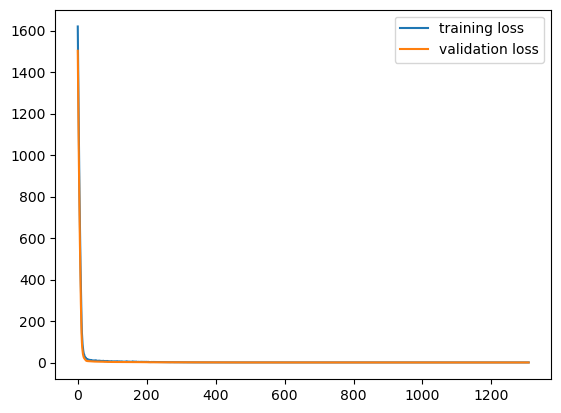

1
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
hold out: P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
hold out: P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
hold out: P68
1
 Epoch: 0000 loss_train: 1536.3238 loss_val: 1333.9012 time: 0.0466s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 264.1996 loss_val: 186.1303 time: 0.0441s
 Epoch: 0020 loss_train: 31.9434 loss_val: 17.1383 time: 0.0482s
 Epoch: 0030 loss_train: 14.8838 loss_val: 7.7238 time: 0.0480s
 Epoch: 0040 loss_train: 13.3091 loss_val: 6.8627 time: 0.1377s
 Epoch: 0050 loss_train: 12.0468 loss_val: 6.5067 time: 0.0863s
 Epoch: 0060 loss_train: 9.4650 loss_val: 6.2165 time: 0.0474s
 Epoch: 0070 loss_train: 9.1727 loss_val: 5.8316 time: 0.0587s
 Epoch: 0080 loss_train: 7.3582 loss_val: 5.4229 time: 0.0480s
 Epoch: 0090 loss_train: 7.8948 loss_val: 4.7046 time: 0.0593s
 Epoch: 0100 loss_train: 6.0599 loss_val: 3.7191 time: 0.0833s
 Epoch: 0110 loss_train: 6.4817 loss_val: 3.4966 time: 0.0472s
 Epoch: 0120 loss_train: 4.8367 loss_val: 3.4924 time: 0.0468s
 Epoch: 0130 loss_train: 5.2712 loss_val: 3.4425 time: 0.1822s
 Epoch: 0140 loss_train: 4.9605 loss_val: 3.3793 time: 0.0449s
 Epoch: 0150 loss_train: 5.1433 loss_val: 3.2964 time: 0.0611s
 Epoch: 0160 loss_train: 4.6571 loss_val: 3.25

 Epoch: 1310 loss_train: 0.7227 loss_val: 0.5491 time: 0.0618s
 Epoch: 1320 loss_train: 0.7077 loss_val: 0.5693 time: 0.0628s
 Epoch: 1330 loss_train: 0.7092 loss_val: 0.5483 time: 0.0663s
 total time: 87.4731s


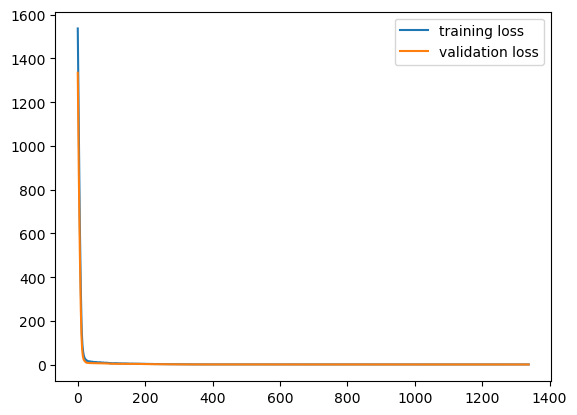

2
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
hold out: P83
P42
P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
hold out: P57
P15
P29
img not found P29
P68
2
 Epoch: 0000 loss_train: 1579.4408 loss_val: 1376.1349 time: 0.0565s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 247.4099 loss_val: 175.8012 time: 0.0603s
 Epoch: 0020 loss_train: 32.1712 loss_val: 15.6777 time: 0.0813s
 Epoch: 0030 loss_train: 15.3060 loss_val: 7.0066 time: 0.0528s
 Epoch: 0040 loss_train: 11.7301 loss_val: 5.9179 time: 0.0511s
 Epoch: 0050 loss_train: 10.7640 loss_val: 5.5434 time: 0.0496s
 Epoch: 0060 loss_train: 10.5050 loss_val: 5.0142 time: 0.0461s
 Epoch: 0070 loss_train: 7.8313 loss_val: 4.3903 time: 0.0474s
 Epoch: 0080 loss_train: 8.2601 loss_val: 3.3298 time: 0.0468s
 Epoch: 0090 loss_train: 7.1452 loss_val: 2.4454 time: 0.0464s
 Epoch: 0100 loss_train: 5.5829 loss_val: 2.3523 time: 0.0546s
 Epoch: 0110 loss_train: 5.9600 loss_val: 2.2753 time: 0.0572s
 Epoch: 0120 loss_train: 6.5267 loss_val: 2.1645 time: 0.0573s
 Epoch: 0130 loss_train: 5.2364 loss_val: 2.1428 time: 0.0587s
 Epoch: 0140 loss_train: 5.8805 loss_val: 2.0214 time: 0.0625s
 Epoch: 0150 loss_train: 5.3739 loss_val: 1.9268 time: 0.0563s
 Epoch: 0160 loss_train: 4.3945 loss_val: 1.8

 Epoch: 1310 loss_train: 0.6867 loss_val: 0.5319 time: 0.0828s
 Epoch: 1320 loss_train: 0.6788 loss_val: 0.5332 time: 0.0925s
 Epoch: 1330 loss_train: 0.6969 loss_val: 0.5349 time: 0.0498s
 Epoch: 1340 loss_train: 0.6823 loss_val: 0.5336 time: 0.0500s
 Epoch: 1350 loss_train: 0.6783 loss_val: 0.5327 time: 0.0530s
 Epoch: 1360 loss_train: 0.6705 loss_val: 0.5289 time: 0.0873s
 Epoch: 1370 loss_train: 0.6721 loss_val: 0.5325 time: 0.0526s
 Epoch: 1380 loss_train: 0.6760 loss_val: 0.5248 time: 0.0497s
 Epoch: 1390 loss_train: 0.6806 loss_val: 0.5330 time: 0.0475s
 Epoch: 1400 loss_train: 0.6606 loss_val: 0.5266 time: 0.0478s
 Epoch: 1410 loss_train: 0.6919 loss_val: 0.5305 time: 0.0851s
 Epoch: 1420 loss_train: 0.6853 loss_val: 0.5296 time: 0.0482s
 Epoch: 1430 loss_train: 0.6787 loss_val: 0.5287 time: 0.0554s
 Epoch: 1440 loss_train: 0.6777 loss_val: 0.5286 time: 0.1075s
 Epoch: 1450 loss_train: 0.6681 loss_val: 0.5266 time: 0.0472s
 Epoch: 1460 loss_train: 0.6723 loss_val: 0.5266 time: 

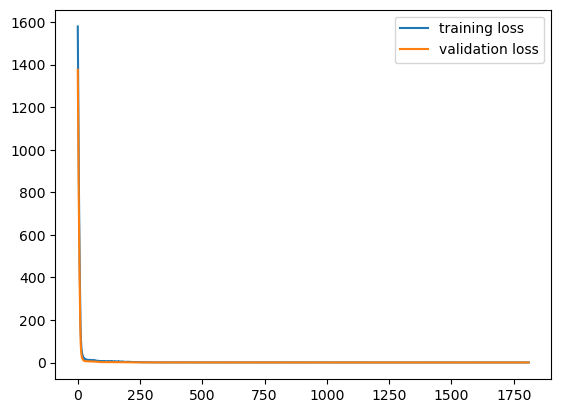

3
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
hold out: HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
hold out: P41
P56
hold out: P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
hold out: P38
P48
P37
hold out: P62
glioma
dapi_gh2ax_lamin_cd3
P46
hold out: P16
hold out: P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
3
 Epoch: 0000 loss_train: 1557.3000 loss_val: 1348.4282 time: 0.0549s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 291.3615 loss_val: 192.8905 time: 0.0538s
 Epoch: 0020 loss_train: 33.6405 loss_val: 15.4671 time: 0.0563s
 Epoch: 0030 loss_train: 15.5945 loss_val: 6.1762 time: 0.0579s
 Epoch: 0040 loss_train: 13.5523 loss_val: 5.2912 time: 0.0489s
 Epoch: 0050 loss_train: 9.8519 loss_val: 4.7131 time: 0.0824s
 Epoch: 0060 loss_train: 9.8673 loss_val: 4.3106 time: 0.0469s
 Epoch: 0070 loss_train: 8.6715 loss_val: 3.8108 time: 0.0718s
 Epoch: 0080 loss_train: 8.7251 loss_val: 3.5337 time: 0.0745s
 Epoch: 0090 loss_train: 7.6420 loss_val: 3.0740 time: 0.0458s
 Epoch: 0100 loss_train: 7.5235 loss_val: 2.7052 time: 0.1106s
 Epoch: 0110 loss_train: 6.0086 loss_val: 1.5620 time: 0.0458s
 Epoch: 0120 loss_train: 5.2939 loss_val: 1.5698 time: 0.0467s
 Epoch: 0130 loss_train: 4.5813 loss_val: 1.5035 time: 0.0835s
 Epoch: 0140 loss_train: 5.2018 loss_val: 1.4840 time: 0.0519s
 Epoch: 0150 loss_train: 5.1096 loss_val: 1.4859 time: 0.0589s
 Epoch: 0160 loss_train: 3.5108 loss_val: 1.369

 Epoch: 1310 loss_train: 0.6939 loss_val: 0.5444 time: 0.0883s
 Epoch: 1320 loss_train: 0.6905 loss_val: 0.5453 time: 0.0611s
 Epoch: 1330 loss_train: 0.6851 loss_val: 0.5424 time: 0.0601s
 Epoch: 1340 loss_train: 0.6792 loss_val: 0.5412 time: 0.0507s
 Epoch: 1350 loss_train: 0.6806 loss_val: 0.5384 time: 0.0541s
 Epoch: 1360 loss_train: 0.6988 loss_val: 0.5363 time: 0.0609s
 Epoch: 1370 loss_train: 0.6764 loss_val: 0.5420 time: 0.0625s
 Epoch: 1380 loss_train: 0.6849 loss_val: 0.5325 time: 0.0513s
 Epoch: 1390 loss_train: 0.6862 loss_val: 0.5358 time: 0.0578s
 Epoch: 1400 loss_train: 0.6934 loss_val: 0.5385 time: 0.0489s
 Epoch: 1410 loss_train: 0.6767 loss_val: 0.5317 time: 0.0493s
 Epoch: 1420 loss_train: 0.6899 loss_val: 0.5343 time: 0.0630s
 Epoch: 1430 loss_train: 0.6788 loss_val: 0.5322 time: 0.0549s
 Epoch: 1440 loss_train: 0.6868 loss_val: 0.5331 time: 0.0520s
 Epoch: 1450 loss_train: 0.6779 loss_val: 0.5362 time: 0.0532s
 Epoch: 1460 loss_train: 0.6827 loss_val: 0.5314 time: 

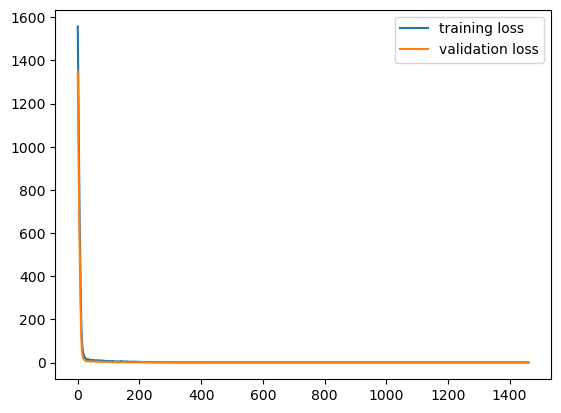

4
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
hold out: P56
P18
P55
hold out: P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
hold out: P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
hold out: P84
P47
P57
P15
P29
img not found P29
P68
4
 Epoch: 0000 loss_train: 1623.7465 loss_val: 1424.5844 time: 0.0773s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 278.5650 loss_val: 201.3933 time: 0.0489s
 Epoch: 0020 loss_train: 34.6691 loss_val: 17.4278 time: 0.0524s
 Epoch: 0030 loss_train: 17.4273 loss_val: 8.7182 time: 0.0570s
 Epoch: 0040 loss_train: 12.5242 loss_val: 8.0262 time: 0.0489s
 Epoch: 0050 loss_train: 13.9488 loss_val: 7.6535 time: 0.0536s
 Epoch: 0060 loss_train: 12.3682 loss_val: 6.3050 time: 0.0568s
 Epoch: 0070 loss_train: 11.1637 loss_val: 5.3959 time: 0.0953s
 Epoch: 0080 loss_train: 8.1344 loss_val: 4.3804 time: 0.0851s
 Epoch: 0090 loss_train: 6.9328 loss_val: 3.4039 time: 0.0499s
 Epoch: 0100 loss_train: 6.0275 loss_val: 3.4790 time: 0.0587s
 Epoch: 0110 loss_train: 7.3543 loss_val: 3.3335 time: 0.0490s
 Epoch: 0120 loss_train: 7.1101 loss_val: 3.3294 time: 0.0501s
 Epoch: 0130 loss_train: 7.0498 loss_val: 3.0444 time: 0.0499s
 Epoch: 0140 loss_train: 6.1542 loss_val: 2.9831 time: 0.1142s
 Epoch: 0150 loss_train: 4.4323 loss_val: 2.8865 time: 0.0499s
 Epoch: 0160 loss_train: 5.5918 loss_val: 2.

 Epoch: 1310 loss_train: 0.7527 loss_val: 0.5772 time: 0.0546s
 Epoch: 1320 loss_train: 0.7257 loss_val: 0.5801 time: 0.0786s
 Epoch: 1330 loss_train: 0.7318 loss_val: 0.5734 time: 0.0571s
 Epoch: 1340 loss_train: 0.7333 loss_val: 0.5764 time: 0.0498s
 Epoch: 1350 loss_train: 0.7411 loss_val: 0.5836 time: 0.0547s
 Epoch: 1360 loss_train: 0.7080 loss_val: 0.5726 time: 0.0637s
 Epoch: 1370 loss_train: 0.7127 loss_val: 0.5819 time: 0.0574s
 Epoch: 1380 loss_train: 0.7162 loss_val: 0.5692 time: 0.0931s
 Epoch: 1390 loss_train: 0.7161 loss_val: 0.5680 time: 0.0496s
 Epoch: 1400 loss_train: 0.7413 loss_val: 0.5711 time: 0.0484s
 Epoch: 1410 loss_train: 0.7081 loss_val: 0.5683 time: 0.0472s
 Epoch: 1420 loss_train: 0.6963 loss_val: 0.5656 time: 0.0857s
 Epoch: 1430 loss_train: 0.7458 loss_val: 0.5681 time: 0.0591s
 Epoch: 1440 loss_train: 0.7040 loss_val: 0.5664 time: 0.0559s
 Epoch: 1450 loss_train: 0.7280 loss_val: 0.5662 time: 0.1035s
 Epoch: 1460 loss_train: 0.7345 loss_val: 0.5722 time: 

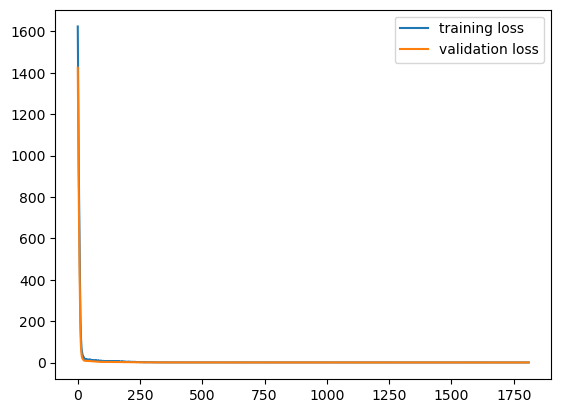

5
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
hold out: P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
5
 Epoch: 0000 loss_train: 1556.6524 loss_val: 1355.1375 time: 0.0590s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 258.8671 loss_val: 190.9490 time: 0.0492s
 Epoch: 0020 loss_train: 29.2780 loss_val: 23.3239 time: 0.0583s
 Epoch: 0030 loss_train: 13.8938 loss_val: 12.4247 time: 0.0508s
 Epoch: 0040 loss_train: 11.4808 loss_val: 10.6107 time: 0.0854s
 Epoch: 0050 loss_train: 10.7528 loss_val: 9.4428 time: 0.0480s
 Epoch: 0060 loss_train: 8.7696 loss_val: 8.3697 time: 0.0463s
 Epoch: 0070 loss_train: 7.8421 loss_val: 7.4927 time: 0.0457s
 Epoch: 0080 loss_train: 7.3376 loss_val: 6.7443 time: 0.0724s
 Epoch: 0090 loss_train: 7.3341 loss_val: 5.4644 time: 0.0457s
 Epoch: 0100 loss_train: 5.6474 loss_val: 3.9341 time: 0.0826s
 Epoch: 0110 loss_train: 5.7278 loss_val: 3.6503 time: 0.0452s
 Epoch: 0120 loss_train: 4.6148 loss_val: 3.3842 time: 0.0804s
 Epoch: 0130 loss_train: 5.1437 loss_val: 3.3257 time: 0.0531s
 Epoch: 0140 loss_train: 4.1111 loss_val: 3.1106 time: 0.0570s
 Epoch: 0150 loss_train: 3.7702 loss_val: 2.9538 time: 0.0666s
 Epoch: 0160 loss_train: 3.4213 loss_val: 2.

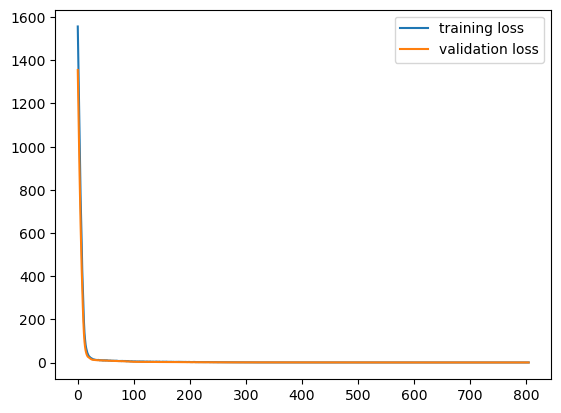

6
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
6
 Epoch: 0000 loss_train: 1651.9864 loss_val: 1389.9694 time: 0.0719s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 279.0976 loss_val: 183.9580 time: 0.1428s
 Epoch: 0020 loss_train: 30.6646 loss_val: 14.3320 time: 0.1228s
 Epoch: 0030 loss_train: 13.7993 loss_val: 5.5646 time: 0.0491s
 Epoch: 0040 loss_train: 12.3122 loss_val: 4.0852 time: 0.0668s
 Epoch: 0050 loss_train: 10.1271 loss_val: 3.6705 time: 0.0968s
 Epoch: 0060 loss_train: 8.9947 loss_val: 3.3322 time: 0.1572s
 Epoch: 0070 loss_train: 7.7315 loss_val: 3.0767 time: 0.0694s
 Epoch: 0080 loss_train: 6.3658 loss_val: 2.9411 time: 0.0857s
 Epoch: 0090 loss_train: 6.1462 loss_val: 2.4091 time: 0.0918s
 Epoch: 0100 loss_train: 5.5341 loss_val: 2.1884 time: 0.0776s
 Epoch: 0110 loss_train: 6.1568 loss_val: 2.0679 time: 0.1060s
 Epoch: 0120 loss_train: 4.6020 loss_val: 2.0461 time: 0.1258s
 Epoch: 0130 loss_train: 5.2634 loss_val: 1.8998 time: 0.0715s
 Epoch: 0140 loss_train: 5.2880 loss_val: 1.8484 time: 0.1153s
 Epoch: 0150 loss_train: 4.9226 loss_val: 1.7608 time: 0.1124s
 Epoch: 0160 loss_train: 3.7853 loss_val: 1.75

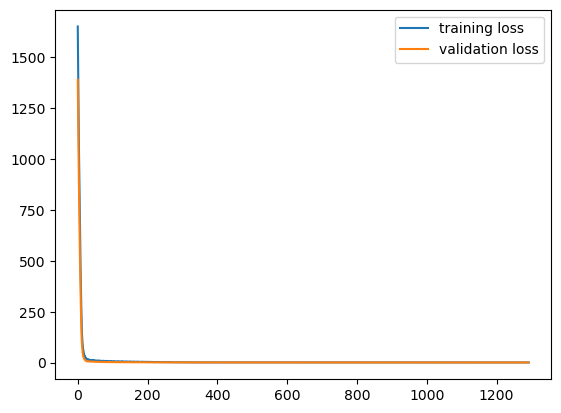

7
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
hold out: P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
hold out: P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
hold out: P68
7
 Epoch: 0000 loss_train: 1546.0065 loss_val: 1384.2549 time: 0.0525s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 269.5563 loss_val: 197.3355 time: 0.0631s
 Epoch: 0020 loss_train: 31.7520 loss_val: 18.8215 time: 0.0543s
 Epoch: 0030 loss_train: 16.2028 loss_val: 8.5733 time: 0.0498s
 Epoch: 0040 loss_train: 11.9302 loss_val: 7.6627 time: 0.0486s
 Epoch: 0050 loss_train: 11.0739 loss_val: 7.0709 time: 0.0495s
 Epoch: 0060 loss_train: 9.9959 loss_val: 6.7308 time: 0.0501s
 Epoch: 0070 loss_train: 9.1035 loss_val: 6.3145 time: 0.0529s
 Epoch: 0080 loss_train: 9.0740 loss_val: 5.8849 time: 0.0484s
 Epoch: 0090 loss_train: 8.7161 loss_val: 5.1528 time: 0.0492s
 Epoch: 0100 loss_train: 6.0911 loss_val: 3.7537 time: 0.0448s
 Epoch: 0110 loss_train: 5.1746 loss_val: 3.4818 time: 0.0539s
 Epoch: 0120 loss_train: 5.1728 loss_val: 3.4469 time: 0.1695s
 Epoch: 0130 loss_train: 4.7704 loss_val: 3.4278 time: 0.1099s
 Epoch: 0140 loss_train: 5.2776 loss_val: 3.1963 time: 0.1198s
 Epoch: 0150 loss_train: 4.7379 loss_val: 3.0907 time: 0.1080s
 Epoch: 0160 loss_train: 4.0468 loss_val: 3.06

 Epoch: 1310 loss_train: 0.7189 loss_val: 0.5809 time: 0.0992s
 total time: 96.7742s


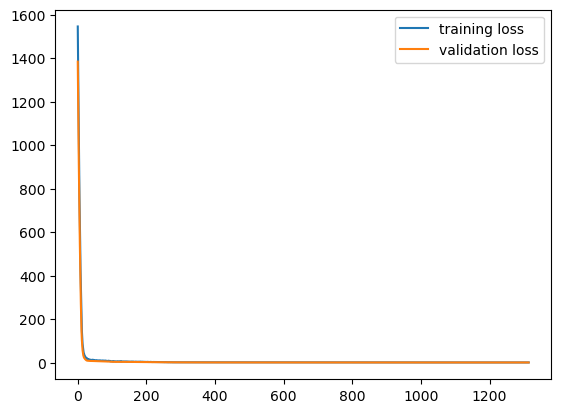

8
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
hold out: P83
P42
P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
hold out: P57
P15
P29
img not found P29
P68
8
 Epoch: 0000 loss_train: 1551.6057 loss_val: 1392.8600 time: 0.1154s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 244.3175 loss_val: 171.9436 time: 0.0907s
 Epoch: 0020 loss_train: 31.4067 loss_val: 17.0544 time: 0.0485s
 Epoch: 0030 loss_train: 13.4378 loss_val: 9.1769 time: 0.0629s
 Epoch: 0040 loss_train: 11.3886 loss_val: 8.2378 time: 0.0468s
 Epoch: 0050 loss_train: 9.8643 loss_val: 7.7547 time: 0.0755s
 Epoch: 0060 loss_train: 9.0185 loss_val: 7.3140 time: 0.1127s
 Epoch: 0070 loss_train: 7.5461 loss_val: 6.9528 time: 0.0561s
 Epoch: 0080 loss_train: 6.8920 loss_val: 6.0199 time: 0.1334s
 Epoch: 0090 loss_train: 6.2457 loss_val: 4.6100 time: 0.1314s
 Epoch: 0100 loss_train: 6.5841 loss_val: 4.4267 time: 0.0873s
 Epoch: 0110 loss_train: 4.9592 loss_val: 4.2133 time: 0.0863s
 Epoch: 0120 loss_train: 4.9076 loss_val: 4.1971 time: 0.0449s
 Epoch: 0130 loss_train: 5.1395 loss_val: 4.1345 time: 0.0452s
 Epoch: 0140 loss_train: 4.0690 loss_val: 4.0334 time: 0.1304s
 Epoch: 0150 loss_train: 4.1361 loss_val: 3.8035 time: 0.0953s
 Epoch: 0160 loss_train: 3.5965 loss_val: 3.740

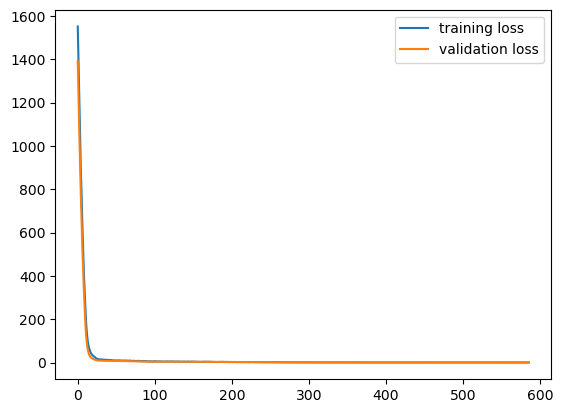

9
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
hold out: HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
hold out: P41
P56
hold out: P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
hold out: P38
P48
P37
hold out: P62
glioma
dapi_gh2ax_lamin_cd3
P46
hold out: P16
hold out: P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
9
 Epoch: 0000 loss_train: 1554.8515 loss_val: 1449.8805 time: 0.0590s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 286.9243 loss_val: 212.7662 time: 0.0462s
 Epoch: 0020 loss_train: 34.2289 loss_val: 20.4801 time: 0.0452s
 Epoch: 0030 loss_train: 14.7290 loss_val: 8.7744 time: 0.0491s
 Epoch: 0040 loss_train: 12.2281 loss_val: 7.6743 time: 0.0446s
 Epoch: 0050 loss_train: 10.2727 loss_val: 7.0355 time: 0.0450s
 Epoch: 0060 loss_train: 9.5408 loss_val: 6.3922 time: 0.0416s
 Epoch: 0070 loss_train: 9.0578 loss_val: 5.7485 time: 0.0750s
 Epoch: 0080 loss_train: 7.7147 loss_val: 5.2101 time: 0.0796s
 Epoch: 0090 loss_train: 6.9118 loss_val: 4.6270 time: 0.0917s
 Epoch: 0100 loss_train: 6.0998 loss_val: 3.9268 time: 0.0949s
 Epoch: 0110 loss_train: 5.8066 loss_val: 2.8765 time: 0.0423s
 Epoch: 0120 loss_train: 4.5606 loss_val: 2.8507 time: 0.0856s
 Epoch: 0130 loss_train: 4.2825 loss_val: 2.8266 time: 0.0775s
 Epoch: 0140 loss_train: 4.5475 loss_val: 2.7485 time: 0.0421s
 Epoch: 0150 loss_train: 4.1529 loss_val: 2.7679 time: 0.0426s
 Epoch: 0160 loss_train: 3.7473 loss_val: 2.76

 Epoch: 1310 loss_train: 0.6739 loss_val: 0.5912 time: 0.0461s
 Epoch: 1320 loss_train: 0.6736 loss_val: 0.5922 time: 0.0442s
 Epoch: 1330 loss_train: 0.6822 loss_val: 0.5939 time: 0.0472s
 Epoch: 1340 loss_train: 0.6812 loss_val: 0.5933 time: 0.0469s
 Epoch: 1350 loss_train: 0.6831 loss_val: 0.5912 time: 0.0455s
 Epoch: 1360 loss_train: 0.6796 loss_val: 0.5887 time: 0.0443s
 Epoch: 1370 loss_train: 0.6798 loss_val: 0.5883 time: 0.0461s
 Epoch: 1380 loss_train: 0.6722 loss_val: 0.5818 time: 0.0465s
 Epoch: 1390 loss_train: 0.6698 loss_val: 0.5847 time: 0.0448s
 Epoch: 1400 loss_train: 0.6809 loss_val: 0.5861 time: 0.0475s
 Epoch: 1410 loss_train: 0.6625 loss_val: 0.5831 time: 0.0464s
 Epoch: 1420 loss_train: 0.6615 loss_val: 0.5794 time: 0.0475s
 Epoch: 1430 loss_train: 0.6542 loss_val: 0.5844 time: 0.0491s
 Epoch: 1440 loss_train: 0.6690 loss_val: 0.5797 time: 0.0495s
 Epoch: 1450 loss_train: 0.6713 loss_val: 0.5771 time: 0.0467s
 Epoch: 1460 loss_train: 0.6636 loss_val: 0.5762 time: 

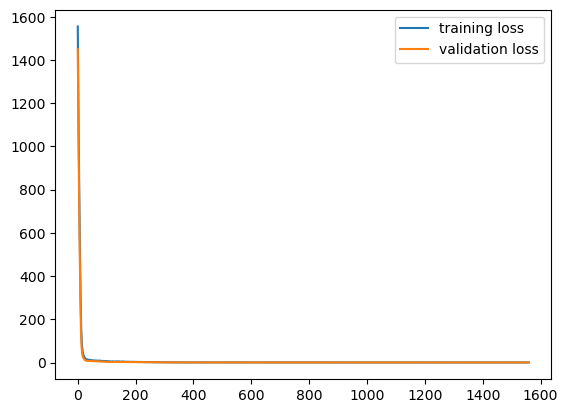

10
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
hold out: P56
P18
P55
hold out: P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
hold out: P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
hold out: P84
P47
P57
P15
P29
img not found P29
P68
10
 Epoch: 0000 loss_train: 1608.0785 loss_val: 1398.1724 time: 0.0597s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 276.3317 loss_val: 198.2557 time: 0.0664s
 Epoch: 0020 loss_train: 33.2804 loss_val: 17.1056 time: 0.0502s
 Epoch: 0030 loss_train: 15.7331 loss_val: 7.6948 time: 0.0482s
 Epoch: 0040 loss_train: 13.4187 loss_val: 6.8216 time: 0.0541s
 Epoch: 0050 loss_train: 11.1663 loss_val: 6.0956 time: 0.0480s
 Epoch: 0060 loss_train: 10.8102 loss_val: 5.0207 time: 0.0626s
 Epoch: 0070 loss_train: 8.4312 loss_val: 4.4144 time: 0.0639s
 Epoch: 0080 loss_train: 8.9303 loss_val: 3.1757 time: 0.0637s
 Epoch: 0090 loss_train: 8.0762 loss_val: 2.8041 time: 0.0517s
 Epoch: 0100 loss_train: 7.0878 loss_val: 2.6811 time: 0.0530s
 Epoch: 0110 loss_train: 7.1826 loss_val: 2.6176 time: 0.0659s
 Epoch: 0120 loss_train: 6.0463 loss_val: 2.5012 time: 0.0531s
 Epoch: 0130 loss_train: 5.5095 loss_val: 2.4899 time: 0.0635s
 Epoch: 0140 loss_train: 5.5920 loss_val: 2.3687 time: 0.0687s
 Epoch: 0150 loss_train: 4.6947 loss_val: 2.3372 time: 0.0525s
 Epoch: 0160 loss_train: 4.4295 loss_val: 2.1

 Epoch: 1310 loss_train: 0.7215 loss_val: 0.5576 time: 0.0744s
 Epoch: 1320 loss_train: 0.7109 loss_val: 0.5568 time: 0.0838s
 Epoch: 1330 loss_train: 0.7144 loss_val: 0.5602 time: 0.0503s
 Epoch: 1340 loss_train: 0.7222 loss_val: 0.5559 time: 0.1231s
 Epoch: 1350 loss_train: 0.7360 loss_val: 0.5638 time: 0.0578s
 Epoch: 1360 loss_train: 0.7256 loss_val: 0.5499 time: 0.0547s
 Epoch: 1370 loss_train: 0.7278 loss_val: 0.5442 time: 0.0479s
 Epoch: 1380 loss_train: 0.7201 loss_val: 0.5482 time: 0.0470s
 Epoch: 1390 loss_train: 0.7236 loss_val: 0.5508 time: 0.0541s
 Epoch: 1400 loss_train: 0.7136 loss_val: 0.5521 time: 0.1055s
 Epoch: 1410 loss_train: 0.7001 loss_val: 0.5503 time: 0.1179s
 Epoch: 1420 loss_train: 0.7043 loss_val: 0.5508 time: 0.1049s
 Epoch: 1430 loss_train: 0.7202 loss_val: 0.5494 time: 0.0858s
 Epoch: 1440 loss_train: 0.7382 loss_val: 0.5462 time: 0.0454s
 Epoch: 1450 loss_train: 0.7032 loss_val: 0.5517 time: 0.0602s
 Epoch: 1460 loss_train: 0.6937 loss_val: 0.5503 time: 

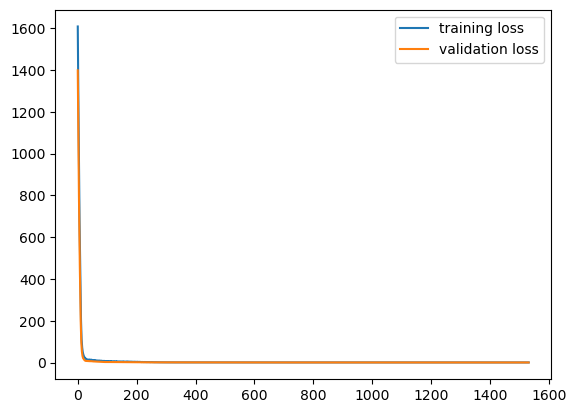

11
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
hold out: P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
11
 Epoch: 0000 loss_train: 1597.2816 loss_val: 1337.0512 time: 0.1089s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 268.6945 loss_val: 185.5590 time: 0.0808s
 Epoch: 0020 loss_train: 32.5601 loss_val: 18.1314 time: 0.0910s
 Epoch: 0030 loss_train: 15.0173 loss_val: 8.3935 time: 0.1213s
 Epoch: 0040 loss_train: 11.4373 loss_val: 7.5442 time: 0.0529s
 Epoch: 0050 loss_train: 10.4922 loss_val: 7.1224 time: 0.0492s
 Epoch: 0060 loss_train: 10.0816 loss_val: 6.5998 time: 0.2058s
 Epoch: 0070 loss_train: 8.1562 loss_val: 5.9469 time: 0.1203s
 Epoch: 0080 loss_train: 7.9244 loss_val: 4.9736 time: 0.0988s
 Epoch: 0090 loss_train: 6.6567 loss_val: 3.5591 time: 0.0520s
 Epoch: 0100 loss_train: 6.2303 loss_val: 3.2792 time: 0.0467s
 Epoch: 0110 loss_train: 4.8212 loss_val: 3.2855 time: 0.0771s
 Epoch: 0120 loss_train: 5.1020 loss_val: 3.1571 time: 0.1437s
 Epoch: 0130 loss_train: 4.9098 loss_val: 3.0771 time: 0.1248s
 Epoch: 0140 loss_train: 4.5571 loss_val: 2.9811 time: 0.1245s
 Epoch: 0150 loss_train: 4.4680 loss_val: 2.8858 time: 0.0680s
 Epoch: 0160 loss_train: 3.9081 loss_val: 2.8

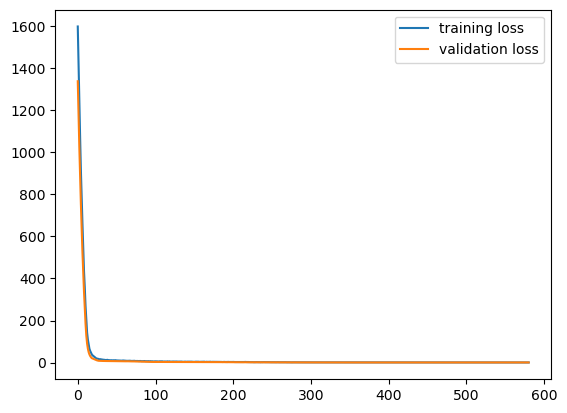

12
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
12
 Epoch: 0000 loss_train: 1611.3135 loss_val: 1485.2810 time: 0.1286s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 278.4754 loss_val: 206.2749 time: 0.1252s
 Epoch: 0020 loss_train: 29.4271 loss_val: 23.8032 time: 0.0709s
 Epoch: 0030 loss_train: 12.0956 loss_val: 12.2687 time: 0.0632s
 Epoch: 0040 loss_train: 9.5922 loss_val: 10.7478 time: 0.0468s
 Epoch: 0050 loss_train: 8.7862 loss_val: 9.7302 time: 0.1317s
 Epoch: 0060 loss_train: 8.0008 loss_val: 8.6523 time: 0.1182s
 Epoch: 0070 loss_train: 7.1662 loss_val: 8.1113 time: 0.0428s
 Epoch: 0080 loss_train: 5.4294 loss_val: 7.4131 time: 0.0488s
 Epoch: 0090 loss_train: 6.0701 loss_val: 6.8710 time: 0.0470s
 Epoch: 0100 loss_train: 5.0773 loss_val: 6.2669 time: 0.0854s
 Epoch: 0110 loss_train: 4.9948 loss_val: 5.8768 time: 0.0789s
 Epoch: 0120 loss_train: 5.1059 loss_val: 5.4411 time: 0.0594s
 Epoch: 0130 loss_train: 4.5285 loss_val: 5.0697 time: 0.0592s
 Epoch: 0140 loss_train: 4.4524 loss_val: 4.8228 time: 0.0483s
 Epoch: 0150 loss_train: 3.9144 loss_val: 4.6057 time: 0.0605s
 Epoch: 0160 loss_train: 3.4234 loss_val: 4.34

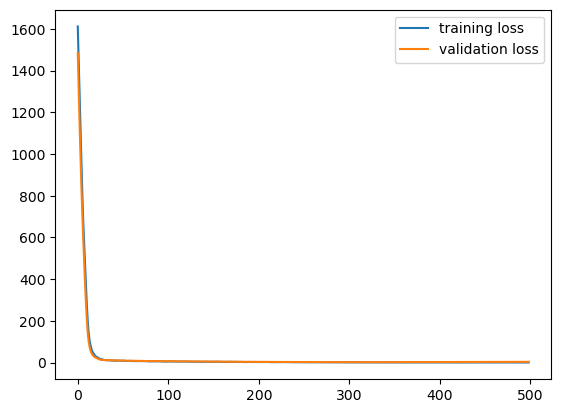

13
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
hold out: P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
hold out: P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
hold out: P68
13
 Epoch: 0000 loss_train: 1526.1940 loss_val: 1330.7698 time: 0.0499s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 264.6985 loss_val: 179.1513 time: 0.0842s
 Epoch: 0020 loss_train: 33.0864 loss_val: 15.7946 time: 0.0672s
 Epoch: 0030 loss_train: 16.9025 loss_val: 6.4937 time: 0.0763s
 Epoch: 0040 loss_train: 12.9578 loss_val: 5.8912 time: 0.0482s
 Epoch: 0050 loss_train: 11.0562 loss_val: 5.5669 time: 0.0673s
 Epoch: 0060 loss_train: 10.7276 loss_val: 5.1181 time: 0.0675s
 Epoch: 0070 loss_train: 9.9237 loss_val: 4.8699 time: 0.0484s
 Epoch: 0080 loss_train: 9.2173 loss_val: 4.3116 time: 0.0536s
 Epoch: 0090 loss_train: 7.6442 loss_val: 2.7199 time: 0.0474s
 Epoch: 0100 loss_train: 5.9527 loss_val: 2.2082 time: 0.0447s
 Epoch: 0110 loss_train: 5.8744 loss_val: 2.1338 time: 0.0523s
 Epoch: 0120 loss_train: 5.3097 loss_val: 2.0611 time: 0.0521s
 Epoch: 0130 loss_train: 5.4979 loss_val: 1.9833 time: 0.0662s
 Epoch: 0140 loss_train: 4.6905 loss_val: 1.9862 time: 0.0512s
 Epoch: 0150 loss_train: 4.8154 loss_val: 1.9159 time: 0.0483s
 Epoch: 0160 loss_train: 4.9826 loss_val: 1.8

 Epoch: 1310 loss_train: 0.7329 loss_val: 0.5307 time: 0.1133s
 Epoch: 1320 loss_train: 0.7335 loss_val: 0.5310 time: 0.1466s
 Epoch: 1330 loss_train: 0.7138 loss_val: 0.5306 time: 0.0521s
 Epoch: 1340 loss_train: 0.7184 loss_val: 0.5382 time: 0.1085s
 Epoch: 1350 loss_train: 0.7078 loss_val: 0.5294 time: 0.0567s
 Epoch: 1360 loss_train: 0.7208 loss_val: 0.5293 time: 0.0578s
 Epoch: 1370 loss_train: 0.7307 loss_val: 0.5284 time: 0.1385s
 Epoch: 1380 loss_train: 0.7201 loss_val: 0.5379 time: 0.0604s
 Epoch: 1390 loss_train: 0.7014 loss_val: 0.5267 time: 0.0475s
 Epoch: 1400 loss_train: 0.7224 loss_val: 0.5240 time: 0.1615s
 Epoch: 1410 loss_train: 0.7035 loss_val: 0.5298 time: 0.1383s
 Epoch: 1420 loss_train: 0.7252 loss_val: 0.5230 time: 0.0562s
 Epoch: 1430 loss_train: 0.7208 loss_val: 0.5184 time: 0.0592s
 total time: 86.1835s


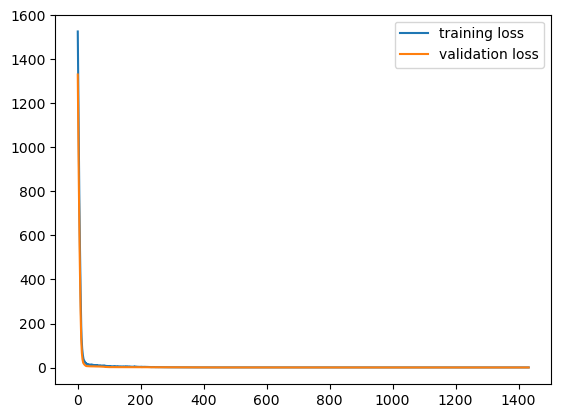

14
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
hold out: P83
P42
P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
hold out: P57
P15
P29
img not found P29
P68
14
 Epoch: 0000 loss_train: 1565.2566 loss_val: 1314.6617 time: 0.0513s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 255.4593 loss_val: 157.9359 time: 0.0613s
 Epoch: 0020 loss_train: 30.9288 loss_val: 13.8385 time: 0.0550s
 Epoch: 0030 loss_train: 14.6311 loss_val: 6.4682 time: 0.1092s
 Epoch: 0040 loss_train: 11.5018 loss_val: 5.5659 time: 0.0451s
 Epoch: 0050 loss_train: 12.1794 loss_val: 5.0714 time: 0.0662s
 Epoch: 0060 loss_train: 10.7487 loss_val: 4.7750 time: 0.0610s
 Epoch: 0070 loss_train: 7.9735 loss_val: 4.1118 time: 0.1327s
 Epoch: 0080 loss_train: 8.4940 loss_val: 3.0805 time: 0.0499s
 Epoch: 0090 loss_train: 5.6586 loss_val: 2.1760 time: 0.0561s
 Epoch: 0100 loss_train: 6.9192 loss_val: 2.1323 time: 0.0800s
 Epoch: 0110 loss_train: 5.7883 loss_val: 2.0717 time: 0.0499s
 Epoch: 0120 loss_train: 5.8562 loss_val: 2.0005 time: 0.1117s
 Epoch: 0130 loss_train: 5.5045 loss_val: 1.9626 time: 0.0455s
 Epoch: 0140 loss_train: 4.7507 loss_val: 1.9101 time: 0.1300s
 Epoch: 0150 loss_train: 4.5701 loss_val: 1.9315 time: 0.1038s
 Epoch: 0160 loss_train: 3.9989 loss_val: 1.7

 Epoch: 1310 loss_train: 0.6827 loss_val: 0.5230 time: 0.0940s
 Epoch: 1320 loss_train: 0.6941 loss_val: 0.5203 time: 0.1212s
 Epoch: 1330 loss_train: 0.6686 loss_val: 0.5174 time: 0.0490s
 Epoch: 1340 loss_train: 0.6802 loss_val: 0.5199 time: 0.0550s
 Epoch: 1350 loss_train: 0.6909 loss_val: 0.5173 time: 0.0563s
 Epoch: 1360 loss_train: 0.6627 loss_val: 0.5138 time: 0.1009s
 Epoch: 1370 loss_train: 0.6682 loss_val: 0.5118 time: 0.0575s
 Epoch: 1380 loss_train: 0.6875 loss_val: 0.5136 time: 0.0614s
 Epoch: 1390 loss_train: 0.6997 loss_val: 0.5107 time: 0.0559s
 Epoch: 1400 loss_train: 0.6897 loss_val: 0.5146 time: 0.1081s
 Epoch: 1410 loss_train: 0.6685 loss_val: 0.5117 time: 0.0473s
 Epoch: 1420 loss_train: 0.6648 loss_val: 0.5107 time: 0.0469s
 Epoch: 1430 loss_train: 0.6882 loss_val: 0.5125 time: 0.0527s
 Epoch: 1440 loss_train: 0.6719 loss_val: 0.5075 time: 0.0733s
 Epoch: 1450 loss_train: 0.6938 loss_val: 0.5135 time: 0.0571s
 Epoch: 1460 loss_train: 0.6863 loss_val: 0.5116 time: 

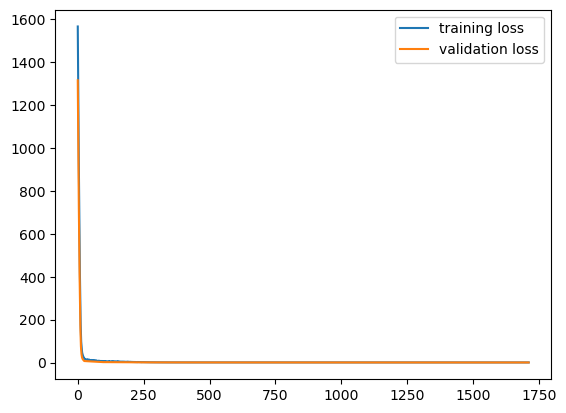

15
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
hold out: HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
hold out: P41
P56
hold out: P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
hold out: P38
P48
P37
hold out: P62
glioma
dapi_gh2ax_lamin_cd3
P46
hold out: P16
hold out: P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
15
 Epoch: 0000 loss_train: 1573.4055 loss_val: 1351.2765 time: 0.0603s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 290.6131 loss_val: 203.5663 time: 0.0540s
 Epoch: 0020 loss_train: 33.1352 loss_val: 19.7618 time: 0.0624s
 Epoch: 0030 loss_train: 14.8072 loss_val: 8.7514 time: 0.0470s
 Epoch: 0040 loss_train: 12.0912 loss_val: 7.3803 time: 0.0427s
 Epoch: 0050 loss_train: 9.6770 loss_val: 6.7281 time: 0.0645s
 Epoch: 0060 loss_train: 8.6334 loss_val: 6.0843 time: 0.0434s
 Epoch: 0070 loss_train: 8.2868 loss_val: 5.5015 time: 0.0478s
 Epoch: 0080 loss_train: 7.4767 loss_val: 4.7293 time: 0.0530s
 Epoch: 0090 loss_train: 8.1044 loss_val: 4.0360 time: 0.0447s
 Epoch: 0100 loss_train: 5.8226 loss_val: 3.6053 time: 0.1308s
 Epoch: 0110 loss_train: 6.3212 loss_val: 3.3664 time: 0.1210s
 Epoch: 0120 loss_train: 5.7728 loss_val: 3.2124 time: 0.0489s
 Epoch: 0130 loss_train: 4.8591 loss_val: 2.9199 time: 0.0956s
 Epoch: 0140 loss_train: 4.8298 loss_val: 2.7448 time: 0.0699s
 Epoch: 0150 loss_train: 3.9099 loss_val: 2.7674 time: 0.0493s
 Epoch: 0160 loss_train: 3.5565 loss_val: 2.635

 Epoch: 1310 loss_train: 0.6622 loss_val: 0.5793 time: 0.0483s
 Epoch: 1320 loss_train: 0.6624 loss_val: 0.5794 time: 0.0513s
 Epoch: 1330 loss_train: 0.6871 loss_val: 0.5731 time: 0.0472s
 Epoch: 1340 loss_train: 0.6756 loss_val: 0.5750 time: 0.0489s
 Epoch: 1350 loss_train: 0.6805 loss_val: 0.5721 time: 0.0478s
 Epoch: 1360 loss_train: 0.6572 loss_val: 0.5809 time: 0.0627s
 Epoch: 1370 loss_train: 0.6735 loss_val: 0.5744 time: 0.0485s
 Epoch: 1380 loss_train: 0.6737 loss_val: 0.5706 time: 0.0513s
 Epoch: 1390 loss_train: 0.6612 loss_val: 0.5746 time: 0.0543s
 Epoch: 1400 loss_train: 0.6485 loss_val: 0.5758 time: 0.0584s
 Epoch: 1410 loss_train: 0.6554 loss_val: 0.5760 time: 0.0471s
 Epoch: 1420 loss_train: 0.6699 loss_val: 0.5734 time: 0.0472s
 Epoch: 1430 loss_train: 0.6500 loss_val: 0.5779 time: 0.0475s
 total time: 84.5714s


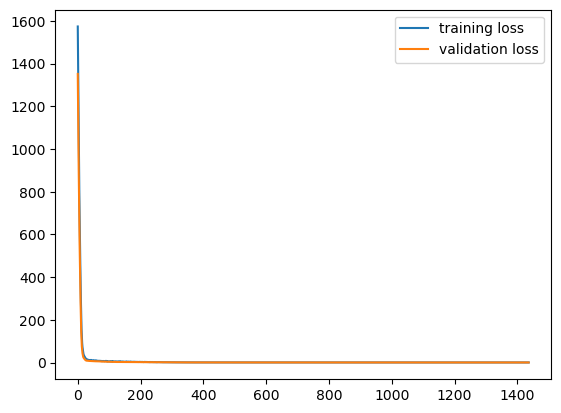

16
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
hold out: P56
P18
P55
hold out: P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
hold out: P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
hold out: P84
P47
P57
P15
P29
img not found P29
P68
16
 Epoch: 0000 loss_train: 1593.7370 loss_val: 1409.0766 time: 0.0487s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 280.0777 loss_val: 200.0347 time: 0.0647s
 Epoch: 0020 loss_train: 32.3595 loss_val: 19.4568 time: 0.0502s
 Epoch: 0030 loss_train: 14.9080 loss_val: 9.2712 time: 0.0515s
 Epoch: 0040 loss_train: 12.2358 loss_val: 8.0408 time: 0.0489s
 Epoch: 0050 loss_train: 12.4521 loss_val: 7.4710 time: 0.0596s
 Epoch: 0060 loss_train: 10.7827 loss_val: 6.2961 time: 0.0495s
 Epoch: 0070 loss_train: 8.8333 loss_val: 5.6200 time: 0.0550s
 Epoch: 0080 loss_train: 7.1176 loss_val: 4.4526 time: 0.0997s
 Epoch: 0090 loss_train: 7.2231 loss_val: 4.3068 time: 0.0459s
 Epoch: 0100 loss_train: 6.3540 loss_val: 4.2130 time: 0.1193s
 Epoch: 0110 loss_train: 6.4397 loss_val: 4.2595 time: 0.0481s
 Epoch: 0120 loss_train: 5.6104 loss_val: 4.1735 time: 0.0473s
 Epoch: 0130 loss_train: 4.9308 loss_val: 3.9762 time: 0.1756s
 Epoch: 0140 loss_train: 5.3907 loss_val: 3.9870 time: 0.0461s
 Epoch: 0150 loss_train: 4.8311 loss_val: 3.8721 time: 0.0475s
 Epoch: 0160 loss_train: 4.2935 loss_val: 3.6

 Epoch: 1310 loss_train: 0.7103 loss_val: 0.5500 time: 0.0963s
 Epoch: 1320 loss_train: 0.7050 loss_val: 0.5545 time: 0.0447s
 Epoch: 1330 loss_train: 0.6988 loss_val: 0.5527 time: 0.0509s
 Epoch: 1340 loss_train: 0.6962 loss_val: 0.5525 time: 0.0451s
 Epoch: 1350 loss_train: 0.7008 loss_val: 0.5499 time: 0.0937s
 Epoch: 1360 loss_train: 0.7171 loss_val: 0.5516 time: 0.0476s
 Epoch: 1370 loss_train: 0.7059 loss_val: 0.5474 time: 0.0499s
 Epoch: 1380 loss_train: 0.6977 loss_val: 0.5424 time: 0.0451s
 Epoch: 1390 loss_train: 0.7092 loss_val: 0.5483 time: 0.0487s
 Epoch: 1400 loss_train: 0.7107 loss_val: 0.5470 time: 0.0595s
 Epoch: 1410 loss_train: 0.6965 loss_val: 0.5393 time: 0.0617s
 Epoch: 1420 loss_train: 0.6891 loss_val: 0.5369 time: 0.0539s
 Epoch: 1430 loss_train: 0.6855 loss_val: 0.5469 time: 0.0641s
 Epoch: 1440 loss_train: 0.6962 loss_val: 0.5373 time: 0.0610s
 Epoch: 1450 loss_train: 0.6859 loss_val: 0.5401 time: 0.1794s
 Epoch: 1460 loss_train: 0.6959 loss_val: 0.5351 time: 

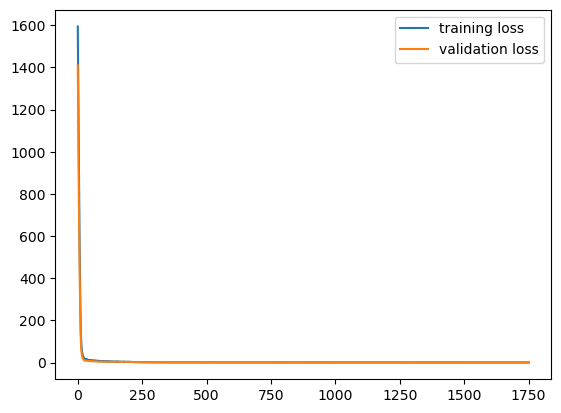

17
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
hold out: P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
17
 Epoch: 0000 loss_train: 1548.9970 loss_val: 1342.8296 time: 0.0452s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 263.8648 loss_val: 184.4020 time: 0.0445s
 Epoch: 0020 loss_train: 30.1001 loss_val: 16.3848 time: 0.1251s
 Epoch: 0030 loss_train: 16.0847 loss_val: 7.1717 time: 0.0973s
 Epoch: 0040 loss_train: 12.0762 loss_val: 6.2014 time: 0.1231s
 Epoch: 0050 loss_train: 11.3977 loss_val: 5.8675 time: 0.0448s
 Epoch: 0060 loss_train: 9.2996 loss_val: 5.5626 time: 0.0446s
 Epoch: 0070 loss_train: 9.5468 loss_val: 4.7828 time: 0.1168s
 Epoch: 0080 loss_train: 7.5369 loss_val: 4.1153 time: 0.1075s
 Epoch: 0090 loss_train: 7.3979 loss_val: 3.1703 time: 0.0450s
 Epoch: 0100 loss_train: 5.7874 loss_val: 2.9200 time: 0.0814s
 Epoch: 0110 loss_train: 6.2494 loss_val: 2.7753 time: 0.0443s
 Epoch: 0120 loss_train: 5.7300 loss_val: 2.7026 time: 0.0473s
 Epoch: 0130 loss_train: 4.8634 loss_val: 2.6249 time: 0.0775s
 Epoch: 0140 loss_train: 4.2728 loss_val: 2.4935 time: 0.1058s
 Epoch: 0150 loss_train: 4.0501 loss_val: 2.4504 time: 0.1313s
 Epoch: 0160 loss_train: 4.0878 loss_val: 2.43

 Epoch: 1310 loss_train: 0.7014 loss_val: 0.5621 time: 0.0508s
 Epoch: 1320 loss_train: 0.6973 loss_val: 0.5550 time: 0.0578s
 Epoch: 1330 loss_train: 0.7133 loss_val: 0.5598 time: 0.0517s
 Epoch: 1340 loss_train: 0.6942 loss_val: 0.5579 time: 0.0543s
 Epoch: 1350 loss_train: 0.6998 loss_val: 0.5622 time: 0.0643s
 Epoch: 1360 loss_train: 0.7055 loss_val: 0.5531 time: 0.0674s
 Epoch: 1370 loss_train: 0.7016 loss_val: 0.5561 time: 0.0612s
 Epoch: 1380 loss_train: 0.6840 loss_val: 0.5529 time: 0.0503s
 Epoch: 1390 loss_train: 0.7084 loss_val: 0.5461 time: 0.0623s
 Epoch: 1400 loss_train: 0.7127 loss_val: 0.5517 time: 0.0520s
 Epoch: 1410 loss_train: 0.6749 loss_val: 0.5520 time: 0.0581s
 Epoch: 1420 loss_train: 0.7012 loss_val: 0.5584 time: 0.0559s
 Epoch: 1430 loss_train: 0.6816 loss_val: 0.5451 time: 0.0597s
 Epoch: 1440 loss_train: 0.6887 loss_val: 0.5568 time: 0.0580s
 Epoch: 1450 loss_train: 0.6815 loss_val: 0.5529 time: 0.0669s
 Epoch: 1460 loss_train: 0.6984 loss_val: 0.5486 time: 

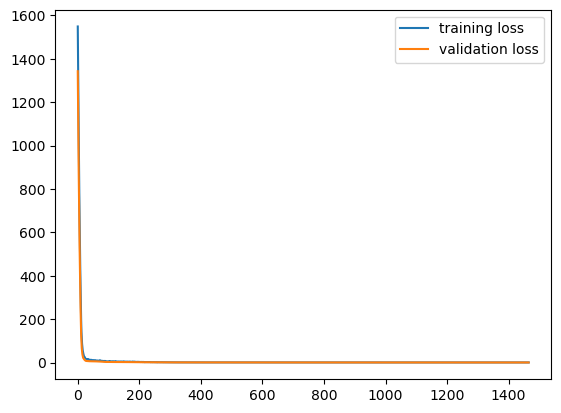

18
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
18
 Epoch: 0000 loss_train: 1650.5942 loss_val: 1380.7577 time: 0.0583s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 279.0865 loss_val: 197.4952 time: 0.0577s
 Epoch: 0020 loss_train: 31.9653 loss_val: 16.0789 time: 0.0596s
 Epoch: 0030 loss_train: 14.2572 loss_val: 5.2591 time: 0.0557s
 Epoch: 0040 loss_train: 10.7245 loss_val: 4.1063 time: 0.0593s
 Epoch: 0050 loss_train: 10.1028 loss_val: 3.7220 time: 0.0526s
 Epoch: 0060 loss_train: 9.9556 loss_val: 3.5015 time: 0.0507s
 Epoch: 0070 loss_train: 8.7746 loss_val: 3.2914 time: 0.0519s
 Epoch: 0080 loss_train: 7.4523 loss_val: 3.0453 time: 0.0537s
 Epoch: 0090 loss_train: 6.7994 loss_val: 2.5376 time: 0.0496s
 Epoch: 0100 loss_train: 7.4002 loss_val: 2.3292 time: 0.0517s
 Epoch: 0110 loss_train: 5.6727 loss_val: 2.2258 time: 0.0485s
 Epoch: 0120 loss_train: 5.2947 loss_val: 2.0889 time: 0.0535s
 Epoch: 0130 loss_train: 4.9936 loss_val: 2.1089 time: 0.0507s
 Epoch: 0140 loss_train: 4.7120 loss_val: 2.0404 time: 0.0502s
 Epoch: 0150 loss_train: 4.4000 loss_val: 1.8814 time: 0.0503s
 Epoch: 0160 loss_train: 4.1967 loss_val: 1.72

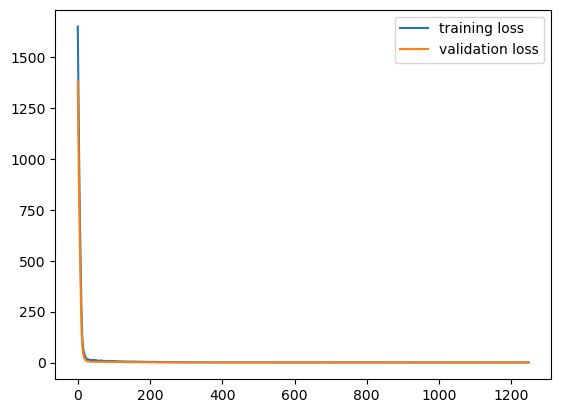

19
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
hold out: P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
hold out: P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
hold out: P68
19
 Epoch: 0000 loss_train: 1561.2898 loss_val: 1299.2654 time: 0.0727s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 256.1519 loss_val: 183.4384 time: 0.0440s
 Epoch: 0020 loss_train: 30.2797 loss_val: 19.4600 time: 0.0503s
 Epoch: 0030 loss_train: 15.0499 loss_val: 9.1329 time: 0.0795s
 Epoch: 0040 loss_train: 13.5993 loss_val: 7.8232 time: 0.0444s
 Epoch: 0050 loss_train: 11.5596 loss_val: 7.6256 time: 0.1673s
 Epoch: 0060 loss_train: 10.3747 loss_val: 7.2402 time: 0.1009s
 Epoch: 0070 loss_train: 9.4865 loss_val: 6.8534 time: 0.1377s
 Epoch: 0080 loss_train: 7.7413 loss_val: 6.4431 time: 0.0435s
 Epoch: 0090 loss_train: 8.0414 loss_val: 5.2411 time: 0.0440s
 Epoch: 0100 loss_train: 7.4995 loss_val: 4.2407 time: 0.0460s
 Epoch: 0110 loss_train: 6.1470 loss_val: 4.1470 time: 0.0847s
 Epoch: 0120 loss_train: 5.1920 loss_val: 4.0512 time: 0.0453s
 Epoch: 0130 loss_train: 5.6133 loss_val: 4.0313 time: 0.0452s
 Epoch: 0140 loss_train: 5.6104 loss_val: 3.9085 time: 0.0458s
 Epoch: 0150 loss_train: 4.6729 loss_val: 3.9196 time: 0.0430s
 Epoch: 0160 loss_train: 4.2702 loss_val: 3.7

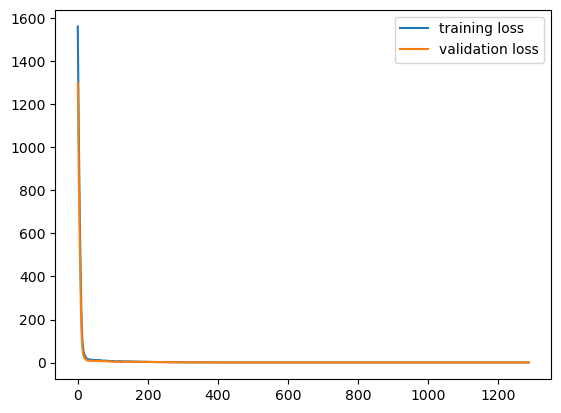

20
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
hold out: P83
P42
P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
hold out: P57
P15
P29
img not found P29
P68
20
 Epoch: 0000 loss_train: 1530.2506 loss_val: 1344.2751 time: 0.1195s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 238.4390 loss_val: 167.8058 time: 0.2020s
 Epoch: 0020 loss_train: 29.3222 loss_val: 16.4369 time: 0.0463s
 Epoch: 0030 loss_train: 16.7792 loss_val: 7.8497 time: 0.0947s
 Epoch: 0040 loss_train: 14.0342 loss_val: 6.6974 time: 0.0555s
 Epoch: 0050 loss_train: 12.0277 loss_val: 6.0975 time: 0.0480s
 Epoch: 0060 loss_train: 11.7864 loss_val: 5.6682 time: 0.0481s
 Epoch: 0070 loss_train: 9.3013 loss_val: 5.2632 time: 0.1765s
 Epoch: 0080 loss_train: 8.4848 loss_val: 4.4476 time: 0.0808s
 Epoch: 0090 loss_train: 6.4317 loss_val: 3.1798 time: 0.1230s
 Epoch: 0100 loss_train: 5.8340 loss_val: 2.7422 time: 0.1194s
 Epoch: 0110 loss_train: 5.8109 loss_val: 2.6035 time: 0.1203s
 Epoch: 0120 loss_train: 5.8748 loss_val: 2.5450 time: 0.1301s
 Epoch: 0130 loss_train: 5.3945 loss_val: 2.3888 time: 0.0490s
 Epoch: 0140 loss_train: 4.9989 loss_val: 2.4270 time: 0.1001s
 Epoch: 0150 loss_train: 4.6690 loss_val: 2.2017 time: 0.1156s
 Epoch: 0160 loss_train: 4.8108 loss_val: 2.2

 Epoch: 1310 loss_train: 0.6815 loss_val: 0.5535 time: 0.0612s
 Epoch: 1320 loss_train: 0.6792 loss_val: 0.5555 time: 0.0556s
 Epoch: 1330 loss_train: 0.6678 loss_val: 0.5533 time: 0.0533s
 Epoch: 1340 loss_train: 0.6612 loss_val: 0.5527 time: 0.0496s
 Epoch: 1350 loss_train: 0.6816 loss_val: 0.5510 time: 0.0485s
 Epoch: 1360 loss_train: 0.6736 loss_val: 0.5501 time: 0.0690s
 Epoch: 1370 loss_train: 0.6713 loss_val: 0.5530 time: 0.0632s
 Epoch: 1380 loss_train: 0.6935 loss_val: 0.5523 time: 0.0581s
 Epoch: 1390 loss_train: 0.6785 loss_val: 0.5477 time: 0.0734s
 Epoch: 1400 loss_train: 0.6650 loss_val: 0.5467 time: 0.0502s
 Epoch: 1410 loss_train: 0.6718 loss_val: 0.5470 time: 0.0570s
 Epoch: 1420 loss_train: 0.6793 loss_val: 0.5448 time: 0.0609s
 Epoch: 1430 loss_train: 0.6557 loss_val: 0.5445 time: 0.0587s
 Epoch: 1440 loss_train: 0.6531 loss_val: 0.5407 time: 0.0680s
 Epoch: 1450 loss_train: 0.6608 loss_val: 0.5489 time: 0.0577s
 Epoch: 1460 loss_train: 0.6673 loss_val: 0.5469 time: 

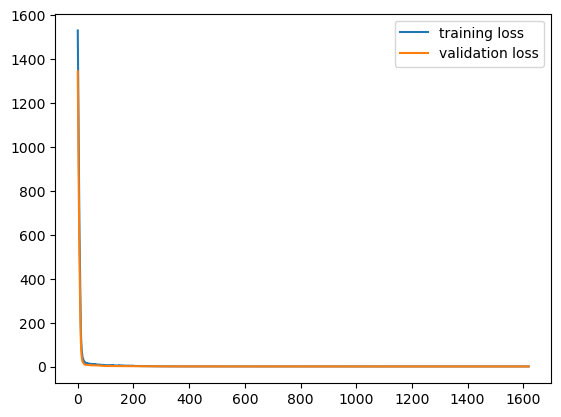

21
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
hold out: HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
hold out: P41
P56
hold out: P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
hold out: P38
P48
P37
hold out: P62
glioma
dapi_gh2ax_lamin_cd3
P46
hold out: P16
hold out: P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
21
 Epoch: 0000 loss_train: 1557.4170 loss_val: 1313.7850 time: 0.0473s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 284.2342 loss_val: 201.3040 time: 0.0439s
 Epoch: 0020 loss_train: 31.4432 loss_val: 17.6610 time: 0.0491s
 Epoch: 0030 loss_train: 13.5618 loss_val: 8.4016 time: 0.0464s
 Epoch: 0040 loss_train: 11.1318 loss_val: 7.2910 time: 0.0459s
 Epoch: 0050 loss_train: 10.3011 loss_val: 6.7191 time: 0.0471s
 Epoch: 0060 loss_train: 9.0980 loss_val: 6.3261 time: 0.0431s
 Epoch: 0070 loss_train: 7.9964 loss_val: 5.6755 time: 0.0499s
 Epoch: 0080 loss_train: 7.5576 loss_val: 5.5202 time: 0.0470s
 Epoch: 0090 loss_train: 7.2402 loss_val: 4.9788 time: 0.0580s
 Epoch: 0100 loss_train: 5.6087 loss_val: 4.4671 time: 0.0569s
 Epoch: 0110 loss_train: 5.2445 loss_val: 3.4666 time: 0.0876s
 Epoch: 0120 loss_train: 4.8522 loss_val: 3.4805 time: 0.0549s
 Epoch: 0130 loss_train: 5.0589 loss_val: 3.3612 time: 0.1394s
 Epoch: 0140 loss_train: 4.2024 loss_val: 3.3378 time: 0.1536s
 Epoch: 0150 loss_train: 4.5290 loss_val: 3.2958 time: 0.1375s
 Epoch: 0160 loss_train: 3.8087 loss_val: 3.13

 Epoch: 1310 loss_train: 0.6838 loss_val: 0.5235 time: 0.0862s
 Epoch: 1320 loss_train: 0.6677 loss_val: 0.5202 time: 0.0486s
 Epoch: 1330 loss_train: 0.6859 loss_val: 0.5197 time: 0.0459s
 Epoch: 1340 loss_train: 0.6797 loss_val: 0.5254 time: 0.0602s
 Epoch: 1350 loss_train: 0.6820 loss_val: 0.5184 time: 0.1764s
 Epoch: 1360 loss_train: 0.6768 loss_val: 0.5197 time: 0.1094s
 Epoch: 1370 loss_train: 0.6821 loss_val: 0.5171 time: 0.0447s
 Epoch: 1380 loss_train: 0.6764 loss_val: 0.5190 time: 0.1065s
 Epoch: 1390 loss_train: 0.6720 loss_val: 0.5208 time: 0.0878s
 Epoch: 1400 loss_train: 0.6863 loss_val: 0.5184 time: 0.0919s
 Epoch: 1410 loss_train: 0.6805 loss_val: 0.5234 time: 0.0438s
 Epoch: 1420 loss_train: 0.6706 loss_val: 0.5213 time: 0.0909s
 Epoch: 1430 loss_train: 0.6625 loss_val: 0.5202 time: 0.0493s
 Epoch: 1440 loss_train: 0.6721 loss_val: 0.5205 time: 0.0720s
 Epoch: 1450 loss_train: 0.6711 loss_val: 0.5126 time: 0.1072s
 Epoch: 1460 loss_train: 0.6717 loss_val: 0.5119 time: 

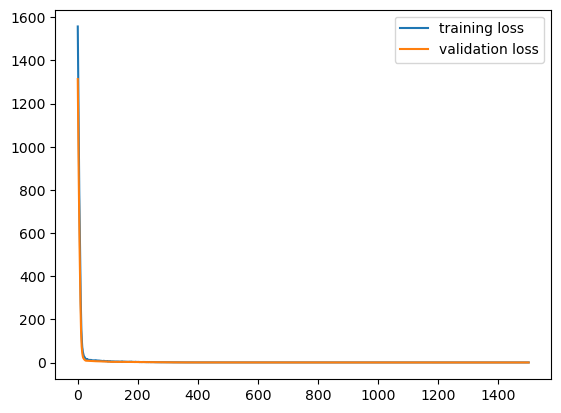

22
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
hold out: P56
P18
P55
hold out: P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
hold out: P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
hold out: P84
P47
P57
P15
P29
img not found P29
P68
22
 Epoch: 0000 loss_train: 1575.2408 loss_val: 1383.9410 time: 0.0726s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 280.8469 loss_val: 201.6465 time: 0.0439s
 Epoch: 0020 loss_train: 31.6316 loss_val: 24.3119 time: 0.1253s
 Epoch: 0030 loss_train: 14.9731 loss_val: 13.8489 time: 0.0458s
 Epoch: 0040 loss_train: 12.7121 loss_val: 12.6358 time: 0.1310s
 Epoch: 0050 loss_train: 11.5786 loss_val: 11.1948 time: 0.1953s
 Epoch: 0060 loss_train: 10.3716 loss_val: 9.7472 time: 0.1331s
 Epoch: 0070 loss_train: 8.9996 loss_val: 8.6082 time: 0.1227s
 Epoch: 0080 loss_train: 8.0656 loss_val: 6.7575 time: 0.1194s
 Epoch: 0090 loss_train: 6.5416 loss_val: 5.6547 time: 0.0449s
 Epoch: 0100 loss_train: 6.3526 loss_val: 5.4122 time: 0.0959s
 Epoch: 0110 loss_train: 6.4658 loss_val: 5.1886 time: 0.1109s
 Epoch: 0120 loss_train: 5.2874 loss_val: 5.0019 time: 0.1259s
 Epoch: 0130 loss_train: 4.8607 loss_val: 4.7479 time: 0.1285s
 Epoch: 0140 loss_train: 4.4032 loss_val: 4.5879 time: 0.1033s
 Epoch: 0150 loss_train: 4.2889 loss_val: 4.4243 time: 0.0941s
 Epoch: 0160 loss_train: 4.0077 loss_val: 

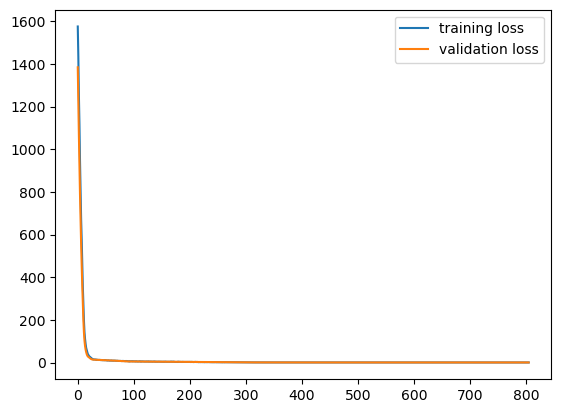

23
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
hold out: P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
23


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1548.0163 loss_val: 1405.2299 time: 0.1837s
 Epoch: 0010 loss_train: 265.4900 loss_val: 192.7194 time: 0.1032s
 Epoch: 0020 loss_train: 32.1669 loss_val: 21.1985 time: 0.0439s
 Epoch: 0030 loss_train: 14.9242 loss_val: 11.4760 time: 0.1173s
 Epoch: 0040 loss_train: 12.1983 loss_val: 10.1162 time: 0.0518s
 Epoch: 0050 loss_train: 10.8385 loss_val: 8.8260 time: 0.1017s
 Epoch: 0060 loss_train: 9.3132 loss_val: 7.9834 time: 0.0746s
 Epoch: 0070 loss_train: 8.6401 loss_val: 7.3088 time: 0.1105s
 Epoch: 0080 loss_train: 7.4590 loss_val: 6.6677 time: 0.0737s
 Epoch: 0090 loss_train: 6.4502 loss_val: 5.8356 time: 0.0467s
 Epoch: 0100 loss_train: 6.2754 loss_val: 3.9983 time: 0.0992s
 Epoch: 0110 loss_train: 5.2934 loss_val: 3.5326 time: 0.0482s
 Epoch: 0120 loss_train: 4.2631 loss_val: 3.3235 time: 0.0510s
 Epoch: 0130 loss_train: 5.4879 loss_val: 3.0259 time: 0.1632s
 Epoch: 0140 loss_train: 5.1224 loss_val: 2.9221 time: 0.1120s
 Epoch: 0150 loss_train: 4.0384 loss_v

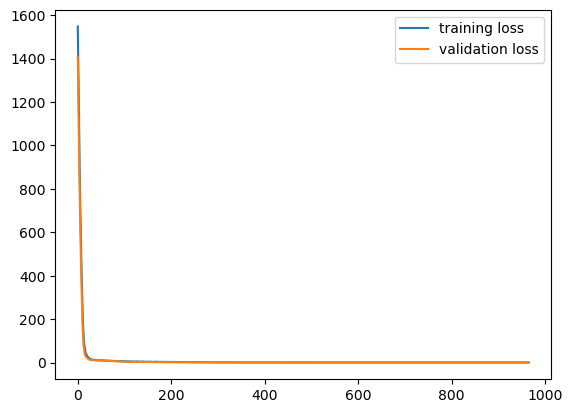

24
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
24
 Epoch: 0000 loss_train: 1637.0074 loss_val: 1435.5770 time: 0.0568s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 281.5601 loss_val: 195.9937 time: 0.0543s
 Epoch: 0020 loss_train: 31.3075 loss_val: 15.6209 time: 0.0451s
 Epoch: 0030 loss_train: 15.6527 loss_val: 5.8940 time: 0.0609s
 Epoch: 0040 loss_train: 12.5440 loss_val: 4.5791 time: 0.0692s
 Epoch: 0050 loss_train: 9.8626 loss_val: 4.3449 time: 0.0615s
 Epoch: 0060 loss_train: 9.5872 loss_val: 3.9556 time: 0.0571s
 Epoch: 0070 loss_train: 7.9255 loss_val: 3.7459 time: 0.0527s
 Epoch: 0080 loss_train: 7.8302 loss_val: 3.4292 time: 0.0456s
 Epoch: 0090 loss_train: 6.5827 loss_val: 2.9060 time: 0.0557s
 Epoch: 0100 loss_train: 6.3367 loss_val: 2.6282 time: 0.0600s
 Epoch: 0110 loss_train: 6.3941 loss_val: 2.2626 time: 0.0581s
 Epoch: 0120 loss_train: 6.1259 loss_val: 2.2429 time: 0.0487s
 Epoch: 0130 loss_train: 4.3323 loss_val: 2.2198 time: 0.0581s
 Epoch: 0140 loss_train: 4.3005 loss_val: 1.9645 time: 0.0505s
 Epoch: 0150 loss_train: 5.0674 loss_val: 1.8814 time: 0.0508s
 Epoch: 0160 loss_train: 3.8724 loss_val: 1.821

 Epoch: 1310 loss_train: 0.6458 loss_val: 0.5216 time: 0.0713s
 total time: 93.9862s


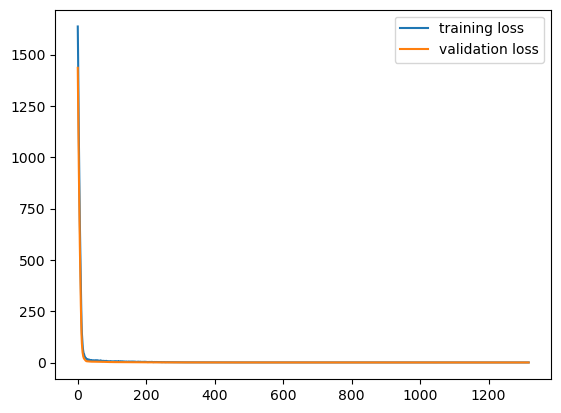

25
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
hold out: P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
hold out: P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
hold out: P68
25
 Epoch: 0000 loss_train: 1561.0550 loss_val: 1325.9268 time: 0.0753s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 261.8569 loss_val: 186.4039 time: 0.0976s
 Epoch: 0020 loss_train: 34.2088 loss_val: 18.0063 time: 0.0506s
 Epoch: 0030 loss_train: 14.8531 loss_val: 9.0758 time: 0.0522s
 Epoch: 0040 loss_train: 13.4111 loss_val: 8.0425 time: 0.0548s
 Epoch: 0050 loss_train: 11.4333 loss_val: 7.8310 time: 0.0604s
 Epoch: 0060 loss_train: 10.3792 loss_val: 7.2973 time: 0.1450s
 Epoch: 0070 loss_train: 9.3245 loss_val: 6.7717 time: 0.0605s
 Epoch: 0080 loss_train: 8.4122 loss_val: 6.3649 time: 0.0614s
 Epoch: 0090 loss_train: 7.0819 loss_val: 3.9954 time: 0.0518s
 Epoch: 0100 loss_train: 6.1909 loss_val: 3.5783 time: 0.0742s
 Epoch: 0110 loss_train: 7.1803 loss_val: 3.4654 time: 0.0588s
 Epoch: 0120 loss_train: 4.4145 loss_val: 3.2483 time: 0.1164s
 Epoch: 0130 loss_train: 4.9661 loss_val: 3.2653 time: 0.0522s
 Epoch: 0140 loss_train: 5.3336 loss_val: 3.0576 time: 0.0545s
 Epoch: 0150 loss_train: 5.3179 loss_val: 2.8834 time: 0.0589s
 Epoch: 0160 loss_train: 4.2316 loss_val: 2.7

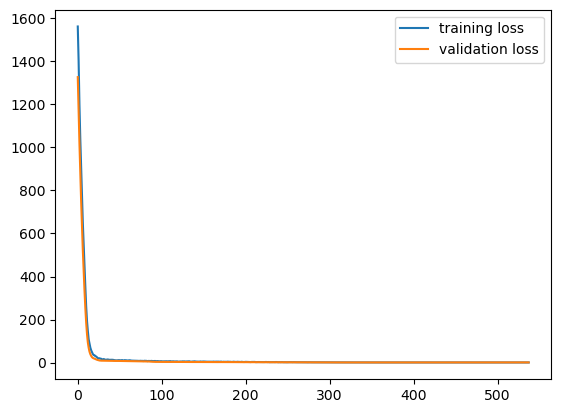

26
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
hold out: P83
P42
P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
hold out: P57
P15
P29
img not found P29
P68
26
 Epoch: 0000 loss_train: 1565.6055 loss_val: 1384.9844 time: 0.0573s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 241.2795 loss_val: 175.7172 time: 0.0481s
 Epoch: 0020 loss_train: 30.4408 loss_val: 17.5649 time: 0.0552s
 Epoch: 0030 loss_train: 16.1855 loss_val: 8.4422 time: 0.0597s
 Epoch: 0040 loss_train: 13.1492 loss_val: 7.2179 time: 0.1898s
 Epoch: 0050 loss_train: 11.6191 loss_val: 6.8466 time: 0.0592s
 Epoch: 0060 loss_train: 10.4330 loss_val: 6.3156 time: 0.1777s
 Epoch: 0070 loss_train: 9.8273 loss_val: 5.5497 time: 0.0801s
 Epoch: 0080 loss_train: 7.5256 loss_val: 4.6597 time: 0.0656s
 Epoch: 0090 loss_train: 6.3116 loss_val: 3.4902 time: 0.0584s
 Epoch: 0100 loss_train: 5.9478 loss_val: 3.2659 time: 0.0526s
 Epoch: 0110 loss_train: 6.3200 loss_val: 3.1036 time: 0.0617s
 Epoch: 0120 loss_train: 5.4729 loss_val: 3.0458 time: 0.0508s
 Epoch: 0130 loss_train: 4.6569 loss_val: 3.1035 time: 0.0644s
 Epoch: 0140 loss_train: 4.6666 loss_val: 2.9582 time: 0.0479s
 Epoch: 0150 loss_train: 4.6555 loss_val: 2.8816 time: 0.1074s
 Epoch: 0160 loss_train: 4.9304 loss_val: 2.7

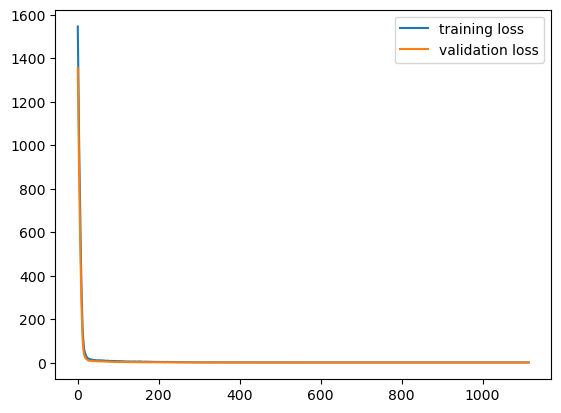

28
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
hold out: P56
P18
P55
hold out: P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
hold out: P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
hold out: P84
P47
P57
P15
P29
img not found P29
P68
28
 Epoch: 0000 loss_train: 1613.1442 loss_val: 1402.2489 time: 0.0551s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 279.7168 loss_val: 201.3003 time: 0.0494s
 Epoch: 0020 loss_train: 33.9796 loss_val: 20.1114 time: 0.0607s
 Epoch: 0030 loss_train: 16.0942 loss_val: 10.3324 time: 0.1255s
 Epoch: 0040 loss_train: 13.1925 loss_val: 9.2798 time: 0.0499s
 Epoch: 0050 loss_train: 11.5512 loss_val: 8.5072 time: 0.0597s
 Epoch: 0060 loss_train: 10.8614 loss_val: 7.7485 time: 0.1268s
 Epoch: 0070 loss_train: 8.5069 loss_val: 6.7391 time: 0.0579s
 Epoch: 0080 loss_train: 9.0693 loss_val: 4.9196 time: 0.0776s
 Epoch: 0090 loss_train: 6.1938 loss_val: 4.5952 time: 0.1010s
 Epoch: 0100 loss_train: 6.0244 loss_val: 4.2882 time: 0.0459s
 Epoch: 0110 loss_train: 5.1367 loss_val: 4.0371 time: 0.1190s
 Epoch: 0120 loss_train: 5.6127 loss_val: 3.8807 time: 0.0758s
 Epoch: 0130 loss_train: 5.0435 loss_val: 3.7593 time: 0.0501s
 Epoch: 0140 loss_train: 5.2294 loss_val: 3.5894 time: 0.1120s
 Epoch: 0150 loss_train: 4.5920 loss_val: 3.4821 time: 0.0440s
 Epoch: 0160 loss_train: 4.5321 loss_val: 3.

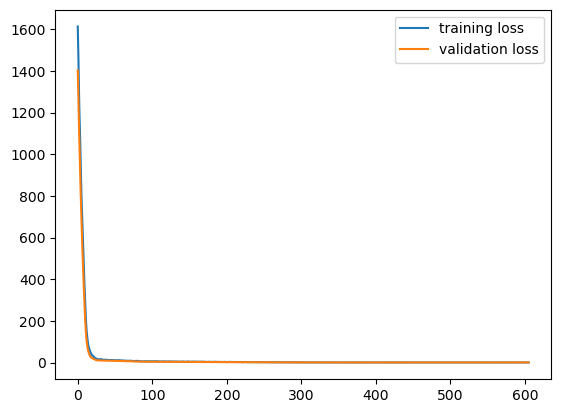

29
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
hold out: P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
29
 Epoch: 0000 loss_train: 1551.4570 loss_val: 1400.3468 time: 0.0448s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 263.2349 loss_val: 190.1681 time: 0.1213s
 Epoch: 0020 loss_train: 33.0471 loss_val: 17.9573 time: 0.1451s
 Epoch: 0030 loss_train: 15.6841 loss_val: 7.4211 time: 0.1133s
 Epoch: 0040 loss_train: 11.9790 loss_val: 6.4166 time: 0.0471s
 Epoch: 0050 loss_train: 10.9156 loss_val: 5.9413 time: 0.0804s
 Epoch: 0060 loss_train: 10.1924 loss_val: 5.5605 time: 0.1092s
 Epoch: 0070 loss_train: 9.2736 loss_val: 4.7811 time: 0.0496s
 Epoch: 0080 loss_train: 7.6568 loss_val: 3.7714 time: 0.0469s
 Epoch: 0090 loss_train: 6.9641 loss_val: 2.8051 time: 0.0459s
 Epoch: 0100 loss_train: 6.2056 loss_val: 2.5006 time: 0.0861s
 Epoch: 0110 loss_train: 6.0697 loss_val: 2.4349 time: 0.0457s
 Epoch: 0120 loss_train: 4.8741 loss_val: 2.2866 time: 0.0471s
 Epoch: 0130 loss_train: 5.5028 loss_val: 2.2920 time: 0.1180s
 Epoch: 0140 loss_train: 4.4100 loss_val: 2.2162 time: 0.0809s
 Epoch: 0150 loss_train: 5.0223 loss_val: 2.2711 time: 0.0452s
 Epoch: 0160 loss_train: 4.0648 loss_val: 2.1

 Epoch: 1310 loss_train: 0.6889 loss_val: 0.5674 time: 0.0540s
 Epoch: 1320 loss_train: 0.7043 loss_val: 0.5665 time: 0.0512s
 Epoch: 1330 loss_train: 0.7265 loss_val: 0.5658 time: 0.0453s
 Epoch: 1340 loss_train: 0.7021 loss_val: 0.5583 time: 0.0590s
 Epoch: 1350 loss_train: 0.6909 loss_val: 0.5675 time: 0.0520s
 Epoch: 1360 loss_train: 0.7109 loss_val: 0.5699 time: 0.0514s
 Epoch: 1370 loss_train: 0.6898 loss_val: 0.5619 time: 0.0568s
 Epoch: 1380 loss_train: 0.6817 loss_val: 0.5610 time: 0.0510s
 Epoch: 1390 loss_train: 0.6982 loss_val: 0.5630 time: 0.0487s
 Epoch: 1400 loss_train: 0.7136 loss_val: 0.5627 time: 0.0507s
 Epoch: 1410 loss_train: 0.7348 loss_val: 0.5660 time: 0.0508s
 Epoch: 1420 loss_train: 0.6920 loss_val: 0.5622 time: 0.0504s
 Epoch: 1430 loss_train: 0.7243 loss_val: 0.5619 time: 0.0506s
 Epoch: 1440 loss_train: 0.6982 loss_val: 0.5586 time: 0.0611s
 Epoch: 1450 loss_train: 0.7048 loss_val: 0.5645 time: 0.0484s
 Epoch: 1460 loss_train: 0.7279 loss_val: 0.5617 time: 

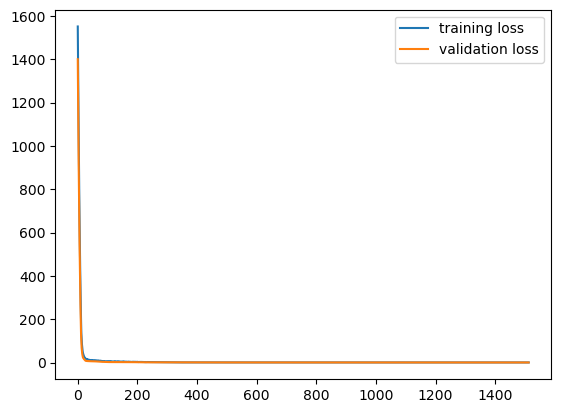

30
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
30
 Epoch: 0000 loss_train: 1611.1324 loss_val: 1504.2220 time: 0.0489s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 276.0841 loss_val: 210.9190 time: 0.0506s
 Epoch: 0020 loss_train: 28.7060 loss_val: 20.7288 time: 0.0497s
 Epoch: 0030 loss_train: 11.2312 loss_val: 9.9139 time: 0.0512s
 Epoch: 0040 loss_train: 9.3627 loss_val: 8.8140 time: 0.0522s
 Epoch: 0050 loss_train: 8.8070 loss_val: 8.1190 time: 0.0498s
 Epoch: 0060 loss_train: 7.2927 loss_val: 7.5452 time: 0.0481s
 Epoch: 0070 loss_train: 9.0613 loss_val: 6.9201 time: 0.0491s
 Epoch: 0080 loss_train: 6.3886 loss_val: 6.2738 time: 0.0511s
 Epoch: 0090 loss_train: 5.8872 loss_val: 5.2754 time: 0.0578s
 Epoch: 0100 loss_train: 5.8694 loss_val: 5.0812 time: 0.0601s
 Epoch: 0110 loss_train: 5.6198 loss_val: 4.9161 time: 0.0501s
 Epoch: 0120 loss_train: 4.8295 loss_val: 4.8558 time: 0.0476s
 Epoch: 0130 loss_train: 4.1058 loss_val: 4.8181 time: 0.0565s
 Epoch: 0140 loss_train: 4.3188 loss_val: 4.7305 time: 0.0476s
 Epoch: 0150 loss_train: 4.0116 loss_val: 4.4751 time: 0.0582s
 Epoch: 0160 loss_train: 4.2673 loss_val: 4.3520

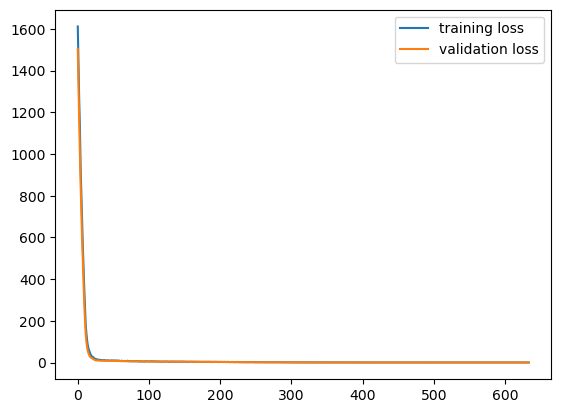

31
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
hold out: P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
hold out: P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
hold out: P68
31
 Epoch: 0000 loss_train: 1568.3632 loss_val: 1392.2559 time: 0.0465s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 257.1176 loss_val: 196.9587 time: 0.0528s
 Epoch: 0020 loss_train: 32.5652 loss_val: 17.4462 time: 0.0818s
 Epoch: 0030 loss_train: 15.1957 loss_val: 7.2752 time: 0.0452s
 Epoch: 0040 loss_train: 14.1439 loss_val: 6.3402 time: 0.0465s
 Epoch: 0050 loss_train: 11.2912 loss_val: 6.0929 time: 0.0435s
 Epoch: 0060 loss_train: 10.1199 loss_val: 5.7664 time: 0.0456s
 Epoch: 0070 loss_train: 10.0060 loss_val: 5.3711 time: 0.0450s
 Epoch: 0080 loss_train: 8.8763 loss_val: 4.9660 time: 0.1295s
 Epoch: 0090 loss_train: 7.9099 loss_val: 4.3692 time: 0.0474s
 Epoch: 0100 loss_train: 6.4206 loss_val: 2.8598 time: 0.0626s
 Epoch: 0110 loss_train: 6.1383 loss_val: 3.0370 time: 0.0858s
 Epoch: 0120 loss_train: 5.0948 loss_val: 2.8651 time: 0.0991s
 Epoch: 0130 loss_train: 4.9245 loss_val: 2.7752 time: 0.0793s
 Epoch: 0140 loss_train: 5.2232 loss_val: 2.6975 time: 0.0548s
 Epoch: 0150 loss_train: 4.2944 loss_val: 2.5854 time: 0.0448s
 Epoch: 0160 loss_train: 3.9710 loss_val: 2.

 Epoch: 1310 loss_train: 0.7252 loss_val: 0.5692 time: 0.0457s
 Epoch: 1320 loss_train: 0.7240 loss_val: 0.5858 time: 0.0455s
 Epoch: 1330 loss_train: 0.7075 loss_val: 0.5765 time: 0.0519s
 Epoch: 1340 loss_train: 0.7171 loss_val: 0.5767 time: 0.0621s
 Epoch: 1350 loss_train: 0.7088 loss_val: 0.5771 time: 0.0479s
 Epoch: 1360 loss_train: 0.7096 loss_val: 0.5778 time: 0.0603s
 Epoch: 1370 loss_train: 0.7176 loss_val: 0.5837 time: 0.0474s
 Epoch: 1380 loss_train: 0.7144 loss_val: 0.5785 time: 0.0477s
 total time: 105.2522s


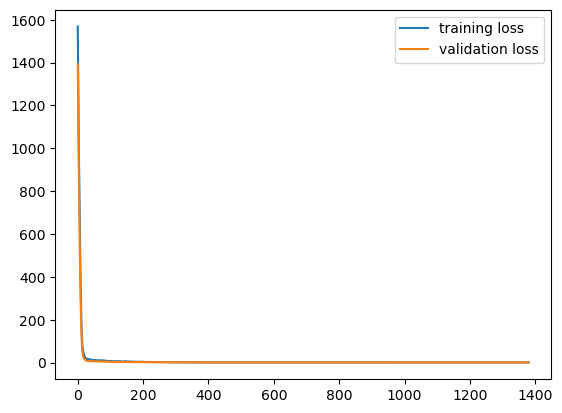

32
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
hold out: P83
P42
P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
hold out: P57
P15
P29
img not found P29
P68
32
 Epoch: 0000 loss_train: 1535.2494 loss_val: 1392.8767 time: 0.1211s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 240.7482 loss_val: 175.2689 time: 0.0825s
 Epoch: 0020 loss_train: 31.3201 loss_val: 18.3266 time: 0.1091s
 Epoch: 0030 loss_train: 14.4215 loss_val: 9.3638 time: 0.1104s
 Epoch: 0040 loss_train: 12.7420 loss_val: 8.5174 time: 0.0466s
 Epoch: 0050 loss_train: 10.9820 loss_val: 8.0050 time: 0.0565s
 Epoch: 0060 loss_train: 9.9903 loss_val: 7.5725 time: 0.0962s
 Epoch: 0070 loss_train: 8.7273 loss_val: 7.1213 time: 0.0930s
 Epoch: 0080 loss_train: 7.9903 loss_val: 6.5569 time: 0.0854s
 Epoch: 0090 loss_train: 6.5358 loss_val: 5.4769 time: 0.1159s
 Epoch: 0100 loss_train: 5.2555 loss_val: 4.7318 time: 0.0532s
 Epoch: 0110 loss_train: 5.4088 loss_val: 4.6328 time: 0.0598s
 Epoch: 0120 loss_train: 4.8996 loss_val: 4.5750 time: 0.0476s
 Epoch: 0130 loss_train: 4.2192 loss_val: 4.4180 time: 0.0463s
 Epoch: 0140 loss_train: 4.2003 loss_val: 4.3564 time: 0.0452s
 Epoch: 0150 loss_train: 4.4490 loss_val: 4.2172 time: 0.0449s
 Epoch: 0160 loss_train: 3.7078 loss_val: 4.07

 Epoch: 1310 loss_train: 0.7116 loss_val: 0.5431 time: 0.0563s
 Epoch: 1320 loss_train: 0.6732 loss_val: 0.5399 time: 0.0502s
 Epoch: 1330 loss_train: 0.6867 loss_val: 0.5353 time: 0.0494s
 Epoch: 1340 loss_train: 0.6679 loss_val: 0.5399 time: 0.0541s
 Epoch: 1350 loss_train: 0.6697 loss_val: 0.5352 time: 0.0514s
 Epoch: 1360 loss_train: 0.6637 loss_val: 0.5350 time: 0.0662s
 Epoch: 1370 loss_train: 0.6926 loss_val: 0.5301 time: 0.0482s
 Epoch: 1380 loss_train: 0.6683 loss_val: 0.5342 time: 0.0532s
 Epoch: 1390 loss_train: 0.6866 loss_val: 0.5323 time: 0.0542s
 Epoch: 1400 loss_train: 0.6790 loss_val: 0.5366 time: 0.0524s
 Epoch: 1410 loss_train: 0.6794 loss_val: 0.5354 time: 0.0646s
 Epoch: 1420 loss_train: 0.6819 loss_val: 0.5323 time: 0.0548s
 Epoch: 1430 loss_train: 0.6776 loss_val: 0.5332 time: 0.0595s
 Epoch: 1440 loss_train: 0.6735 loss_val: 0.5358 time: 0.0529s
 Epoch: 1450 loss_train: 0.6741 loss_val: 0.5291 time: 0.0496s
 Epoch: 1460 loss_train: 0.6870 loss_val: 0.5319 time: 

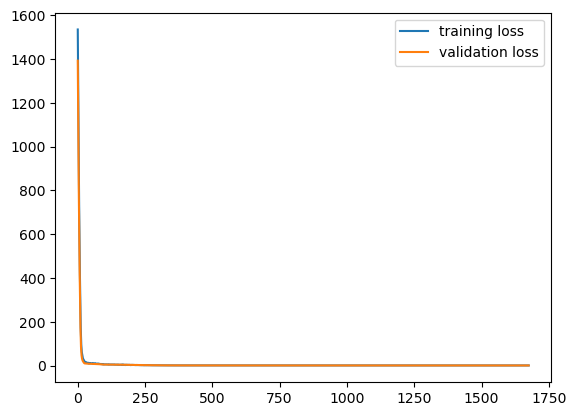

33
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
hold out: HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
hold out: P41
P56
hold out: P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
hold out: P38
P48
P37
hold out: P62
glioma
dapi_gh2ax_lamin_cd3
P46
hold out: P16
hold out: P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
33
 Epoch: 0000 loss_train: 1564.3135 loss_val: 1338.1452 time: 0.0562s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 278.4738 loss_val: 208.6088 time: 0.0514s
 Epoch: 0020 loss_train: 32.8185 loss_val: 20.5429 time: 0.0544s
 Epoch: 0030 loss_train: 14.5759 loss_val: 9.1462 time: 0.0518s
 Epoch: 0040 loss_train: 11.6178 loss_val: 7.9732 time: 0.0491s
 Epoch: 0050 loss_train: 10.6073 loss_val: 7.4761 time: 0.0505s
 Epoch: 0060 loss_train: 9.1982 loss_val: 6.8016 time: 0.0585s
 Epoch: 0070 loss_train: 6.9619 loss_val: 6.4562 time: 0.0484s
 Epoch: 0080 loss_train: 7.7891 loss_val: 5.9277 time: 0.0469s
 Epoch: 0090 loss_train: 6.4461 loss_val: 5.3538 time: 0.0487s
 Epoch: 0100 loss_train: 5.7562 loss_val: 5.0306 time: 0.0481s
 Epoch: 0110 loss_train: 5.4297 loss_val: 4.9005 time: 0.0553s
 Epoch: 0120 loss_train: 4.1925 loss_val: 4.7661 time: 0.0545s
 Epoch: 0130 loss_train: 4.5212 loss_val: 4.5038 time: 0.0486s
 Epoch: 0140 loss_train: 4.4664 loss_val: 4.5077 time: 0.0558s
 Epoch: 0150 loss_train: 3.1339 loss_val: 4.4769 time: 0.0551s
 Epoch: 0160 loss_train: 3.3402 loss_val: 4.33

 Epoch: 1310 loss_train: 0.6845 loss_val: 0.5621 time: 0.0460s
 Epoch: 1320 loss_train: 0.6885 loss_val: 0.5623 time: 0.2123s
 Epoch: 1330 loss_train: 0.6893 loss_val: 0.5630 time: 0.1190s
 Epoch: 1340 loss_train: 0.6971 loss_val: 0.5617 time: 0.1221s
 Epoch: 1350 loss_train: 0.6906 loss_val: 0.5662 time: 0.0884s
 Epoch: 1360 loss_train: 0.6896 loss_val: 0.5589 time: 0.0452s
 Epoch: 1370 loss_train: 0.6861 loss_val: 0.5577 time: 0.0862s
 Epoch: 1380 loss_train: 0.6791 loss_val: 0.5549 time: 0.0839s
 Epoch: 1390 loss_train: 0.6787 loss_val: 0.5613 time: 0.0526s
 Epoch: 1400 loss_train: 0.6924 loss_val: 0.5603 time: 0.0484s
 Epoch: 1410 loss_train: 0.6824 loss_val: 0.5546 time: 0.0485s
 total time: 94.9117s


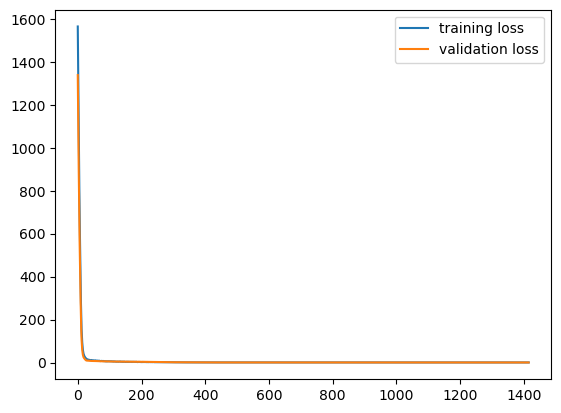

34
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
hold out: P56
P18
P55
hold out: P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
hold out: P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
hold out: P84
P47
P57
P15
P29
img not found P29
P68
34
 Epoch: 0000 loss_train: 1606.3904 loss_val: 1438.1661 time: 0.0469s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 282.2908 loss_val: 207.7824 time: 0.0943s
 Epoch: 0020 loss_train: 33.5327 loss_val: 18.9745 time: 0.1485s
 Epoch: 0030 loss_train: 15.8948 loss_val: 8.3501 time: 0.0476s
 Epoch: 0040 loss_train: 12.9183 loss_val: 7.0183 time: 0.0914s
 Epoch: 0050 loss_train: 12.0288 loss_val: 6.4189 time: 0.0464s
 Epoch: 0060 loss_train: 10.1695 loss_val: 5.3945 time: 0.0488s
 Epoch: 0070 loss_train: 8.8882 loss_val: 4.5768 time: 0.0449s
 Epoch: 0080 loss_train: 8.2737 loss_val: 3.4770 time: 0.0545s
 Epoch: 0090 loss_train: 7.6260 loss_val: 2.7927 time: 0.0470s
 Epoch: 0100 loss_train: 6.3171 loss_val: 2.5320 time: 0.0670s
 Epoch: 0110 loss_train: 6.4186 loss_val: 2.5649 time: 0.0472s
 Epoch: 0120 loss_train: 6.2433 loss_val: 2.3717 time: 0.0784s
 Epoch: 0130 loss_train: 5.4873 loss_val: 2.3428 time: 0.1033s
 Epoch: 0140 loss_train: 5.1927 loss_val: 2.2617 time: 0.0488s
 Epoch: 0150 loss_train: 4.6391 loss_val: 2.2245 time: 0.1059s
 Epoch: 0160 loss_train: 4.6566 loss_val: 2.1

 Epoch: 1310 loss_train: 0.6914 loss_val: 0.5783 time: 0.0435s
 Epoch: 1320 loss_train: 0.7205 loss_val: 0.5830 time: 0.0534s
 Epoch: 1330 loss_train: 0.6972 loss_val: 0.5808 time: 0.0505s
 Epoch: 1340 loss_train: 0.7181 loss_val: 0.5770 time: 0.0552s
 Epoch: 1350 loss_train: 0.6892 loss_val: 0.5762 time: 0.1931s
 Epoch: 1360 loss_train: 0.6974 loss_val: 0.5761 time: 0.0929s
 Epoch: 1370 loss_train: 0.6954 loss_val: 0.5712 time: 0.0583s
 Epoch: 1380 loss_train: 0.6934 loss_val: 0.5664 time: 0.0447s
 Epoch: 1390 loss_train: 0.6863 loss_val: 0.5818 time: 0.0563s
 Epoch: 1400 loss_train: 0.7197 loss_val: 0.5768 time: 0.0524s
 Epoch: 1410 loss_train: 0.6857 loss_val: 0.5669 time: 0.0490s
 Epoch: 1420 loss_train: 0.6950 loss_val: 0.5645 time: 0.0581s
 Epoch: 1430 loss_train: 0.6959 loss_val: 0.5732 time: 0.1440s
 Epoch: 1440 loss_train: 0.6855 loss_val: 0.5661 time: 0.0766s
 total time: 111.0704s


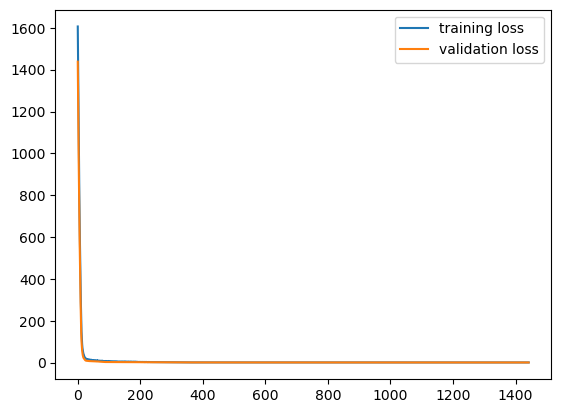

35
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
hold out: P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
35
 Epoch: 0000 loss_train: 1600.7206 loss_val: 1397.7590 time: 0.0699s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 263.3006 loss_val: 194.5113 time: 0.0443s
 Epoch: 0020 loss_train: 31.9347 loss_val: 15.4184 time: 0.1045s
 Epoch: 0030 loss_train: 14.0607 loss_val: 5.7909 time: 0.1016s
 Epoch: 0040 loss_train: 11.5673 loss_val: 4.8440 time: 0.0566s
 Epoch: 0050 loss_train: 11.4270 loss_val: 4.6106 time: 0.0474s
 Epoch: 0060 loss_train: 10.1203 loss_val: 4.2346 time: 0.1043s
 Epoch: 0070 loss_train: 9.1177 loss_val: 3.7029 time: 0.0685s
 Epoch: 0080 loss_train: 7.3842 loss_val: 2.8806 time: 0.0464s
 Epoch: 0090 loss_train: 7.5351 loss_val: 2.0636 time: 0.0834s
 Epoch: 0100 loss_train: 6.2394 loss_val: 1.7170 time: 0.0558s
 Epoch: 0110 loss_train: 5.5933 loss_val: 1.6952 time: 0.0536s
 Epoch: 0120 loss_train: 5.8606 loss_val: 1.6454 time: 0.0477s
 Epoch: 0130 loss_train: 5.1396 loss_val: 1.6347 time: 0.0647s
 Epoch: 0140 loss_train: 3.8826 loss_val: 1.6403 time: 0.1070s
 Epoch: 0150 loss_train: 4.8227 loss_val: 1.6182 time: 0.0523s
 Epoch: 0160 loss_train: 4.1341 loss_val: 1.6

 Epoch: 1310 loss_train: 0.7009 loss_val: 0.5565 time: 0.0814s
 Epoch: 1320 loss_train: 0.6879 loss_val: 0.5633 time: 0.1027s
 Epoch: 1330 loss_train: 0.7247 loss_val: 0.5577 time: 0.0561s
 Epoch: 1340 loss_train: 0.6927 loss_val: 0.5534 time: 0.0495s
 Epoch: 1350 loss_train: 0.7072 loss_val: 0.5613 time: 0.1015s
 Epoch: 1360 loss_train: 0.7056 loss_val: 0.5615 time: 0.0569s
 Epoch: 1370 loss_train: 0.6766 loss_val: 0.5566 time: 0.0625s
 Epoch: 1380 loss_train: 0.6969 loss_val: 0.5547 time: 0.0511s
 Epoch: 1390 loss_train: 0.7110 loss_val: 0.5560 time: 0.0929s
 Epoch: 1400 loss_train: 0.7074 loss_val: 0.5585 time: 0.0499s
 Epoch: 1410 loss_train: 0.7431 loss_val: 0.5586 time: 0.0551s
 Epoch: 1420 loss_train: 0.7183 loss_val: 0.5502 time: 0.0560s
 Epoch: 1430 loss_train: 0.6887 loss_val: 0.5529 time: 0.0525s
 Epoch: 1440 loss_train: 0.7018 loss_val: 0.5529 time: 0.0564s
 total time: 92.2442s


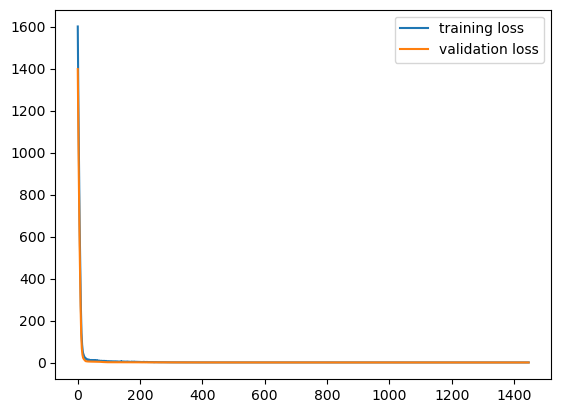

cd4
0
controls
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
hold out: P27
glioma
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
0
 Epoch: 0000 loss_train: 71.8518 loss_val: 52.2323 time: 0.0577s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 24.8587 loss_val: 21.1850 time: 0.0605s
 Epoch: 0020 loss_train: 14.5443 loss_val: 10.7107 time: 0.0962s
 Epoch: 0030 loss_train: 9.2444 loss_val: 5.5184 time: 0.0609s
 Epoch: 0040 loss_train: 5.8589 loss_val: 3.4902 time: 0.0577s
 Epoch: 0050 loss_train: 5.0939 loss_val: 2.5876 time: 0.0952s
 Epoch: 0060 loss_train: 3.5083 loss_val: 1.8717 time: 0.1197s
 Epoch: 0070 loss_train: 2.6556 loss_val: 1.4278 time: 0.0552s
 Epoch: 0080 loss_train: 2.2930 loss_val: 1.2085 time: 0.0925s
 Epoch: 0090 loss_train: 2.0469 loss_val: 1.0824 time: 0.0559s
 Epoch: 0100 loss_train: 1.6996 loss_val: 0.9997 time: 0.0557s
 Epoch: 0110 loss_train: 1.5494 loss_val: 0.9622 time: 0.1252s
 Epoch: 0120 loss_train: 1.4510 loss_val: 0.9390 time: 0.0582s
 Epoch: 0130 loss_train: 1.3181 loss_val: 0.9159 time: 0.0790s
 Epoch: 0140 loss_train: 1.3329 loss_val: 0.8982 time: 0.0635s
 Epoch: 0150 loss_train: 1.1790 loss_val: 0.8925 time: 0.0850s
 Epoch: 0160 loss_train: 1.1353 loss_val: 0.8797 ti

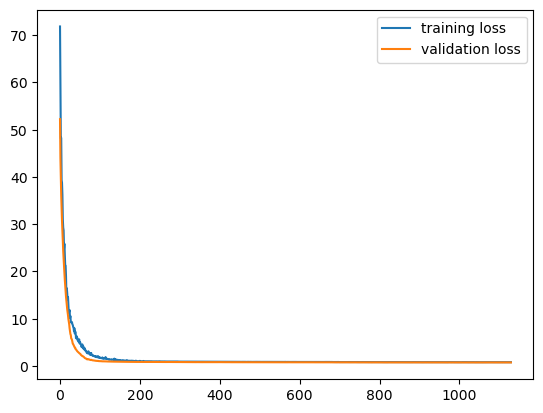

1
controls
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
hold out: P15
1
 Epoch: 0000 loss_train: 76.8496 loss_val: 53.8987 time: 0.0547s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 28.1366 loss_val: 19.6229 time: 0.0841s
 Epoch: 0020 loss_train: 14.4854 loss_val: 8.6302 time: 0.0667s
 Epoch: 0030 loss_train: 9.3637 loss_val: 4.8896 time: 0.0819s
 Epoch: 0040 loss_train: 6.1630 loss_val: 3.3674 time: 0.0559s
 Epoch: 0050 loss_train: 4.6996 loss_val: 2.6528 time: 0.1056s
 Epoch: 0060 loss_train: 3.6417 loss_val: 2.0558 time: 0.0547s
 Epoch: 0070 loss_train: 2.7569 loss_val: 1.4603 time: 0.0519s
 Epoch: 0080 loss_train: 2.2346 loss_val: 1.2795 time: 0.0640s
 Epoch: 0090 loss_train: 1.7535 loss_val: 1.1585 time: 0.1243s
 Epoch: 0100 loss_train: 1.5294 loss_val: 1.0698 time: 0.0547s
 Epoch: 0110 loss_train: 1.4556 loss_val: 1.0253 time: 0.0594s
 Epoch: 0120 loss_train: 1.2325 loss_val: 1.0011 time: 0.0570s
 Epoch: 0130 loss_train: 1.1802 loss_val: 0.9573 time: 0.0572s
 Epoch: 0140 loss_train: 1.0982 loss_val: 0.9284 time: 0.0744s
 Epoch: 0150 loss_train: 1.0681 loss_val: 0.9223 time: 0.0654s
 Epoch: 0160 loss_train: 1.0542 loss_val: 0.9195 tim

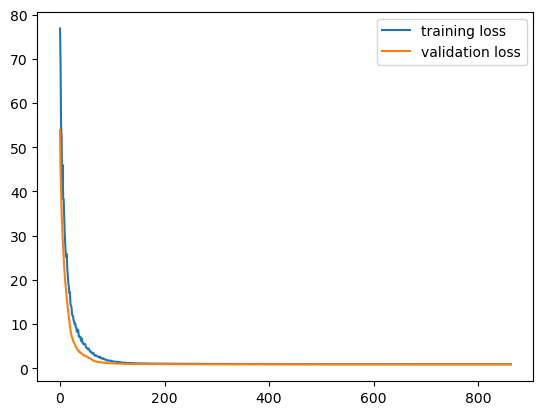

2
controls
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
2
 Epoch: 0000 loss_train: 81.7514 loss_val: 55.0512 time: 0.0610s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 25.8520 loss_val: 21.8025 time: 0.0551s
 Epoch: 0020 loss_train: 15.8863 loss_val: 10.3181 time: 0.0554s
 Epoch: 0030 loss_train: 9.3846 loss_val: 5.9213 time: 0.0590s
 Epoch: 0040 loss_train: 6.7631 loss_val: 3.8777 time: 0.0834s
 Epoch: 0050 loss_train: 5.0253 loss_val: 2.6663 time: 0.0855s
 Epoch: 0060 loss_train: 4.0237 loss_val: 2.0771 time: 0.0699s
 Epoch: 0070 loss_train: 3.2649 loss_val: 1.6171 time: 0.0599s
 Epoch: 0080 loss_train: 2.4685 loss_val: 1.2985 time: 0.0540s
 Epoch: 0090 loss_train: 1.9393 loss_val: 1.1206 time: 0.0531s
 Epoch: 0100 loss_train: 1.7294 loss_val: 1.0459 time: 0.0543s
 Epoch: 0110 loss_train: 1.5541 loss_val: 0.9970 time: 0.0960s
 Epoch: 0120 loss_train: 1.4473 loss_val: 0.9611 time: 0.0533s
 Epoch: 0130 loss_train: 1.2983 loss_val: 0.9281 time: 0.0559s
 Epoch: 0140 loss_train: 1.2377 loss_val: 0.9097 time: 0.0549s
 Epoch: 0150 loss_train: 1.1308 loss_val: 0.8626 time: 0.0587s
 Epoch: 0160 loss_train: 1.1178 loss_val: 0.8406 ti

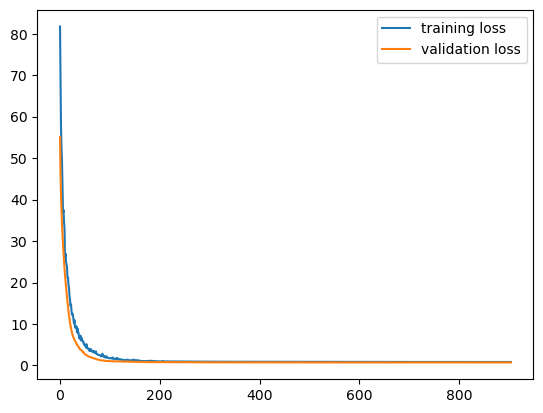

3
controls
dapi_cd8_cd4
HV1
HV8
hold out: HV6
HV7
hold out: HV4
HV5
HV3
HV2
headneck
dapi_cd16_cd4_cd8
P55
P56
P72
P14
hold out: P18
hold out: P41
P44
P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
P42
P48
hold out: P62
hold out: P38
P83
P37
P33
P70
P59
P27
glioma
dapi_cd16_cd4_cd8
P46
P47
P29
hold out: P52
P57
P22
P68
hold out: P16
P84
P15
3
 Epoch: 0000 loss_train: 85.9864 loss_val: 50.6556 time: 0.0626s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 29.9782 loss_val: 18.8466 time: 0.0870s
 Epoch: 0020 loss_train: 14.9677 loss_val: 9.6489 time: 0.0548s
 Epoch: 0030 loss_train: 9.5638 loss_val: 5.4919 time: 0.0977s
 Epoch: 0040 loss_train: 6.8686 loss_val: 3.7126 time: 0.0691s
 Epoch: 0050 loss_train: 4.6971 loss_val: 2.6223 time: 0.0637s
 Epoch: 0060 loss_train: 3.7075 loss_val: 2.0590 time: 0.0718s
 Epoch: 0070 loss_train: 2.9602 loss_val: 1.7025 time: 0.0881s
 Epoch: 0080 loss_train: 2.3340 loss_val: 1.3525 time: 0.0599s
 Epoch: 0090 loss_train: 2.0940 loss_val: 1.2335 time: 0.0560s
 Epoch: 0100 loss_train: 1.9324 loss_val: 1.1364 time: 0.0712s
 Epoch: 0110 loss_train: 1.6553 loss_val: 1.0824 time: 0.0673s
 Epoch: 0120 loss_train: 1.6900 loss_val: 1.0378 time: 0.0822s
 Epoch: 0130 loss_train: 1.3943 loss_val: 1.0079 time: 0.0659s
 Epoch: 0140 loss_train: 1.2652 loss_val: 0.9763 time: 0.1241s
 Epoch: 0150 loss_train: 1.2112 loss_val: 0.9631 time: 0.0565s
 Epoch: 0160 loss_train: 1.1551 loss_val: 0.9472 tim

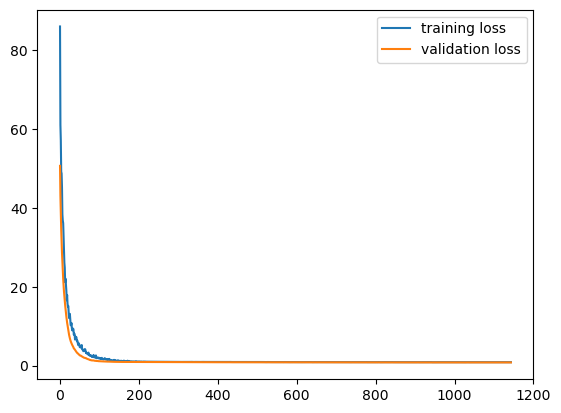

4
controls
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_cd16_cd4_cd8
P55
hold out: P56
P72
P14
P18
P41
P44
P63
hold out: P50
P24
meningioma
dapi_cd16_cd4_cd8
P42
hold out: P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
hold out: P84
P15
4
 Epoch: 0000 loss_train: 71.8775 loss_val: 55.0572 time: 0.0623s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 25.8317 loss_val: 22.5188 time: 0.0532s
 Epoch: 0020 loss_train: 12.9239 loss_val: 11.0612 time: 0.1103s
 Epoch: 0030 loss_train: 7.9437 loss_val: 6.1512 time: 0.0531s
 Epoch: 0040 loss_train: 6.8999 loss_val: 4.2310 time: 0.0573s
 Epoch: 0050 loss_train: 4.2874 loss_val: 2.7914 time: 0.0570s
 Epoch: 0060 loss_train: 3.7307 loss_val: 1.9955 time: 0.0672s
 Epoch: 0070 loss_train: 2.7271 loss_val: 1.4502 time: 0.0780s
 Epoch: 0080 loss_train: 2.1446 loss_val: 1.1740 time: 0.0758s
 Epoch: 0090 loss_train: 2.3456 loss_val: 1.0368 time: 0.0553s
 Epoch: 0100 loss_train: 1.6636 loss_val: 0.9885 time: 0.0633s
 Epoch: 0110 loss_train: 1.4560 loss_val: 0.9754 time: 0.0557s
 Epoch: 0120 loss_train: 1.4246 loss_val: 0.9536 time: 0.0550s
 Epoch: 0130 loss_train: 1.2895 loss_val: 0.9385 time: 0.0540s
 Epoch: 0140 loss_train: 1.1985 loss_val: 0.9295 time: 0.0563s
 Epoch: 0150 loss_train: 1.1300 loss_val: 0.9298 time: 0.0642s
 Epoch: 0160 loss_train: 1.3508 loss_val: 0.9133 ti

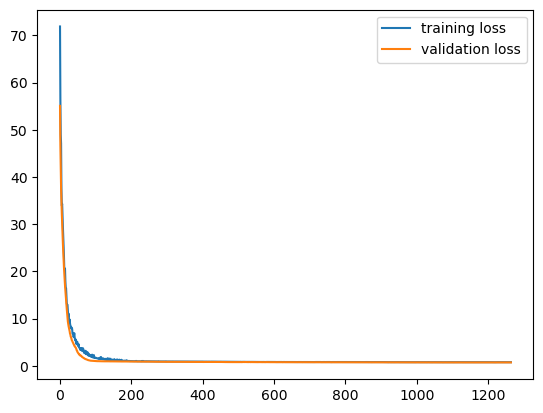

5
controls
dapi_cd8_cd4
HV1
HV8
HV6
HV7
hold out: HV4
HV5
hold out: HV3
HV2
headneck
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
5
 Epoch: 0000 loss_train: 77.2970 loss_val: 62.8925 time: 0.0655s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 29.4851 loss_val: 23.1964 time: 0.0650s
 Epoch: 0020 loss_train: 13.4347 loss_val: 10.6473 time: 0.0674s
 Epoch: 0030 loss_train: 9.4821 loss_val: 6.0785 time: 0.0737s
 Epoch: 0040 loss_train: 7.1872 loss_val: 4.1322 time: 0.0586s
 Epoch: 0050 loss_train: 5.0488 loss_val: 2.9299 time: 0.0534s
 Epoch: 0060 loss_train: 4.1855 loss_val: 2.1960 time: 0.0530s
 Epoch: 0070 loss_train: 2.8394 loss_val: 1.5361 time: 0.0522s
 Epoch: 0080 loss_train: 2.3990 loss_val: 1.2428 time: 0.0561s
 Epoch: 0090 loss_train: 2.5165 loss_val: 1.0962 time: 0.0556s
 Epoch: 0100 loss_train: 1.7515 loss_val: 1.0322 time: 0.0517s
 Epoch: 0110 loss_train: 1.7579 loss_val: 0.9990 time: 0.0574s
 Epoch: 0120 loss_train: 1.4874 loss_val: 0.9616 time: 0.0674s
 Epoch: 0130 loss_train: 1.3575 loss_val: 0.9352 time: 0.0764s
 Epoch: 0140 loss_train: 1.2329 loss_val: 0.9136 time: 0.0551s
 Epoch: 0150 loss_train: 1.3196 loss_val: 0.9054 time: 0.0538s
 Epoch: 0160 loss_train: 1.2376 loss_val: 0.8989 ti

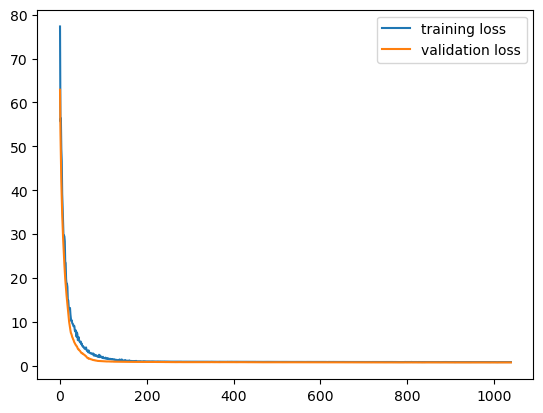

6
controls
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
hold out: P27
glioma
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
6
 Epoch: 0000 loss_train: 77.7707 loss_val: 56.4596 time: 0.1108s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 28.4186 loss_val: 21.2435 time: 0.0592s
 Epoch: 0020 loss_train: 11.9362 loss_val: 9.9643 time: 0.0824s
 Epoch: 0030 loss_train: 9.3731 loss_val: 5.0449 time: 0.1089s
 Epoch: 0040 loss_train: 7.3098 loss_val: 3.2801 time: 0.0551s
 Epoch: 0050 loss_train: 5.0928 loss_val: 2.5758 time: 0.0550s
 Epoch: 0060 loss_train: 3.6735 loss_val: 2.0245 time: 0.0629s
 Epoch: 0070 loss_train: 2.8799 loss_val: 1.5838 time: 0.1122s
 Epoch: 0080 loss_train: 2.3778 loss_val: 1.2088 time: 0.1749s
 Epoch: 0090 loss_train: 2.0700 loss_val: 1.0655 time: 0.1211s
 Epoch: 0100 loss_train: 1.8628 loss_val: 0.9874 time: 0.0966s
 Epoch: 0110 loss_train: 1.5506 loss_val: 0.9238 time: 0.0695s
 Epoch: 0120 loss_train: 1.5010 loss_val: 0.9106 time: 0.0584s
 Epoch: 0130 loss_train: 1.3481 loss_val: 0.8977 time: 0.0529s
 Epoch: 0140 loss_train: 1.2562 loss_val: 0.8779 time: 0.0537s
 Epoch: 0150 loss_train: 1.1659 loss_val: 0.8663 time: 0.1107s
 Epoch: 0160 loss_train: 1.1366 loss_val: 0.8596 tim

 Epoch: 1310 loss_train: 0.7870 loss_val: 0.7085 time: 0.0840s
 Epoch: 1320 loss_train: 0.7818 loss_val: 0.7055 time: 0.0508s
 Epoch: 1330 loss_train: 0.7809 loss_val: 0.7070 time: 0.0560s
 Epoch: 1340 loss_train: 0.7721 loss_val: 0.7059 time: 0.0541s
 Epoch: 1350 loss_train: 0.7751 loss_val: 0.7036 time: 0.1636s
 Epoch: 1360 loss_train: 0.7785 loss_val: 0.7072 time: 0.1299s
 Epoch: 1370 loss_train: 0.7762 loss_val: 0.7032 time: 0.0515s
 Epoch: 1380 loss_train: 0.7749 loss_val: 0.7031 time: 0.0494s
 total time: 118.4472s


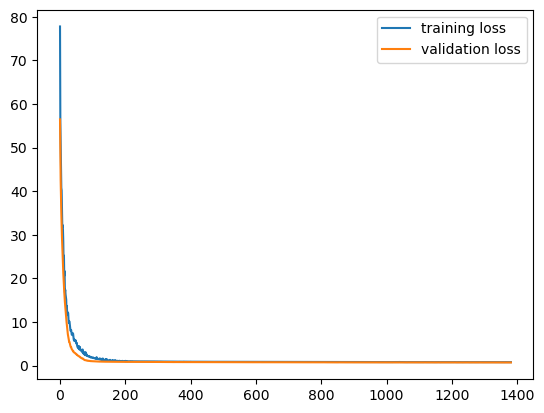

7
controls
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
hold out: P15
7
 Epoch: 0000 loss_train: 77.8215 loss_val: 55.0825 time: 0.0686s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 29.1761 loss_val: 21.7157 time: 0.1007s
 Epoch: 0020 loss_train: 15.5405 loss_val: 10.3075 time: 0.1171s
 Epoch: 0030 loss_train: 8.7155 loss_val: 4.9899 time: 0.0523s
 Epoch: 0040 loss_train: 6.8648 loss_val: 3.5665 time: 0.0540s
 Epoch: 0050 loss_train: 4.6587 loss_val: 2.7001 time: 0.0546s
 Epoch: 0060 loss_train: 3.4060 loss_val: 2.0259 time: 0.0578s
 Epoch: 0070 loss_train: 2.6580 loss_val: 1.6364 time: 0.2132s
 Epoch: 0080 loss_train: 2.0445 loss_val: 1.3391 time: 0.0508s
 Epoch: 0090 loss_train: 1.7443 loss_val: 1.1913 time: 0.0574s
 Epoch: 0100 loss_train: 1.5203 loss_val: 1.1109 time: 0.0565s
 Epoch: 0110 loss_train: 1.3881 loss_val: 1.0654 time: 0.1455s
 Epoch: 0120 loss_train: 1.2822 loss_val: 1.0136 time: 0.1004s
 Epoch: 0130 loss_train: 1.1612 loss_val: 0.9939 time: 0.0535s
 Epoch: 0140 loss_train: 1.1139 loss_val: 0.9731 time: 0.0588s
 Epoch: 0150 loss_train: 1.0811 loss_val: 0.9736 time: 0.0688s
 Epoch: 0160 loss_train: 1.0464 loss_val: 0.9487 ti

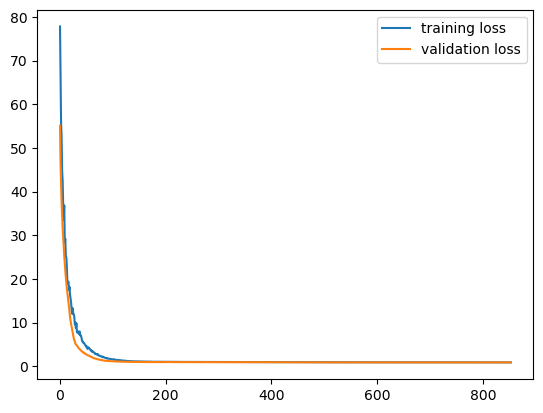

8
controls
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
8
 Epoch: 0000 loss_train: 88.1948 loss_val: 51.7652 time: 0.0550s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 31.4467 loss_val: 20.0013 time: 0.0601s
 Epoch: 0020 loss_train: 15.9849 loss_val: 9.9202 time: 0.0554s
 Epoch: 0030 loss_train: 10.6741 loss_val: 5.9847 time: 0.0526s
 Epoch: 0040 loss_train: 7.0898 loss_val: 4.1398 time: 0.0571s
 Epoch: 0050 loss_train: 5.5383 loss_val: 2.6876 time: 0.0620s
 Epoch: 0060 loss_train: 4.0116 loss_val: 1.9909 time: 0.0535s
 Epoch: 0070 loss_train: 2.9582 loss_val: 1.6618 time: 0.0518s
 Epoch: 0080 loss_train: 2.3643 loss_val: 1.3864 time: 0.0539s
 Epoch: 0090 loss_train: 2.0158 loss_val: 1.2753 time: 0.0529s
 Epoch: 0100 loss_train: 1.6286 loss_val: 1.1598 time: 0.0718s
 Epoch: 0110 loss_train: 1.4210 loss_val: 1.1583 time: 0.0718s
 Epoch: 0120 loss_train: 1.2350 loss_val: 1.0563 time: 0.0609s
 Epoch: 0130 loss_train: 1.1461 loss_val: 0.9846 time: 0.0603s
 Epoch: 0140 loss_train: 1.1046 loss_val: 1.0175 time: 0.0549s
 Epoch: 0150 loss_train: 1.0687 loss_val: 0.9375 time: 0.0557s
 Epoch: 0160 loss_train: 0.9770 loss_val: 0.9431 ti

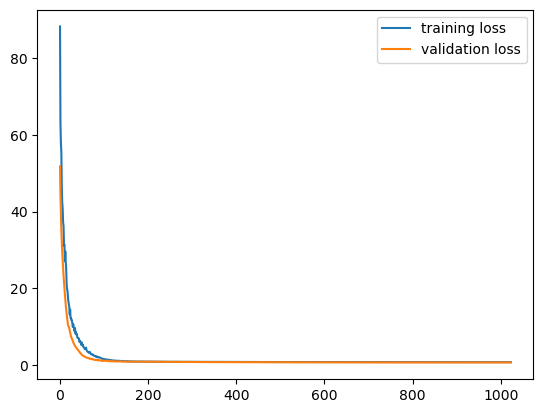

9
controls
dapi_cd8_cd4
HV1
HV8
hold out: HV6
HV7
hold out: HV4
HV5
HV3
HV2
headneck
dapi_cd16_cd4_cd8
P55
P56
P72
P14
hold out: P18
hold out: P41
P44
P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
P42
P48
hold out: P62
hold out: P38
P83
P37
P33
P70
P59
P27
glioma
dapi_cd16_cd4_cd8
P46
P47
P29
hold out: P52
P57
P22
P68
hold out: P16
P84
P15
9
 Epoch: 0000 loss_train: 75.8747 loss_val: 59.7098 time: 0.1426s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 28.6236 loss_val: 24.6719 time: 0.0554s
 Epoch: 0020 loss_train: 14.3972 loss_val: 12.5152 time: 0.0848s
 Epoch: 0030 loss_train: 9.9276 loss_val: 6.7809 time: 0.0854s
 Epoch: 0040 loss_train: 6.5818 loss_val: 4.3656 time: 0.0646s
 Epoch: 0050 loss_train: 5.0194 loss_val: 2.9581 time: 0.0813s
 Epoch: 0060 loss_train: 3.8729 loss_val: 2.2606 time: 0.0566s
 Epoch: 0070 loss_train: 2.9441 loss_val: 1.7748 time: 0.0958s
 Epoch: 0080 loss_train: 2.3873 loss_val: 1.4514 time: 0.0767s
 Epoch: 0090 loss_train: 2.4396 loss_val: 1.3141 time: 0.0646s
 Epoch: 0100 loss_train: 1.8086 loss_val: 1.1869 time: 0.1666s
 Epoch: 0110 loss_train: 1.6147 loss_val: 1.1282 time: 0.0564s
 Epoch: 0120 loss_train: 1.4494 loss_val: 1.0674 time: 0.1871s
 Epoch: 0130 loss_train: 1.3391 loss_val: 1.0431 time: 0.1187s
 Epoch: 0140 loss_train: 1.2701 loss_val: 1.0111 time: 0.0895s
 Epoch: 0150 loss_train: 1.1986 loss_val: 0.9992 time: 0.0557s
 Epoch: 0160 loss_train: 1.1394 loss_val: 0.9871 ti

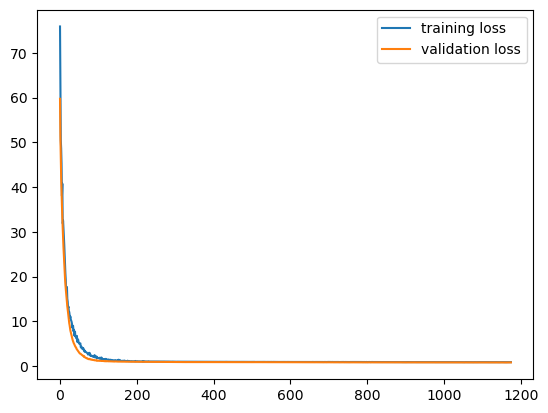

10
controls
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_cd16_cd4_cd8
P55
hold out: P56
P72
P14
P18
P41
P44
P63
hold out: P50
P24
meningioma
dapi_cd16_cd4_cd8
P42
hold out: P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
hold out: P84
P15
10
 Epoch: 0000 loss_train: 76.6711 loss_val: 48.2799 time: 0.1001s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 27.3394 loss_val: 17.4470 time: 0.0531s
 Epoch: 0020 loss_train: 13.9921 loss_val: 7.4786 time: 0.0521s
 Epoch: 0030 loss_train: 9.7274 loss_val: 4.5398 time: 0.0566s
 Epoch: 0040 loss_train: 7.1831 loss_val: 3.3366 time: 0.1394s
 Epoch: 0050 loss_train: 4.5532 loss_val: 2.3137 time: 0.1328s
 Epoch: 0060 loss_train: 3.8848 loss_val: 1.7856 time: 0.0766s
 Epoch: 0070 loss_train: 2.7893 loss_val: 1.3823 time: 0.0564s
 Epoch: 0080 loss_train: 2.2815 loss_val: 1.1092 time: 0.0831s
 Epoch: 0090 loss_train: 1.8865 loss_val: 0.9415 time: 0.0922s
 Epoch: 0100 loss_train: 1.6927 loss_val: 0.8989 time: 0.0761s
 Epoch: 0110 loss_train: 1.7195 loss_val: 0.8828 time: 0.0747s
 Epoch: 0120 loss_train: 1.3921 loss_val: 0.8549 time: 0.1185s
 Epoch: 0130 loss_train: 1.3033 loss_val: 0.8357 time: 0.0861s
 Epoch: 0140 loss_train: 1.1986 loss_val: 0.8253 time: 0.0550s
 Epoch: 0150 loss_train: 1.2471 loss_val: 0.8154 time: 0.0582s
 Epoch: 0160 loss_train: 1.0989 loss_val: 0.8198 tim

 Epoch: 1310 loss_train: 0.7404 loss_val: 0.6698 time: 0.1333s
 total time: 90.5193s


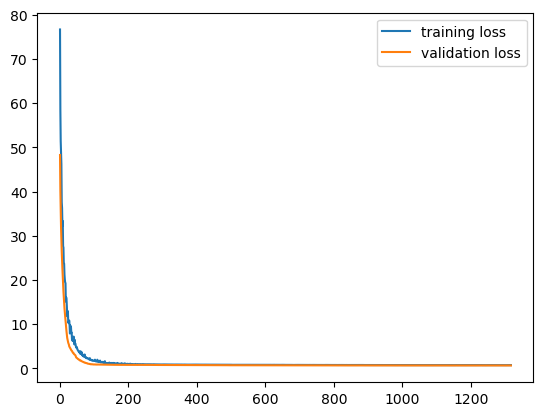

11
controls
dapi_cd8_cd4
HV1
HV8
HV6
HV7
hold out: HV4
HV5
hold out: HV3
HV2
headneck
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
11
 Epoch: 0000 loss_train: 80.0211 loss_val: 58.8551 time: 0.0853s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 27.2031 loss_val: 22.5281 time: 0.0631s
 Epoch: 0020 loss_train: 13.8394 loss_val: 10.9802 time: 0.1033s
 Epoch: 0030 loss_train: 9.7211 loss_val: 6.1197 time: 0.0536s
 Epoch: 0040 loss_train: 7.2329 loss_val: 4.1792 time: 0.1332s
 Epoch: 0050 loss_train: 4.7657 loss_val: 2.7882 time: 0.1067s
 Epoch: 0060 loss_train: 3.8288 loss_val: 2.1356 time: 0.0608s
 Epoch: 0070 loss_train: 2.9221 loss_val: 1.6568 time: 0.1272s
 Epoch: 0080 loss_train: 2.2351 loss_val: 1.3406 time: 0.0957s
 Epoch: 0090 loss_train: 1.9154 loss_val: 1.1209 time: 0.0542s
 Epoch: 0100 loss_train: 1.5953 loss_val: 1.0400 time: 0.1160s
 Epoch: 0110 loss_train: 1.3961 loss_val: 1.0497 time: 0.0511s
 Epoch: 0120 loss_train: 1.2588 loss_val: 1.0077 time: 0.1334s
 Epoch: 0130 loss_train: 1.1699 loss_val: 0.9592 time: 0.0524s
 Epoch: 0140 loss_train: 1.0909 loss_val: 0.9110 time: 0.0524s
 Epoch: 0150 loss_train: 1.0726 loss_val: 0.8977 time: 0.0551s
 Epoch: 0160 loss_train: 1.0371 loss_val: 0.9035 ti

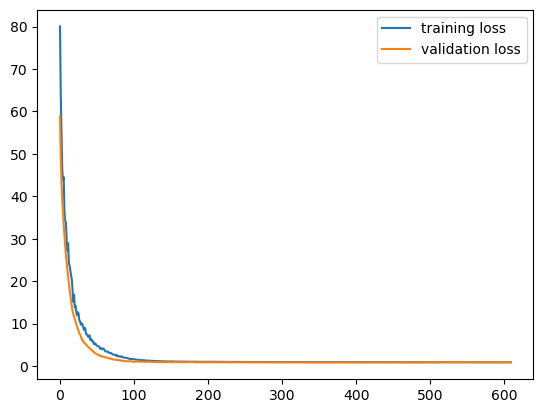

12
controls
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
hold out: P27
glioma
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
12
 Epoch: 0000 loss_train: 73.7856 loss_val: 43.6611 time: 0.1584s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 27.8925 loss_val: 15.7469 time: 0.0532s
 Epoch: 0020 loss_train: 16.3481 loss_val: 7.8220 time: 0.1352s
 Epoch: 0030 loss_train: 8.8525 loss_val: 4.0777 time: 0.0525s
 Epoch: 0040 loss_train: 6.1057 loss_val: 2.8462 time: 0.0548s
 Epoch: 0050 loss_train: 4.7041 loss_val: 2.2311 time: 0.1358s
 Epoch: 0060 loss_train: 3.5400 loss_val: 1.8384 time: 0.0545s
 Epoch: 0070 loss_train: 3.0436 loss_val: 1.3881 time: 0.1029s
 Epoch: 0080 loss_train: 2.2398 loss_val: 1.2227 time: 0.1341s
 Epoch: 0090 loss_train: 1.9191 loss_val: 1.0843 time: 0.0619s
 Epoch: 0100 loss_train: 1.7329 loss_val: 1.0332 time: 0.1681s
 Epoch: 0110 loss_train: 1.5663 loss_val: 0.9901 time: 0.0596s
 Epoch: 0120 loss_train: 1.4450 loss_val: 0.9453 time: 0.1832s
 Epoch: 0130 loss_train: 1.3266 loss_val: 0.9206 time: 0.0756s
 Epoch: 0140 loss_train: 1.2452 loss_val: 0.9113 time: 0.0600s
 Epoch: 0150 loss_train: 1.1775 loss_val: 0.8893 time: 0.1202s
 Epoch: 0160 loss_train: 1.1512 loss_val: 0.8783 tim

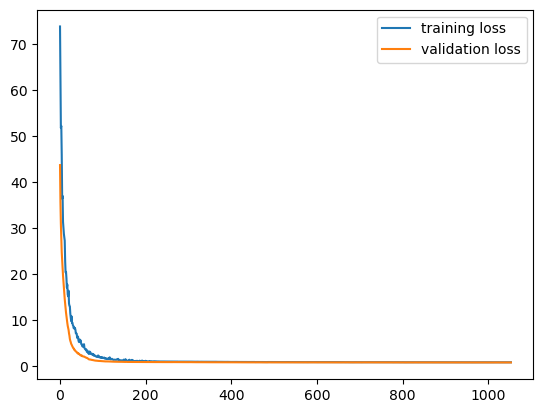

13
controls
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
hold out: P15
13
 Epoch: 0000 loss_train: 73.9712 loss_val: 56.6985 time: 0.0587s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.7484 loss_val: 22.4824 time: 0.0508s
 Epoch: 0020 loss_train: 13.5596 loss_val: 9.9894 time: 0.1283s
 Epoch: 0030 loss_train: 8.6847 loss_val: 5.4100 time: 0.1403s
 Epoch: 0040 loss_train: 6.5682 loss_val: 3.3480 time: 0.1381s
 Epoch: 0050 loss_train: 5.0004 loss_val: 2.5447 time: 0.1340s
 Epoch: 0060 loss_train: 3.3686 loss_val: 1.8206 time: 0.1331s
 Epoch: 0070 loss_train: 2.8550 loss_val: 1.3911 time: 0.0846s
 Epoch: 0080 loss_train: 2.1692 loss_val: 1.1821 time: 0.0725s
 Epoch: 0090 loss_train: 1.8029 loss_val: 1.0507 time: 0.1075s
 Epoch: 0100 loss_train: 1.5778 loss_val: 0.9943 time: 0.0910s
 Epoch: 0110 loss_train: 1.3655 loss_val: 0.9546 time: 0.1018s
 Epoch: 0120 loss_train: 1.2465 loss_val: 0.9318 time: 0.0651s
 Epoch: 0130 loss_train: 1.1775 loss_val: 0.9181 time: 0.0546s
 Epoch: 0140 loss_train: 1.1201 loss_val: 0.9094 time: 0.0585s
 Epoch: 0150 loss_train: 1.0887 loss_val: 0.8944 time: 0.0633s
 Epoch: 0160 loss_train: 1.0496 loss_val: 0.8956 tim

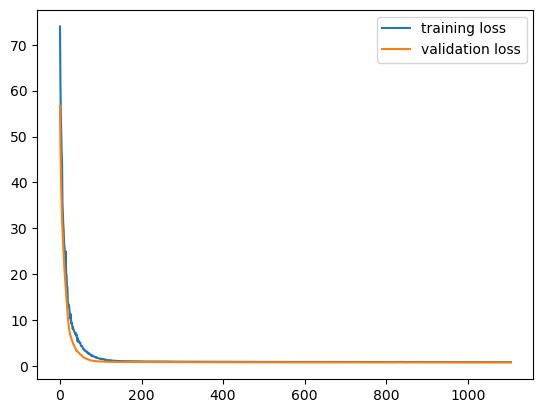

14
controls
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
14
 Epoch: 0000 loss_train: 83.5789 loss_val: 56.8319 time: 0.0645s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 31.4922 loss_val: 23.5331 time: 0.1268s
 Epoch: 0020 loss_train: 16.8055 loss_val: 11.3056 time: 0.1197s
 Epoch: 0030 loss_train: 8.8322 loss_val: 5.9394 time: 0.0624s
 Epoch: 0040 loss_train: 7.0061 loss_val: 3.9608 time: 0.1390s
 Epoch: 0050 loss_train: 5.3571 loss_val: 2.7661 time: 0.0553s
 Epoch: 0060 loss_train: 3.9150 loss_val: 1.9831 time: 0.0657s
 Epoch: 0070 loss_train: 3.0400 loss_val: 1.5304 time: 0.1156s
 Epoch: 0080 loss_train: 2.7461 loss_val: 1.2752 time: 0.0559s
 Epoch: 0090 loss_train: 2.1793 loss_val: 1.0982 time: 0.0595s
 Epoch: 0100 loss_train: 2.1623 loss_val: 1.0495 time: 0.1390s
 Epoch: 0110 loss_train: 2.1170 loss_val: 0.9901 time: 0.0931s
 Epoch: 0120 loss_train: 1.5927 loss_val: 0.9491 time: 0.0541s
 Epoch: 0130 loss_train: 1.3436 loss_val: 0.9123 time: 0.1770s
 Epoch: 0140 loss_train: 1.5077 loss_val: 0.9099 time: 0.1444s
 Epoch: 0150 loss_train: 1.2070 loss_val: 0.8786 time: 0.0524s
 Epoch: 0160 loss_train: 1.0990 loss_val: 0.8334 ti

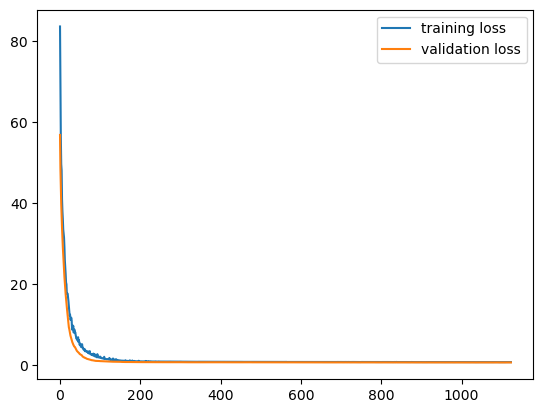

15
controls
dapi_cd8_cd4
HV1
HV8
hold out: HV6
HV7
hold out: HV4
HV5
HV3
HV2
headneck
dapi_cd16_cd4_cd8
P55
P56
P72
P14
hold out: P18
hold out: P41
P44
P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
P42
P48
hold out: P62
hold out: P38
P83
P37
P33
P70
P59
P27
glioma
dapi_cd16_cd4_cd8
P46
P47
P29
hold out: P52
P57
P22
P68
hold out: P16
P84
P15
15
 Epoch: 0000 loss_train: 79.3092 loss_val: 58.9919 time: 0.0506s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 30.5683 loss_val: 23.2149 time: 0.1310s
 Epoch: 0020 loss_train: 15.9006 loss_val: 11.2012 time: 0.1161s
 Epoch: 0030 loss_train: 10.1871 loss_val: 6.0853 time: 0.0542s
 Epoch: 0040 loss_train: 7.8828 loss_val: 4.3507 time: 0.0746s
 Epoch: 0050 loss_train: 5.2496 loss_val: 3.0730 time: 0.0873s
 Epoch: 0060 loss_train: 3.8326 loss_val: 2.3386 time: 0.0570s
 Epoch: 0070 loss_train: 3.0005 loss_val: 1.7534 time: 0.0658s
 Epoch: 0080 loss_train: 2.4173 loss_val: 1.3383 time: 0.0670s
 Epoch: 0090 loss_train: 2.4783 loss_val: 1.1541 time: 0.0544s
 Epoch: 0100 loss_train: 1.7640 loss_val: 1.0775 time: 0.1309s
 Epoch: 0110 loss_train: 1.5322 loss_val: 1.0403 time: 0.0872s
 Epoch: 0120 loss_train: 1.6515 loss_val: 1.0079 time: 0.0493s
 Epoch: 0130 loss_train: 1.6637 loss_val: 0.9907 time: 0.0648s
 Epoch: 0140 loss_train: 1.3196 loss_val: 0.9811 time: 0.0775s
 Epoch: 0150 loss_train: 1.2106 loss_val: 0.9636 time: 0.0745s
 Epoch: 0160 loss_train: 1.1439 loss_val: 0.9527 t

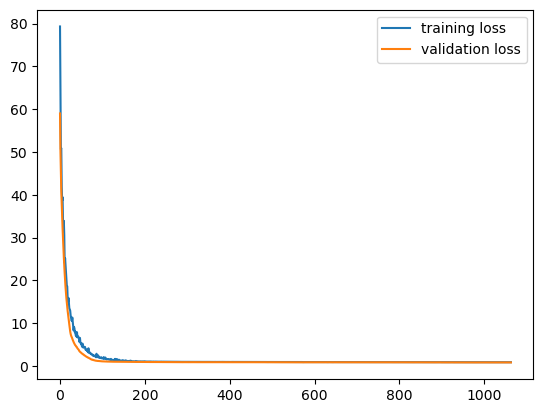

16
controls
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_cd16_cd4_cd8
P55
hold out: P56
P72
P14
P18
P41
P44
P63
hold out: P50
P24
meningioma
dapi_cd16_cd4_cd8
P42
hold out: P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
hold out: P84
P15
16
 Epoch: 0000 loss_train: 73.8397 loss_val: 49.3763 time: 0.0656s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.0547 loss_val: 18.6728 time: 0.0720s
 Epoch: 0020 loss_train: 13.1685 loss_val: 8.6925 time: 0.0533s
 Epoch: 0030 loss_train: 8.1657 loss_val: 4.9121 time: 0.0535s
 Epoch: 0040 loss_train: 5.8706 loss_val: 3.5495 time: 0.0603s
 Epoch: 0050 loss_train: 4.4031 loss_val: 2.4623 time: 0.0556s
 Epoch: 0060 loss_train: 3.3066 loss_val: 1.6642 time: 0.0556s
 Epoch: 0070 loss_train: 2.7923 loss_val: 1.3406 time: 0.0633s
 Epoch: 0080 loss_train: 2.2498 loss_val: 1.1397 time: 0.0539s
 Epoch: 0090 loss_train: 1.9090 loss_val: 1.0142 time: 0.0599s
 Epoch: 0100 loss_train: 1.9134 loss_val: 0.9346 time: 0.0671s
 Epoch: 0110 loss_train: 1.5526 loss_val: 0.9031 time: 0.0671s
 Epoch: 0120 loss_train: 1.3750 loss_val: 0.8784 time: 0.0687s
 Epoch: 0130 loss_train: 1.6651 loss_val: 0.8611 time: 0.0596s
 Epoch: 0140 loss_train: 1.2173 loss_val: 0.8397 time: 0.0661s
 Epoch: 0150 loss_train: 1.1242 loss_val: 0.8269 time: 0.0529s
 Epoch: 0160 loss_train: 1.1285 loss_val: 0.8258 tim

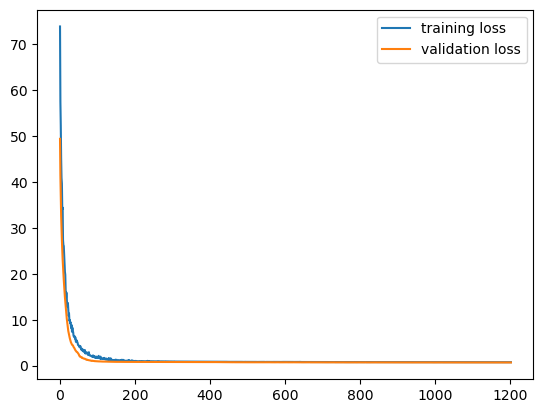

17
controls
dapi_cd8_cd4
HV1
HV8
HV6
HV7
hold out: HV4
HV5
hold out: HV3
HV2
headneck
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
17
 Epoch: 0000 loss_train: 79.6844 loss_val: 60.8848 time: 0.0745s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 27.1103 loss_val: 25.6757 time: 0.0531s
 Epoch: 0020 loss_train: 14.1892 loss_val: 12.8179 time: 0.1624s
 Epoch: 0030 loss_train: 9.1100 loss_val: 6.9059 time: 0.0556s
 Epoch: 0040 loss_train: 6.9188 loss_val: 4.7694 time: 0.0685s
 Epoch: 0050 loss_train: 5.5669 loss_val: 3.4335 time: 0.0511s
 Epoch: 0060 loss_train: 3.8256 loss_val: 2.4170 time: 0.1856s
 Epoch: 0070 loss_train: 3.2560 loss_val: 1.7470 time: 0.0604s
 Epoch: 0080 loss_train: 2.3757 loss_val: 1.3442 time: 0.0542s
 Epoch: 0090 loss_train: 1.9910 loss_val: 1.1549 time: 0.1389s
 Epoch: 0100 loss_train: 1.7439 loss_val: 1.0743 time: 0.0655s
 Epoch: 0110 loss_train: 1.5800 loss_val: 1.0014 time: 0.0589s
 Epoch: 0120 loss_train: 1.5270 loss_val: 0.9725 time: 0.0584s


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 Epoch: 0430 loss_train: 0.9286 loss_val: 0.8298 time: 0.0491s
 Epoch: 0440 loss_train: 0.9163 loss_val: 0.8240 time: 0.0470s
 Epoch: 0450 loss_train: 0.9081 loss_val: 0.8167 time: 0.0649s
 Epoch: 0460 loss_train: 0.9033 loss_val: 0.8246 time: 0.1360s
 Epoch: 0470 loss_train: 0.9038 loss_val: 0.8130 time: 0.1161s
 Epoch: 0480 loss_train: 0.9060 loss_val: 0.8073 time: 0.1012s
 Epoch: 0490 loss_train: 0.8999 loss_val: 0.8024 time: 0.0992s
 Epoch: 0500 loss_train: 0.9043 loss_val: 0.8035 time: 0.0733s
 Epoch: 0510 loss_train: 0.9037 loss_val: 0.8023 time: 0.1137s
 Epoch: 0520 loss_train: 0.8994 loss_val: 0.8069 time: 0.1152s
 Epoch: 0530 loss_train: 0.8930 loss_val: 0.7984 time: 0.0676s
 Epoch: 0540 loss_train: 0.8907 loss_val: 0.7971 time: 0.0870s
 Epoch: 0550 loss_train: 0.8929 loss_val: 0.7989 time: 0.1066s
 Epoch: 0560 loss_train: 0.8920 loss_val: 0.7949 time: 0.0489s
 Epoch: 0570 loss_train: 0.8829 loss_val: 0.7953 time: 0.1198s
 Epoch: 0580 loss_train: 0.8915 loss_val: 0.7976 time: 

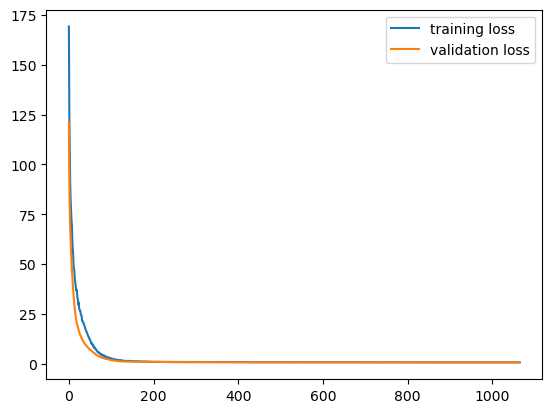

12
controls
headneck
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
hold out: P27
glioma
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
12
 Epoch: 0000 loss_train: 177.6849 loss_val: 136.0751 time: 0.0555s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 56.1991 loss_val: 41.1658 time: 0.0471s
 Epoch: 0020 loss_train: 34.8006 loss_val: 21.7033 time: 0.0776s
 Epoch: 0030 loss_train: 24.4354 loss_val: 13.7874 time: 0.0518s
 Epoch: 0040 loss_train: 16.9335 loss_val: 9.1914 time: 0.0476s
 Epoch: 0050 loss_train: 12.7251 loss_val: 6.1762 time: 0.0522s
 Epoch: 0060 loss_train: 9.0575 loss_val: 4.2578 time: 0.0618s
 Epoch: 0070 loss_train: 6.3329 loss_val: 2.9712 time: 0.1034s
 Epoch: 0080 loss_train: 4.4222 loss_val: 2.4269 time: 0.1059s
 Epoch: 0090 loss_train: 3.8475 loss_val: 1.9343 time: 0.0834s
 Epoch: 0100 loss_train: 2.9207 loss_val: 1.5620 time: 0.1262s
 Epoch: 0110 loss_train: 2.1135 loss_val: 1.2995 time: 0.1466s
 Epoch: 0120 loss_train: 1.8025 loss_val: 1.2145 time: 0.2067s
 Epoch: 0130 loss_train: 1.4936 loss_val: 1.0917 time: 0.1116s
 Epoch: 0140 loss_train: 1.1867 loss_val: 1.0838 time: 0.0892s
 Epoch: 0150 loss_train: 1.1511 loss_val: 1.0413 time: 0.1399s
 Epoch: 0160 loss_train: 1.2690 loss_val: 0.998

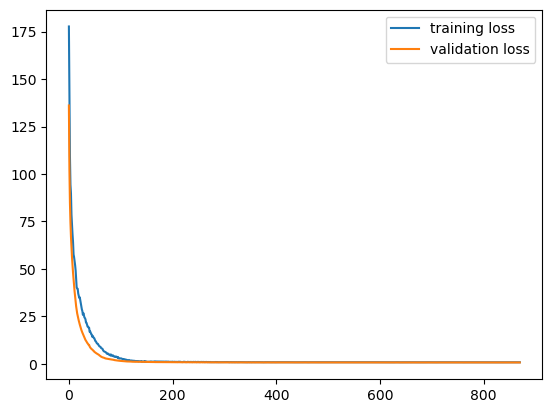

13
controls
headneck
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
hold out: P15
13
 Epoch: 0000 loss_train: 158.8253 loss_val: 113.5225 time: 0.0699s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 55.0119 loss_val: 34.6907 time: 0.0601s
 Epoch: 0020 loss_train: 33.8495 loss_val: 18.0202 time: 0.0672s
 Epoch: 0030 loss_train: 22.8704 loss_val: 12.3994 time: 0.0532s
 Epoch: 0040 loss_train: 16.0249 loss_val: 9.1900 time: 0.0482s
 Epoch: 0050 loss_train: 11.1859 loss_val: 6.9983 time: 0.0492s
 Epoch: 0060 loss_train: 7.9236 loss_val: 5.4105 time: 0.0475s
 Epoch: 0070 loss_train: 5.3578 loss_val: 4.0033 time: 0.0475s
 Epoch: 0080 loss_train: 3.8676 loss_val: 3.1116 time: 0.0484s
 Epoch: 0090 loss_train: 3.2368 loss_val: 2.4987 time: 0.0463s
 Epoch: 0100 loss_train: 2.4177 loss_val: 1.9348 time: 0.0551s
 Epoch: 0110 loss_train: 2.0067 loss_val: 1.5110 time: 0.0596s
 Epoch: 0120 loss_train: 1.6506 loss_val: 1.3096 time: 0.0517s
 Epoch: 0130 loss_train: 1.4793 loss_val: 1.2233 time: 0.0490s
 Epoch: 0140 loss_train: 1.3100 loss_val: 1.1697 time: 0.0500s
 Epoch: 0150 loss_train: 1.2335 loss_val: 1.1242 time: 0.0642s
 Epoch: 0160 loss_train: 1.1467 loss_val: 1.038

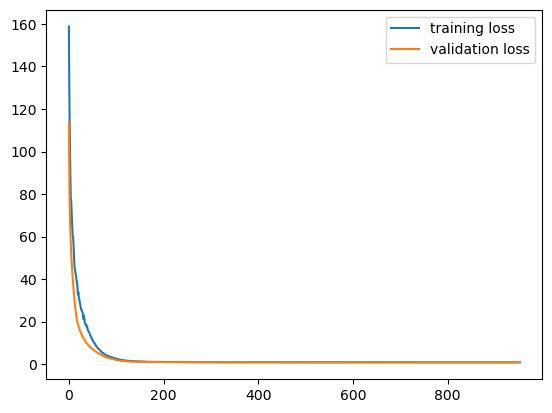

14
controls
headneck
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
14
 Epoch: 0000 loss_train: 164.6297 loss_val: 129.5540 time: 0.1116s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 54.1686 loss_val: 38.7482 time: 0.0493s
 Epoch: 0020 loss_train: 32.2326 loss_val: 19.1226 time: 0.0468s
 Epoch: 0030 loss_train: 23.3871 loss_val: 12.3859 time: 0.0507s
 Epoch: 0040 loss_train: 16.2263 loss_val: 8.8593 time: 0.0604s
 Epoch: 0050 loss_train: 12.4555 loss_val: 6.5314 time: 0.0605s
 Epoch: 0060 loss_train: 8.2135 loss_val: 4.6607 time: 0.0466s
 Epoch: 0070 loss_train: 5.5273 loss_val: 3.0443 time: 0.0521s
 Epoch: 0080 loss_train: 4.1058 loss_val: 2.3203 time: 0.0550s
 Epoch: 0090 loss_train: 3.1405 loss_val: 1.7613 time: 0.0570s
 Epoch: 0100 loss_train: 2.3683 loss_val: 1.3611 time: 0.1030s
 Epoch: 0110 loss_train: 2.0833 loss_val: 1.0580 time: 0.0555s
 Epoch: 0120 loss_train: 1.6954 loss_val: 0.9818 time: 0.0525s
 Epoch: 0130 loss_train: 1.4017 loss_val: 0.9677 time: 0.0478s
 Epoch: 0140 loss_train: 1.3295 loss_val: 0.9110 time: 0.0665s
 Epoch: 0150 loss_train: 1.1740 loss_val: 0.8800 time: 0.0780s
 Epoch: 0160 loss_train: 1.1857 loss_val: 0.886

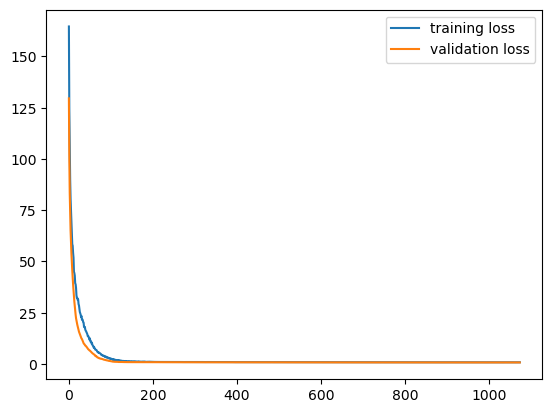

15
controls
headneck
dapi_cd16_cd4_cd8
P55
P56
P72
P14
hold out: P18
hold out: P41
P44
P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
P42
P48
hold out: P62
hold out: P38
P83
P37
P33
P70
P59
P27
glioma
dapi_cd16_cd4_cd8
P46
P47
P29
hold out: P52
P57
P22
P68
hold out: P16
P84
P15
15
 Epoch: 0000 loss_train: 166.9505 loss_val: 121.3263 time: 0.1608s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 54.9994 loss_val: 36.0401 time: 0.0779s
 Epoch: 0020 loss_train: 33.0853 loss_val: 18.0088 time: 0.1276s
 Epoch: 0030 loss_train: 23.1720 loss_val: 11.9023 time: 0.0930s
 Epoch: 0040 loss_train: 17.3783 loss_val: 8.7884 time: 0.1852s
 Epoch: 0050 loss_train: 12.3297 loss_val: 6.7957 time: 0.1079s
 Epoch: 0060 loss_train: 8.6768 loss_val: 5.2791 time: 0.0577s
 Epoch: 0070 loss_train: 6.4359 loss_val: 3.7872 time: 0.0749s
 Epoch: 0080 loss_train: 4.4289 loss_val: 2.9506 time: 0.0685s
 Epoch: 0090 loss_train: 3.8257 loss_val: 2.4394 time: 0.1003s
 Epoch: 0100 loss_train: 3.1510 loss_val: 1.9193 time: 0.0551s
 Epoch: 0110 loss_train: 2.2998 loss_val: 1.5901 time: 0.1388s
 Epoch: 0120 loss_train: 1.9480 loss_val: 1.3848 time: 0.0467s
 Epoch: 0130 loss_train: 1.7497 loss_val: 1.2494 time: 0.0735s
 Epoch: 0140 loss_train: 1.5848 loss_val: 1.1886 time: 0.0453s
 Epoch: 0150 loss_train: 1.4596 loss_val: 1.1299 time: 0.0486s
 Epoch: 0160 loss_train: 1.3389 loss_val: 1.066

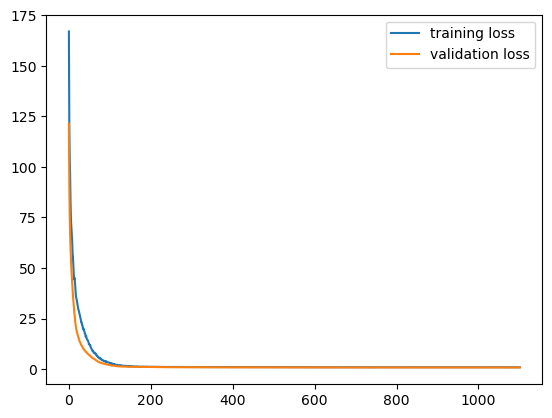

16
controls
headneck
dapi_cd16_cd4_cd8
P55
hold out: P56
P72
P14
P18
P41
P44
P63
hold out: P50
P24
meningioma
dapi_cd16_cd4_cd8
P42
hold out: P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
hold out: P84
P15
16
 Epoch: 0000 loss_train: 182.8589 loss_val: 134.0922 time: 0.0521s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 58.6790 loss_val: 41.0731 time: 0.0681s
 Epoch: 0020 loss_train: 34.5848 loss_val: 21.2859 time: 0.0996s
 Epoch: 0030 loss_train: 23.1125 loss_val: 13.4231 time: 0.0628s
 Epoch: 0040 loss_train: 17.4294 loss_val: 9.3505 time: 0.0505s
 Epoch: 0050 loss_train: 12.1083 loss_val: 6.2945 time: 0.1073s
 Epoch: 0060 loss_train: 8.8154 loss_val: 4.2331 time: 0.0574s
 Epoch: 0070 loss_train: 5.6823 loss_val: 3.0548 time: 0.0570s
 Epoch: 0080 loss_train: 4.4297 loss_val: 2.3837 time: 0.1111s
 Epoch: 0090 loss_train: 3.2528 loss_val: 1.8620 time: 0.0504s
 Epoch: 0100 loss_train: 2.4069 loss_val: 1.4942 time: 0.0549s
 Epoch: 0110 loss_train: 1.8140 loss_val: 1.2213 time: 0.0958s
 Epoch: 0120 loss_train: 1.6763 loss_val: 1.1368 time: 0.0975s
 Epoch: 0130 loss_train: 1.3506 loss_val: 1.0925 time: 0.0621s
 Epoch: 0140 loss_train: 1.4178 loss_val: 1.0474 time: 0.0686s
 Epoch: 0150 loss_train: 1.1442 loss_val: 1.0432 time: 0.0651s
 Epoch: 0160 loss_train: 1.1272 loss_val: 1.018

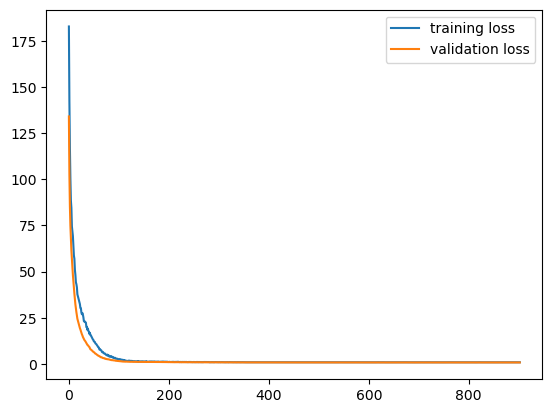

17
controls
headneck
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
17
 Epoch: 0000 loss_train: 177.0646 loss_val: 127.4359 time: 0.0797s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 55.3224 loss_val: 41.1880 time: 0.0514s
 Epoch: 0020 loss_train: 33.2548 loss_val: 22.4281 time: 0.0535s
 Epoch: 0030 loss_train: 24.7402 loss_val: 15.1059 time: 0.0717s
 Epoch: 0040 loss_train: 17.8194 loss_val: 10.6441 time: 0.0539s
 Epoch: 0050 loss_train: 11.9465 loss_val: 7.5325 time: 0.0888s
 Epoch: 0060 loss_train: 8.6005 loss_val: 6.0034 time: 0.0638s
 Epoch: 0070 loss_train: 5.7920 loss_val: 4.5843 time: 0.0526s
 Epoch: 0080 loss_train: 4.2550 loss_val: 3.7311 time: 0.0583s
 Epoch: 0090 loss_train: 3.3998 loss_val: 2.9462 time: 0.1073s
 Epoch: 0100 loss_train: 2.7062 loss_val: 2.3691 time: 0.1183s
 Epoch: 0110 loss_train: 2.1541 loss_val: 1.8909 time: 0.0646s
 Epoch: 0120 loss_train: 1.8030 loss_val: 1.6839 time: 0.0624s
 Epoch: 0130 loss_train: 1.6562 loss_val: 1.5667 time: 0.0974s
 Epoch: 0140 loss_train: 1.5088 loss_val: 1.5201 time: 0.0725s
 Epoch: 0150 loss_train: 1.3377 loss_val: 1.4752 time: 0.0532s
 Epoch: 0160 loss_train: 1.2241 loss_val: 1.42

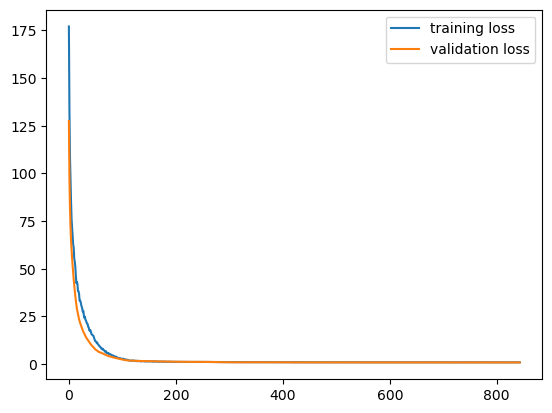

18
controls
headneck
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
hold out: P27
glioma
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
18
 Epoch: 0000 loss_train: 181.2252 loss_val: 130.3010 time: 0.0482s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 56.2784 loss_val: 40.7141 time: 0.0511s
 Epoch: 0020 loss_train: 35.5836 loss_val: 21.7859 time: 0.0516s
 Epoch: 0030 loss_train: 25.0789 loss_val: 13.8514 time: 0.0461s
 Epoch: 0040 loss_train: 17.9051 loss_val: 9.3697 time: 0.0797s
 Epoch: 0050 loss_train: 13.0869 loss_val: 6.3548 time: 0.0546s
 Epoch: 0060 loss_train: 8.9439 loss_val: 4.4031 time: 0.0649s
 Epoch: 0070 loss_train: 6.3056 loss_val: 3.0044 time: 0.0626s
 Epoch: 0080 loss_train: 4.5086 loss_val: 2.3623 time: 0.0750s
 Epoch: 0090 loss_train: 3.3152 loss_val: 1.8427 time: 0.0627s
 Epoch: 0100 loss_train: 2.7399 loss_val: 1.4563 time: 0.0543s
 Epoch: 0110 loss_train: 2.0739 loss_val: 1.2677 time: 0.1031s
 Epoch: 0120 loss_train: 1.8322 loss_val: 1.1417 time: 0.0534s
 Epoch: 0130 loss_train: 1.5600 loss_val: 1.0847 time: 0.0626s
 Epoch: 0140 loss_train: 1.2122 loss_val: 1.0356 time: 0.0575s
 Epoch: 0150 loss_train: 1.1585 loss_val: 1.0442 time: 0.0485s
 Epoch: 0160 loss_train: 1.2663 loss_val: 1.013

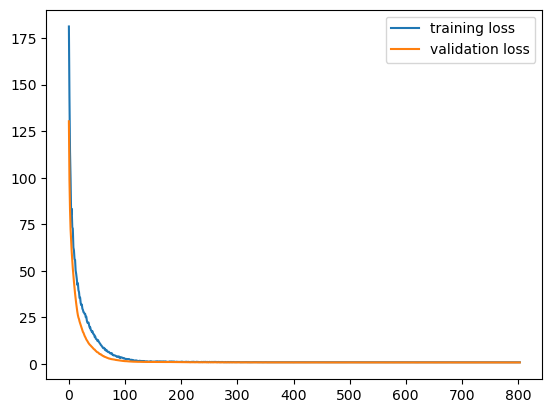

19
controls
headneck
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
hold out: P15
19
 Epoch: 0000 loss_train: 163.3812 loss_val: 122.2676 time: 0.0595s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 53.3072 loss_val: 36.4269 time: 0.0472s
 Epoch: 0020 loss_train: 32.2238 loss_val: 18.7574 time: 0.0676s
 Epoch: 0030 loss_train: 22.3300 loss_val: 12.5984 time: 0.0833s
 Epoch: 0040 loss_train: 16.2024 loss_val: 8.9891 time: 0.0843s
 Epoch: 0050 loss_train: 11.8825 loss_val: 6.6528 time: 0.0485s
 Epoch: 0060 loss_train: 7.9116 loss_val: 4.9803 time: 0.0541s
 Epoch: 0070 loss_train: 5.6784 loss_val: 3.4124 time: 0.0647s
 Epoch: 0080 loss_train: 4.3383 loss_val: 2.4649 time: 0.0656s
 Epoch: 0090 loss_train: 3.1179 loss_val: 1.9396 time: 0.0590s
 Epoch: 0100 loss_train: 2.5690 loss_val: 1.5634 time: 0.0951s
 Epoch: 0110 loss_train: 2.0036 loss_val: 1.3259 time: 0.0481s
 Epoch: 0120 loss_train: 1.6053 loss_val: 1.1995 time: 0.0482s
 Epoch: 0130 loss_train: 1.4554 loss_val: 1.1615 time: 0.0711s
 Epoch: 0140 loss_train: 1.3277 loss_val: 1.1340 time: 0.0526s
 Epoch: 0150 loss_train: 1.2998 loss_val: 1.1105 time: 0.0608s
 Epoch: 0160 loss_train: 1.2073 loss_val: 1.068

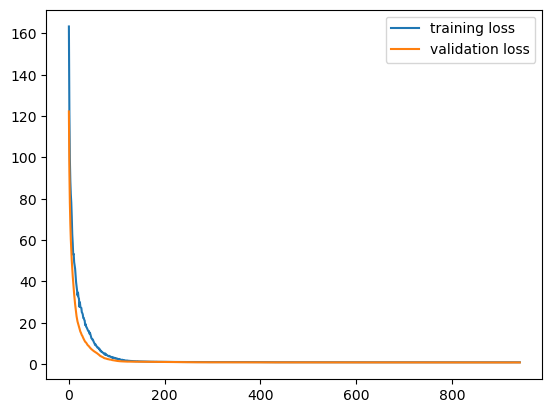

20
controls
headneck
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
20
 Epoch: 0000 loss_train: 169.7190 loss_val: 122.6426 time: 0.0597s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 54.3204 loss_val: 37.4733 time: 0.0535s
 Epoch: 0020 loss_train: 32.8372 loss_val: 19.3925 time: 0.0492s
 Epoch: 0030 loss_train: 22.7435 loss_val: 12.7257 time: 0.0478s
 Epoch: 0040 loss_train: 16.0037 loss_val: 9.6579 time: 0.0571s
 Epoch: 0050 loss_train: 11.8663 loss_val: 7.7864 time: 0.0580s
 Epoch: 0060 loss_train: 7.9155 loss_val: 5.7849 time: 0.0736s
 Epoch: 0070 loss_train: 5.9150 loss_val: 4.1433 time: 0.0558s
 Epoch: 0080 loss_train: 4.1663 loss_val: 3.0494 time: 0.0582s
 Epoch: 0090 loss_train: 3.0978 loss_val: 2.3739 time: 0.0638s
 Epoch: 0100 loss_train: 2.4530 loss_val: 1.9574 time: 0.0528s
 Epoch: 0110 loss_train: 1.8854 loss_val: 1.5733 time: 0.0528s
 Epoch: 0120 loss_train: 1.5534 loss_val: 1.3095 time: 0.0495s
 Epoch: 0130 loss_train: 1.3558 loss_val: 1.2533 time: 0.0667s
 Epoch: 0140 loss_train: 1.2907 loss_val: 1.1669 time: 0.0604s
 Epoch: 0150 loss_train: 1.1798 loss_val: 1.1405 time: 0.0490s
 Epoch: 0160 loss_train: 1.1312 loss_val: 1.127

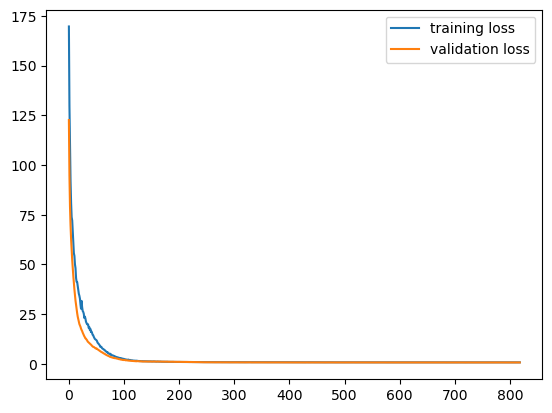

21
controls
headneck
dapi_cd16_cd4_cd8
P55
P56
P72
P14
hold out: P18
hold out: P41
P44
P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
P42
P48
hold out: P62
hold out: P38
P83
P37
P33
P70
P59
P27
glioma
dapi_cd16_cd4_cd8
P46
P47
P29
hold out: P52
P57
P22
P68
hold out: P16
P84
P15
21
 Epoch: 0000 loss_train: 165.7291 loss_val: 117.3003 time: 0.0566s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 53.7630 loss_val: 39.4371 time: 0.0455s
 Epoch: 0020 loss_train: 33.5248 loss_val: 19.4657 time: 0.0622s
 Epoch: 0030 loss_train: 24.2591 loss_val: 12.6018 time: 0.0497s
 Epoch: 0040 loss_train: 17.7940 loss_val: 8.7753 time: 0.0796s
 Epoch: 0050 loss_train: 13.0210 loss_val: 6.1721 time: 0.0735s
 Epoch: 0060 loss_train: 8.5310 loss_val: 4.5130 time: 0.0611s
 Epoch: 0070 loss_train: 6.3838 loss_val: 3.2860 time: 0.0574s
 Epoch: 0080 loss_train: 4.8860 loss_val: 2.4690 time: 0.0596s
 Epoch: 0090 loss_train: 3.9081 loss_val: 1.9768 time: 0.0503s
 Epoch: 0100 loss_train: 3.0207 loss_val: 1.5507 time: 0.0583s
 Epoch: 0110 loss_train: 2.4936 loss_val: 1.3343 time: 0.0508s
 Epoch: 0120 loss_train: 1.8603 loss_val: 1.1835 time: 0.0531s
 Epoch: 0130 loss_train: 1.6998 loss_val: 1.1153 time: 0.0804s
 Epoch: 0140 loss_train: 1.3629 loss_val: 1.0555 time: 0.0878s
 Epoch: 0150 loss_train: 1.2135 loss_val: 1.0356 time: 0.0578s
 Epoch: 0160 loss_train: 1.3119 loss_val: 1.030

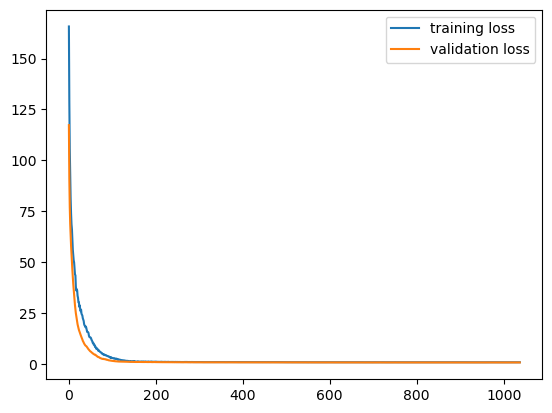

22
controls
headneck
dapi_cd16_cd4_cd8
P55
hold out: P56
P72
P14
P18
P41
P44
P63
hold out: P50
P24
meningioma
dapi_cd16_cd4_cd8
P42
hold out: P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
hold out: P84
P15
22
 Epoch: 0000 loss_train: 187.7953 loss_val: 124.5398 time: 0.0528s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 59.0414 loss_val: 34.1201 time: 0.1064s
 Epoch: 0020 loss_train: 34.9373 loss_val: 16.7528 time: 0.0586s
 Epoch: 0030 loss_train: 23.3419 loss_val: 10.9499 time: 0.0494s
 Epoch: 0040 loss_train: 17.3818 loss_val: 7.8539 time: 0.0511s
 Epoch: 0050 loss_train: 12.7465 loss_val: 5.2809 time: 0.0512s
 Epoch: 0060 loss_train: 8.7480 loss_val: 3.7608 time: 0.0567s
 Epoch: 0070 loss_train: 5.9548 loss_val: 2.6924 time: 0.1063s
 Epoch: 0080 loss_train: 4.1767 loss_val: 2.2227 time: 0.0598s
 Epoch: 0090 loss_train: 3.4920 loss_val: 1.7852 time: 0.0896s
 Epoch: 0100 loss_train: 2.5079 loss_val: 1.4338 time: 0.0640s
 Epoch: 0110 loss_train: 1.8216 loss_val: 1.2417 time: 0.0688s
 Epoch: 0120 loss_train: 1.7286 loss_val: 1.0933 time: 0.0727s
 Epoch: 0130 loss_train: 1.3928 loss_val: 1.0435 time: 0.1094s
 Epoch: 0140 loss_train: 1.2758 loss_val: 1.0166 time: 0.0587s
 Epoch: 0150 loss_train: 1.1825 loss_val: 0.9633 time: 0.1123s
 Epoch: 0160 loss_train: 1.2501 loss_val: 0.919

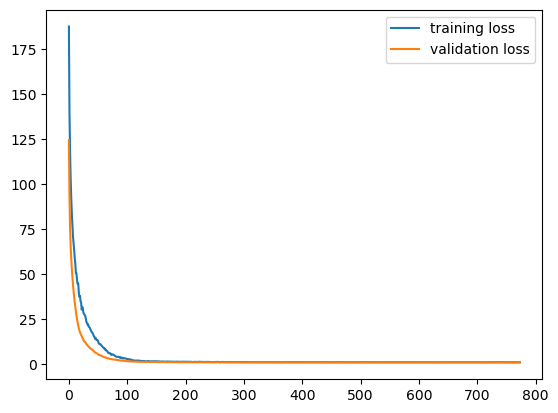

23
controls
headneck
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
23
 Epoch: 0000 loss_train: 164.3261 loss_val: 126.6710 time: 0.0544s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 55.9554 loss_val: 42.6342 time: 0.0585s
 Epoch: 0020 loss_train: 33.4004 loss_val: 22.8106 time: 0.0462s
 Epoch: 0030 loss_train: 23.5333 loss_val: 14.7532 time: 0.0694s
 Epoch: 0040 loss_train: 16.9472 loss_val: 10.0223 time: 0.0525s
 Epoch: 0050 loss_train: 12.2259 loss_val: 7.0021 time: 0.0525s
 Epoch: 0060 loss_train: 8.5207 loss_val: 4.9969 time: 0.0511s
 Epoch: 0070 loss_train: 6.2110 loss_val: 3.5714 time: 0.0640s
 Epoch: 0080 loss_train: 4.4846 loss_val: 2.6314 time: 0.0502s
 Epoch: 0090 loss_train: 3.1935 loss_val: 2.0143 time: 0.0602s
 Epoch: 0100 loss_train: 2.7876 loss_val: 1.6141 time: 0.0838s
 Epoch: 0110 loss_train: 2.2413 loss_val: 1.3236 time: 0.0654s
 Epoch: 0120 loss_train: 1.7450 loss_val: 1.2167 time: 0.0541s
 Epoch: 0130 loss_train: 1.5448 loss_val: 1.1635 time: 0.0504s
 Epoch: 0140 loss_train: 1.4357 loss_val: 1.1208 time: 0.0531s
 Epoch: 0150 loss_train: 1.4546 loss_val: 1.1189 time: 0.0491s
 Epoch: 0160 loss_train: 1.2470 loss_val: 1.08

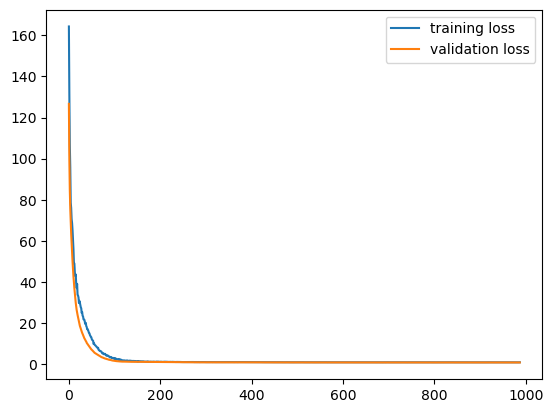

24
controls
headneck
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
hold out: P27
glioma
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
24
 Epoch: 0000 loss_train: 184.5483 loss_val: 127.2671 time: 0.0537s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 58.2848 loss_val: 37.0812 time: 0.0618s
 Epoch: 0020 loss_train: 35.7230 loss_val: 19.3085 time: 0.0469s
 Epoch: 0030 loss_train: 23.7335 loss_val: 12.9337 time: 0.0922s
 Epoch: 0040 loss_train: 18.0568 loss_val: 9.1426 time: 0.0480s
 Epoch: 0050 loss_train: 12.8222 loss_val: 6.3612 time: 0.0977s
 Epoch: 0060 loss_train: 8.8792 loss_val: 4.3038 time: 0.0996s
 Epoch: 0070 loss_train: 6.5715 loss_val: 3.1241 time: 0.0462s
 Epoch: 0080 loss_train: 4.8410 loss_val: 2.3866 time: 0.0687s
 Epoch: 0090 loss_train: 3.9533 loss_val: 1.9306 time: 0.1222s
 Epoch: 0100 loss_train: 2.7905 loss_val: 1.5888 time: 0.1215s
 Epoch: 0110 loss_train: 2.2653 loss_val: 1.2582 time: 0.0682s
 Epoch: 0120 loss_train: 1.6262 loss_val: 1.1467 time: 0.0698s
 Epoch: 0130 loss_train: 1.6195 loss_val: 1.0641 time: 0.0660s
 Epoch: 0140 loss_train: 1.2767 loss_val: 1.1454 time: 0.0430s
 Epoch: 0150 loss_train: 1.3764 loss_val: 1.0586 time: 0.1249s
 Epoch: 0160 loss_train: 1.3482 loss_val: 1.046

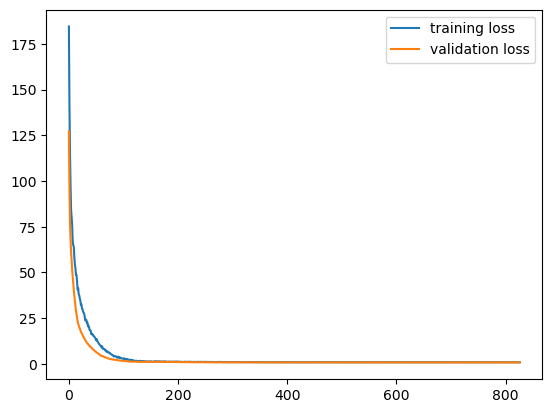

25
controls
headneck
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
hold out: P15
25
 Epoch: 0000 loss_train: 156.0705 loss_val: 121.5289 time: 0.0506s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 51.8612 loss_val: 40.3680 time: 0.0501s
 Epoch: 0020 loss_train: 30.8823 loss_val: 20.9673 time: 0.0629s
 Epoch: 0030 loss_train: 22.7198 loss_val: 13.2829 time: 0.0538s
 Epoch: 0040 loss_train: 15.7956 loss_val: 9.1532 time: 0.0613s
 Epoch: 0050 loss_train: 11.3232 loss_val: 6.9355 time: 0.0531s
 Epoch: 0060 loss_train: 7.6883 loss_val: 5.2716 time: 0.0551s
 Epoch: 0070 loss_train: 5.5037 loss_val: 4.0338 time: 0.0568s
 Epoch: 0080 loss_train: 4.1683 loss_val: 3.2820 time: 0.0497s
 Epoch: 0090 loss_train: 3.2677 loss_val: 2.5030 time: 0.0496s
 Epoch: 0100 loss_train: 2.5268 loss_val: 1.9367 time: 0.0611s
 Epoch: 0110 loss_train: 2.0171 loss_val: 1.5551 time: 0.0529s
 Epoch: 0120 loss_train: 1.6984 loss_val: 1.3392 time: 0.0492s
 Epoch: 0130 loss_train: 1.4821 loss_val: 1.2229 time: 0.0559s
 Epoch: 0140 loss_train: 1.3870 loss_val: 1.1764 time: 0.0604s
 Epoch: 0150 loss_train: 1.2841 loss_val: 1.1333 time: 0.0521s
 Epoch: 0160 loss_train: 1.1957 loss_val: 1.074

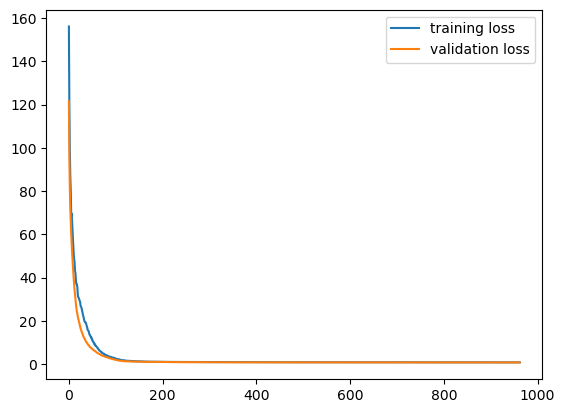

26
controls
headneck
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
26
 Epoch: 0000 loss_train: 167.3304 loss_val: 118.6320 time: 0.0577s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 54.5777 loss_val: 36.1534 time: 0.0711s
 Epoch: 0020 loss_train: 34.7110 loss_val: 17.6705 time: 0.0520s
 Epoch: 0030 loss_train: 23.6828 loss_val: 11.0958 time: 0.0643s
 Epoch: 0040 loss_train: 17.2103 loss_val: 7.8161 time: 0.0516s
 Epoch: 0050 loss_train: 12.1690 loss_val: 5.6465 time: 0.0529s
 Epoch: 0060 loss_train: 8.3665 loss_val: 4.0642 time: 0.0677s
 Epoch: 0070 loss_train: 6.2765 loss_val: 3.0103 time: 0.0489s
 Epoch: 0080 loss_train: 4.6138 loss_val: 2.1179 time: 0.0481s
 Epoch: 0090 loss_train: 3.5333 loss_val: 1.6038 time: 0.0502s
 Epoch: 0100 loss_train: 2.8863 loss_val: 1.2344 time: 0.0512s
 Epoch: 0110 loss_train: 1.7861 loss_val: 1.0651 time: 0.0485s
 Epoch: 0120 loss_train: 1.7106 loss_val: 0.9699 time: 0.0600s
 Epoch: 0130 loss_train: 1.3953 loss_val: 0.8985 time: 0.0470s
 Epoch: 0140 loss_train: 1.3041 loss_val: 0.8900 time: 0.0530s
 Epoch: 0150 loss_train: 1.3500 loss_val: 0.8979 time: 0.0522s
 Epoch: 0160 loss_train: 1.1385 loss_val: 0.912

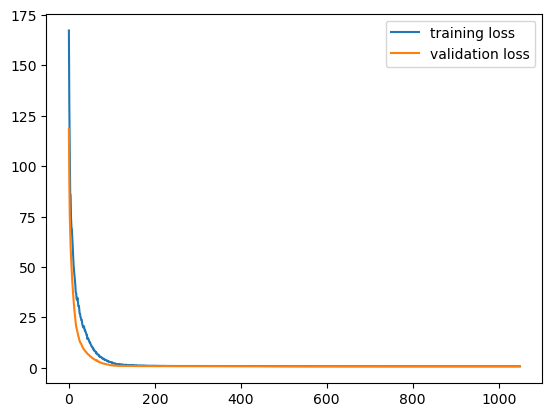

27
controls
headneck
dapi_cd16_cd4_cd8
P55
P56
P72
P14
hold out: P18
hold out: P41
P44
P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
P42
P48
hold out: P62
hold out: P38
P83
P37
P33
P70
P59
P27
glioma
dapi_cd16_cd4_cd8
P46
P47
P29
hold out: P52
P57
P22
P68
hold out: P16
P84
P15
27
 Epoch: 0000 loss_train: 165.5239 loss_val: 116.5513 time: 0.0620s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 53.3338 loss_val: 35.6627 time: 0.1633s
 Epoch: 0020 loss_train: 35.3504 loss_val: 19.3339 time: 0.0807s
 Epoch: 0030 loss_train: 23.7253 loss_val: 13.1517 time: 0.0591s
 Epoch: 0040 loss_train: 17.7915 loss_val: 9.4749 time: 0.0642s
 Epoch: 0050 loss_train: 13.0087 loss_val: 7.0504 time: 0.1351s
 Epoch: 0060 loss_train: 9.0274 loss_val: 5.1735 time: 0.0447s
 Epoch: 0070 loss_train: 6.1587 loss_val: 3.8160 time: 0.0725s
 Epoch: 0080 loss_train: 4.7362 loss_val: 2.8935 time: 0.1425s
 Epoch: 0090 loss_train: 3.8736 loss_val: 2.3167 time: 0.0487s
 Epoch: 0100 loss_train: 3.0189 loss_val: 1.8372 time: 0.0736s
 Epoch: 0110 loss_train: 2.4891 loss_val: 1.4813 time: 0.0497s
 Epoch: 0120 loss_train: 1.9634 loss_val: 1.2796 time: 0.1590s
 Epoch: 0130 loss_train: 1.6766 loss_val: 1.1749 time: 0.1524s
 Epoch: 0140 loss_train: 1.5057 loss_val: 1.1187 time: 0.1342s
 Epoch: 0150 loss_train: 1.2707 loss_val: 1.0774 time: 0.0535s
 Epoch: 0160 loss_train: 1.1905 loss_val: 1.043

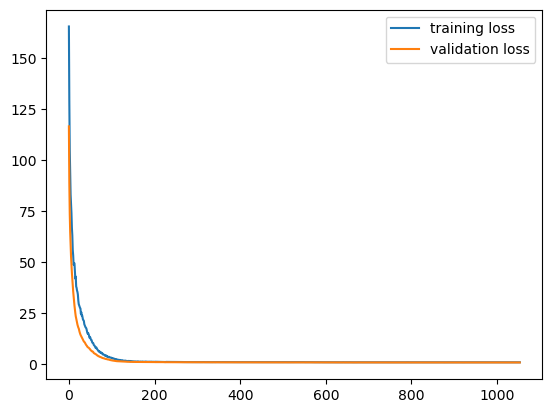

28
controls
headneck
dapi_cd16_cd4_cd8
P55
hold out: P56
P72
P14
P18
P41
P44
P63
hold out: P50
P24
meningioma
dapi_cd16_cd4_cd8
P42
hold out: P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
hold out: P84
P15
28
 Epoch: 0000 loss_train: 187.3228 loss_val: 136.5424 time: 0.0769s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 55.9318 loss_val: 41.2311 time: 0.0467s
 Epoch: 0020 loss_train: 35.7886 loss_val: 20.7992 time: 0.0528s
 Epoch: 0030 loss_train: 24.2997 loss_val: 13.3125 time: 0.0618s
 Epoch: 0040 loss_train: 17.2365 loss_val: 9.0231 time: 0.0533s
 Epoch: 0050 loss_train: 12.1176 loss_val: 6.0862 time: 0.0583s
 Epoch: 0060 loss_train: 8.2499 loss_val: 4.3282 time: 0.0489s
 Epoch: 0070 loss_train: 5.9794 loss_val: 3.1193 time: 0.0636s
 Epoch: 0080 loss_train: 3.9401 loss_val: 2.3551 time: 0.0506s
 Epoch: 0090 loss_train: 3.2916 loss_val: 1.8605 time: 0.0515s
 Epoch: 0100 loss_train: 2.7253 loss_val: 1.5750 time: 0.0505s
 Epoch: 0110 loss_train: 1.8406 loss_val: 1.3730 time: 0.1315s
 Epoch: 0120 loss_train: 1.8012 loss_val: 1.2368 time: 0.0525s
 Epoch: 0130 loss_train: 1.5464 loss_val: 1.1456 time: 0.0497s
 Epoch: 0140 loss_train: 1.2322 loss_val: 1.0886 time: 0.1226s
 Epoch: 0150 loss_train: 1.1680 loss_val: 1.0435 time: 0.0623s
 Epoch: 0160 loss_train: 1.1137 loss_val: 0.998

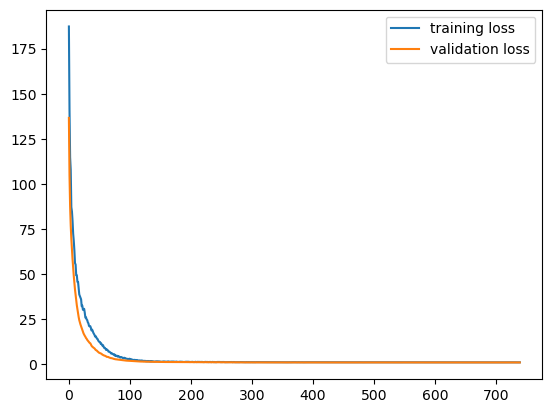

29
controls
headneck
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
29
 Epoch: 0000 loss_train: 171.8496 loss_val: 121.5810 time: 0.0526s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 54.6490 loss_val: 32.8004 time: 0.0473s
 Epoch: 0020 loss_train: 33.4355 loss_val: 16.1385 time: 0.0504s
 Epoch: 0030 loss_train: 24.0783 loss_val: 11.0880 time: 0.0549s
 Epoch: 0040 loss_train: 17.5809 loss_val: 8.2164 time: 0.0484s
 Epoch: 0050 loss_train: 12.2840 loss_val: 6.2445 time: 0.0537s
 Epoch: 0060 loss_train: 8.6065 loss_val: 4.7056 time: 0.0483s
 Epoch: 0070 loss_train: 6.0381 loss_val: 3.5017 time: 0.0468s
 Epoch: 0080 loss_train: 4.5365 loss_val: 2.6473 time: 0.0550s
 Epoch: 0090 loss_train: 3.2837 loss_val: 1.9786 time: 0.0606s
 Epoch: 0100 loss_train: 2.7940 loss_val: 1.6090 time: 0.0462s
 Epoch: 0110 loss_train: 2.1430 loss_val: 1.3155 time: 0.0619s
 Epoch: 0120 loss_train: 1.8433 loss_val: 1.1807 time: 0.0464s
 Epoch: 0130 loss_train: 1.5635 loss_val: 1.1493 time: 0.0467s
 Epoch: 0140 loss_train: 1.5215 loss_val: 1.1303 time: 0.0495s
 Epoch: 0150 loss_train: 1.3544 loss_val: 1.1193 time: 0.0487s
 Epoch: 0160 loss_train: 1.2765 loss_val: 1.095

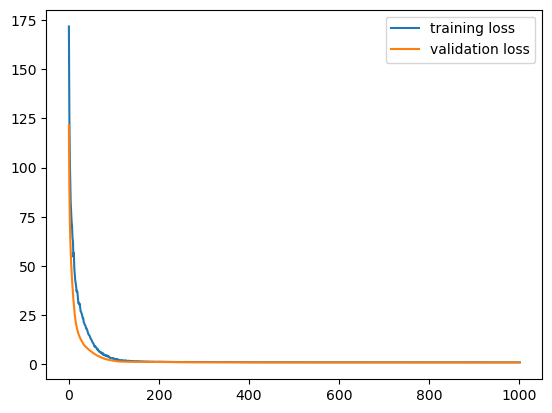

30
controls
headneck
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
hold out: P27
glioma
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
30
 Epoch: 0000 loss_train: 174.5256 loss_val: 134.2972 time: 0.0478s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 59.3563 loss_val: 39.4212 time: 0.0475s
 Epoch: 0020 loss_train: 32.8443 loss_val: 21.2172 time: 0.0619s
 Epoch: 0030 loss_train: 24.0247 loss_val: 13.9518 time: 0.0456s
 Epoch: 0040 loss_train: 17.5704 loss_val: 9.8476 time: 0.0454s
 Epoch: 0050 loss_train: 12.5240 loss_val: 7.1026 time: 0.0536s
 Epoch: 0060 loss_train: 8.6354 loss_val: 5.2172 time: 0.0520s
 Epoch: 0070 loss_train: 5.9302 loss_val: 3.8472 time: 0.0465s
 Epoch: 0080 loss_train: 4.5236 loss_val: 3.1090 time: 0.0553s
 Epoch: 0090 loss_train: 3.6619 loss_val: 2.5240 time: 0.1900s
 Epoch: 0100 loss_train: 2.5064 loss_val: 2.0601 time: 0.1270s
 Epoch: 0110 loss_train: 2.2277 loss_val: 1.6743 time: 0.0663s
 Epoch: 0120 loss_train: 1.6590 loss_val: 1.4431 time: 0.0886s
 Epoch: 0130 loss_train: 1.5432 loss_val: 1.2960 time: 0.0443s
 Epoch: 0140 loss_train: 1.3162 loss_val: 1.2006 time: 0.0463s
 Epoch: 0150 loss_train: 1.4018 loss_val: 1.0891 time: 0.0466s
 Epoch: 0160 loss_train: 1.1126 loss_val: 1.114

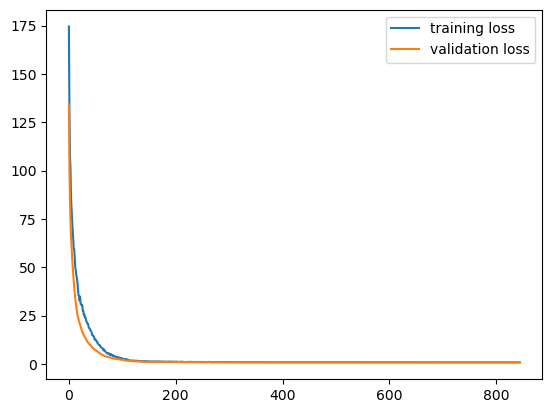

31
controls
headneck
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
hold out: P15
31
 Epoch: 0000 loss_train: 170.0283 loss_val: 120.7868 time: 0.0513s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 56.0337 loss_val: 38.4573 time: 0.1279s
 Epoch: 0020 loss_train: 32.3155 loss_val: 20.0592 time: 0.0773s
 Epoch: 0030 loss_train: 23.5180 loss_val: 13.0843 time: 0.0883s
 Epoch: 0040 loss_train: 16.8616 loss_val: 9.4013 time: 0.0510s
 Epoch: 0050 loss_train: 11.7401 loss_val: 6.7060 time: 0.0630s
 Epoch: 0060 loss_train: 8.3668 loss_val: 5.0552 time: 0.0543s
 Epoch: 0070 loss_train: 5.8672 loss_val: 3.4061 time: 0.0566s
 Epoch: 0080 loss_train: 4.0249 loss_val: 2.6184 time: 0.0485s
 Epoch: 0090 loss_train: 3.2197 loss_val: 2.0512 time: 0.0828s
 Epoch: 0100 loss_train: 2.4614 loss_val: 1.6534 time: 0.0524s
 Epoch: 0110 loss_train: 2.0195 loss_val: 1.3379 time: 0.0607s
 Epoch: 0120 loss_train: 1.6076 loss_val: 1.2363 time: 0.0472s
 Epoch: 0130 loss_train: 1.3923 loss_val: 1.2337 time: 0.0500s
 Epoch: 0140 loss_train: 1.2668 loss_val: 1.2762 time: 0.0662s
 Epoch: 0150 loss_train: 1.2054 loss_val: 1.1748 time: 0.0481s
 Epoch: 0160 loss_train: 1.1499 loss_val: 1.139

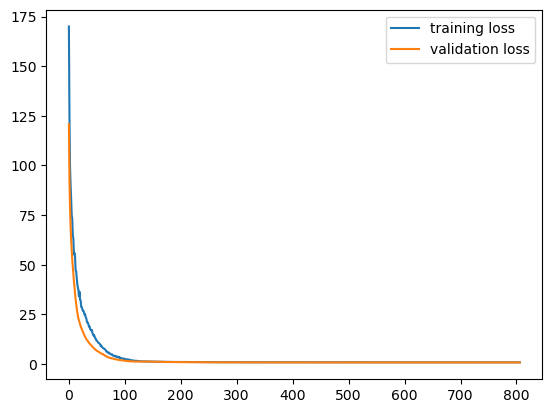

32
controls
headneck
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
32
 Epoch: 0000 loss_train: 176.1741 loss_val: 113.8461 time: 0.0827s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 60.1394 loss_val: 31.9545 time: 0.0471s
 Epoch: 0020 loss_train: 33.6608 loss_val: 16.4036 time: 0.0456s
 Epoch: 0030 loss_train: 23.8959 loss_val: 11.0108 time: 0.0521s
 Epoch: 0040 loss_train: 16.5735 loss_val: 8.2834 time: 0.0988s
 Epoch: 0050 loss_train: 12.2005 loss_val: 6.0686 time: 0.1060s
 Epoch: 0060 loss_train: 8.8535 loss_val: 4.6818 time: 0.0560s
 Epoch: 0070 loss_train: 6.4018 loss_val: 3.4004 time: 0.0700s
 Epoch: 0080 loss_train: 4.4807 loss_val: 2.4037 time: 0.0601s
 Epoch: 0090 loss_train: 3.3984 loss_val: 1.9045 time: 0.0497s
 Epoch: 0100 loss_train: 2.5026 loss_val: 1.5378 time: 0.0840s
 Epoch: 0110 loss_train: 1.9441 loss_val: 1.2056 time: 0.0548s
 Epoch: 0120 loss_train: 1.8525 loss_val: 1.0819 time: 0.0574s
 Epoch: 0130 loss_train: 1.4472 loss_val: 1.0447 time: 0.0613s
 Epoch: 0140 loss_train: 1.2312 loss_val: 1.0346 time: 0.0505s
 Epoch: 0150 loss_train: 1.1591 loss_val: 0.9325 time: 0.0616s
 Epoch: 0160 loss_train: 1.1281 loss_val: 0.926

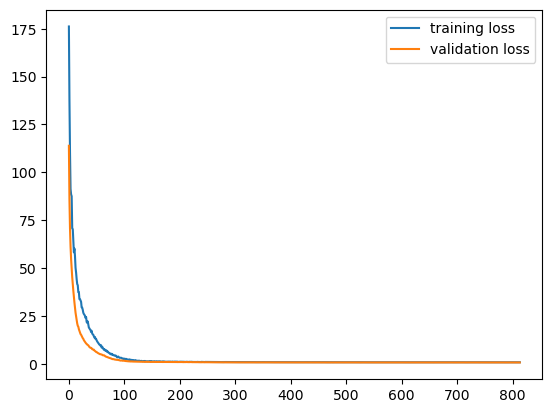

33
controls
headneck
dapi_cd16_cd4_cd8
P55
P56
P72
P14
hold out: P18
hold out: P41
P44
P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
P42
P48
hold out: P62
hold out: P38
P83
P37
P33
P70
P59
P27
glioma
dapi_cd16_cd4_cd8
P46
P47
P29
hold out: P52
P57
P22
P68
hold out: P16
P84
P15
33
 Epoch: 0000 loss_train: 172.1149 loss_val: 113.0257 time: 0.0531s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 55.0846 loss_val: 36.5653 time: 0.0624s
 Epoch: 0020 loss_train: 33.6989 loss_val: 19.1730 time: 0.0536s
 Epoch: 0030 loss_train: 24.2859 loss_val: 12.7216 time: 0.0483s
 Epoch: 0040 loss_train: 17.1517 loss_val: 9.1965 time: 0.0490s
 Epoch: 0050 loss_train: 12.6285 loss_val: 6.4562 time: 0.0456s
 Epoch: 0060 loss_train: 8.9707 loss_val: 4.8466 time: 0.0459s
 Epoch: 0070 loss_train: 6.7457 loss_val: 3.3656 time: 0.0475s
 Epoch: 0080 loss_train: 4.7102 loss_val: 2.7420 time: 0.0522s
 Epoch: 0090 loss_train: 3.9350 loss_val: 2.3068 time: 0.0621s
 Epoch: 0100 loss_train: 3.1952 loss_val: 1.8068 time: 0.0536s
 Epoch: 0110 loss_train: 2.3116 loss_val: 1.4180 time: 0.0485s
 Epoch: 0120 loss_train: 1.7555 loss_val: 1.2720 time: 0.0472s
 Epoch: 0130 loss_train: 1.6724 loss_val: 1.1941 time: 0.0501s
 Epoch: 0140 loss_train: 1.3566 loss_val: 1.1371 time: 0.0510s
 Epoch: 0150 loss_train: 1.3951 loss_val: 1.1131 time: 0.0505s
 Epoch: 0160 loss_train: 1.3326 loss_val: 1.073

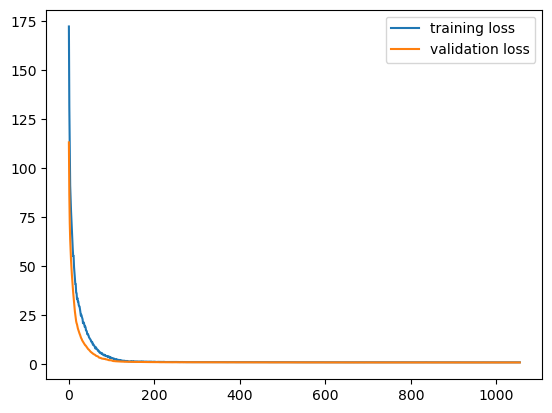

34
controls
headneck
dapi_cd16_cd4_cd8
P55
hold out: P56
P72
P14
P18
P41
P44
P63
hold out: P50
P24
meningioma
dapi_cd16_cd4_cd8
P42
hold out: P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
hold out: P84
P15
34
 Epoch: 0000 loss_train: 178.8295 loss_val: 131.9150 time: 0.0576s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 58.4506 loss_val: 38.1835 time: 0.0490s
 Epoch: 0020 loss_train: 34.5360 loss_val: 18.9754 time: 0.0486s
 Epoch: 0030 loss_train: 23.2480 loss_val: 12.2768 time: 0.0488s
 Epoch: 0040 loss_train: 17.4856 loss_val: 8.4549 time: 0.0512s
 Epoch: 0050 loss_train: 12.1485 loss_val: 5.6503 time: 0.0556s
 Epoch: 0060 loss_train: 8.4830 loss_val: 3.9256 time: 0.0572s
 Epoch: 0070 loss_train: 5.8219 loss_val: 2.7377 time: 0.0497s
 Epoch: 0080 loss_train: 4.2291 loss_val: 2.1283 time: 0.0526s
 Epoch: 0090 loss_train: 3.5598 loss_val: 1.6524 time: 0.0480s
 Epoch: 0100 loss_train: 2.4563 loss_val: 1.2820 time: 0.0499s
 Epoch: 0110 loss_train: 1.8506 loss_val: 1.0880 time: 0.0452s
 Epoch: 0120 loss_train: 1.4978 loss_val: 1.0100 time: 0.0547s
 Epoch: 0130 loss_train: 1.3288 loss_val: 1.0088 time: 0.1216s
 Epoch: 0140 loss_train: 1.2158 loss_val: 0.9800 time: 0.0703s
 Epoch: 0150 loss_train: 1.1406 loss_val: 0.9637 time: 0.0914s
 Epoch: 0160 loss_train: 1.2641 loss_val: 0.961

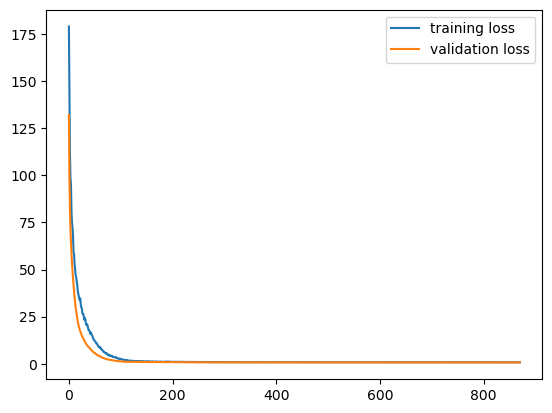

35
controls
headneck
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
35
 Epoch: 0000 loss_train: 171.2252 loss_val: 129.2041 time: 0.0466s


/tmp/ipykernel_1909915/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1909915/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 53.7657 loss_val: 38.2553 time: 0.0721s
 Epoch: 0020 loss_train: 32.8747 loss_val: 20.4194 time: 0.1020s
 Epoch: 0030 loss_train: 24.1598 loss_val: 13.3234 time: 0.0656s
 Epoch: 0040 loss_train: 17.3276 loss_val: 9.5081 time: 0.1555s
 Epoch: 0050 loss_train: 13.1594 loss_val: 6.8850 time: 0.0866s
 Epoch: 0060 loss_train: 8.5421 loss_val: 5.0129 time: 0.0455s
 Epoch: 0070 loss_train: 5.8552 loss_val: 3.6517 time: 0.0989s
 Epoch: 0080 loss_train: 4.2716 loss_val: 2.7886 time: 0.0769s
 Epoch: 0090 loss_train: 3.5176 loss_val: 2.0509 time: 0.0808s
 Epoch: 0100 loss_train: 2.4566 loss_val: 1.5878 time: 0.0482s
 Epoch: 0110 loss_train: 2.1405 loss_val: 1.3303 time: 0.0497s
 Epoch: 0120 loss_train: 1.6513 loss_val: 1.2321 time: 0.0465s
 Epoch: 0130 loss_train: 1.6851 loss_val: 1.1857 time: 0.0480s
 Epoch: 0140 loss_train: 1.3661 loss_val: 1.1573 time: 0.1347s
 Epoch: 0150 loss_train: 1.2821 loss_val: 1.1284 time: 0.2098s
 Epoch: 0160 loss_train: 1.2125 loss_val: 1.113

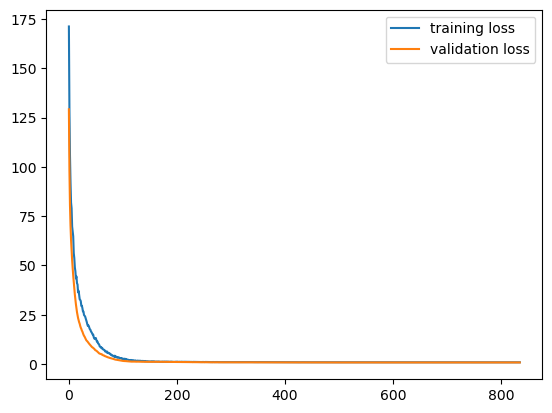

In [8]:
pnames=['gh2ax','cd4','cd8','lamin','cd3','cd16']
for p in pnames:
    print(p)
    with open(os.path.join(sourceDir,'nmco_allfeatures_names_'+p), 'rb') as output:
        nmco_names=pickle.load(output)
    for sample_s in range(prevSampled,nSamples):
        print(sample_s)
        nmco_all_samples_s=None
        imgNames_all_samples_s=None
        pID_all_samples_s=None
        conditions_all_samples_s=None

        for condition_i in conditions:
            print(condition_i)
            segDir_i=os.path.join(segDir,condition_i)
            imgDir_i=os.path.join(imgDir,condition_i)
            for stain in os.listdir(segDir_i):
                if p not in stain:
                    continue
                print(stain)
                segDir_i_stain=os.path.join(segDir_i,stain)
                imgDir_i_stain=os.path.join(imgDir_i,stain)

                segPID2name={}
                for pID_dir in os.listdir(segDir_i_stain):
                    pID=pID_dir.split('_')
                    segPID2name[pID[0]]=pID_dir
                imgPID2name={}
                for pID_dir in os.listdir(imgDir_i_stain):
                    pID=pID_dir.split('_')
                    imgPID2name[pID[0]]=pID_dir
                for pID in segPID2name.keys():
                    if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                        continue
                    if pID in holdOutSamples_samples[sample_s%6]:
                        print('hold out: '+pID)
                        continue
                    print(pID)
                    if pID not in imgPID2name:
                        print('img not found '+pID)
                        continue
                    imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
                    segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])

                    with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                        imgNames=pickle.load(output)
                    with open(os.path.join(imgDir_i_stain_p,'nmco_allfeatures_protein'), 'rb') as output:
                        nmco_p=pickle.load(output) 

                    
                    if nmco_all_samples_s is None:
                        pID_all_samples_s=np.repeat(pID,imgNames.shape[0])
                        nmco_all_samples_s=nmco_p[p]
                        imgNames_all_samples_s=imgNames
                        conditions_all_samples_s=np.repeat(condition_i,imgNames.shape[0])
                    else:
                        pID_all_samples_s=np.concatenate((pID_all_samples_s,np.repeat(pID,imgNames.shape[0])))
                        nmco_all_samples_s=np.concatenate((nmco_all_samples_s,nmco_p[p]),axis=0)
                        imgNames_all_samples_s=np.concatenate((imgNames_all_samples_s,imgNames))
                        conditions_all_samples_s=np.concatenate((conditions_all_samples_s,np.repeat(condition_i,imgNames.shape[0])))

        print(sample_s)

        logsavepath_train_curr=os.path.join(logsavepath_train,p)
        modelsavepath_train_curr=os.path.join(modelsavepath_train,p)
        plotsavepath_train_curr=os.path.join(plotsavepath_train,p)
        if not os.path.exists(logsavepath_train_curr):
            os.mkdir(logsavepath_train_curr)
        if not os.path.exists(modelsavepath_train_curr):
            os.mkdir(modelsavepath_train_curr)
        if not os.path.exists(plotsavepath_train_curr):
            os.mkdir(plotsavepath_train_curr)
        logsavepath_train_curr=os.path.join(logsavepath_train,p,str(sample_s))
        modelsavepath_train_curr=os.path.join(modelsavepath_train,p,str(sample_s))
        plotsavepath_train_curr=os.path.join(plotsavepath_train,p,str(sample_s))
        if not os.path.exists(logsavepath_train_curr):
            os.mkdir(logsavepath_train_curr)
        if not os.path.exists(modelsavepath_train_curr):
            os.mkdir(modelsavepath_train_curr)
        if not os.path.exists(plotsavepath_train_curr):
            os.mkdir(plotsavepath_train_curr)

        np.random.seed(sample_s)
        nvalSamples=int(valRatio*conditions_all_samples_s.size)
        allIdx=np.arange(conditions_all_samples_s.size)
        np.random.shuffle(allIdx)
        valIdx=allIdx[:nvalSamples]
        trainIdx=allIdx[nvalSamples:]
        
        conditions_all_curr=conditions_all_samples_s[trainIdx]
        cnames,revIdx_c,cCounts=np.unique(conditions_all_curr,return_inverse=True,return_counts=True)
        clfWeight=1/cCounts
        clfWeight=clfWeight/np.sum(clfWeight)
        loss_clf=torch.nn.CrossEntropyLoss(weight=torch.tensor(clfWeight).cuda().float())
        cnames_val,revIdx_c_val,cCounts_val=np.unique(conditions_all_samples_s[valIdx],return_inverse=True,return_counts=True)

        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        if modelname_train=='nmco2cond_fc_l2':
            model=FC_l2(nmco_all_samples_s.shape[1],8,8,cnames.size)
        model.cuda()
        optimizer_clf = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        train_loss=[np.inf]*epochs
        val_loss=[np.inf]*epochs

        t_ep=time.time()

        epCounts=0
        for ep in range(epochs):
            train_loss[ep],val_loss[ep]=train(ep,model,optimizer_clf,nmco_all_samples_s[trainIdx],nmco_all_samples_s[valIdx],torch.tensor(revIdx_c),torch.tensor(revIdx_c_val))

            if ep>50 and val_loss[ep]>=val_loss[ep-50]:
                epCounts+=1

            if epCounts>150:
                break


            if ep%saveFreq == (saveFreq-1):
                torch.save(model.cpu().state_dict(), os.path.join(modelsavepath_train_curr,'ep'+str(ep)+'.pt'))


            model.cuda()
            torch.cuda.empty_cache()
        print(' total time: {:.4f}s'.format(time.time() - t_ep))


        with open(os.path.join(logsavepath_train_curr,'train_loss'), 'wb') as output:
            pickle.dump(train_loss, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_train_curr,'val_loss'), 'wb') as output:
            pickle.dump(val_loss, output, pickle.HIGHEST_PROTOCOL)


        plt.plot(np.arange(epochs),train_loss)
        plt.plot(np.arange(epochs),val_loss)
        plt.legend(['training loss','validation loss'],loc='upper right')
        plt.savefig(os.path.join(plotsavepath_train_curr,'loss_seed3.jpg'))
        plt.show()


In [9]:
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname='',ctorder=None,vmin=None,vmax=None):
    if ctorder is None:
        ctorder=np.unique(ctlist)
    res=np.zeros((np.unique(labels).size,ctorder.size))
    for li in range(res.shape[0]):
        l=np.unique(labels)[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=ctorder[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=np.unique(labels)[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=ctorder[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=vmin,vmax=vmax)
    ax.set_yticks(np.arange(np.unique(labels).size))
    ax.set_yticklabels(np.unique(labels))
    ax.set_xticks(np.arange(ctorder.size))
    ax.set_xticklabels(ctorder)
    resplot=np.around(res,3)
    for i in range(resplot.shape[0]):
        for j in range(resplot.shape[1]):
            text = ax.text(j, i, resplot[i, j],
                           ha="center", va="center", color="r")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.colorbar(im)
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.pdf'))
    plt.close()
    return res

### val samples

In [12]:
for p in pnames:
    print(p)
    if p not in ['cd3','cd16']:
        nconditions=4
    else:
        nconditions=3
    res_val=np.zeros((nSamples,nconditions,nconditions))
    correctCount_val=[None]*nSamples
    
    plotsavepath_train_p=os.path.join(plotsavepath_train,p)
    
    with open(os.path.join(sourceDir,'nmco_allfeatures_names_'+p), 'rb') as output:
        nmco_names=pickle.load(output)
    for sample_s in range(prevSampled,nSamples):
        print(sample_s)
        nmco_all_samples_s=None
        imgNames_all_samples_s=None
        pID_all_samples_s=None
        conditions_all_samples_s=None

        for condition_i in conditions:
            print(condition_i)
            segDir_i=os.path.join(segDir,condition_i)
            imgDir_i=os.path.join(imgDir,condition_i)
            for stain in os.listdir(segDir_i):
                if p not in stain:
                    continue
#                 print(stain)
                segDir_i_stain=os.path.join(segDir_i,stain)
                imgDir_i_stain=os.path.join(imgDir_i,stain)

                segPID2name={}
                for pID_dir in os.listdir(segDir_i_stain):
                    pID=pID_dir.split('_')
                    segPID2name[pID[0]]=pID_dir
                imgPID2name={}
                for pID_dir in os.listdir(imgDir_i_stain):
                    pID=pID_dir.split('_')
                    imgPID2name[pID[0]]=pID_dir
                for pID in segPID2name.keys():
                    if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                        continue
                    if pID in holdOutSamples_samples[sample_s%6]:
#                         print('hold out: '+pID)
                        continue
#                     print(pID)
                    if pID not in imgPID2name:
#                         print('img not found '+pID)
                        continue
                    imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
                    segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])

                    with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                        imgNames=pickle.load(output)
                    with open(os.path.join(imgDir_i_stain_p,'nmco_allfeatures_protein'), 'rb') as output:
                        nmco_p=pickle.load(output) 
                    
                    if nmco_all_samples_s is None:
                        pID_all_samples_s=np.repeat(pID,imgNames.shape[0])
                        nmco_all_samples_s=nmco_p[p]
                        imgNames_all_samples_s=imgNames
                        conditions_all_samples_s=np.repeat(condition_i,imgNames.shape[0])
                    else:
                        pID_all_samples_s=np.concatenate((pID_all_samples_s,np.repeat(pID,imgNames.shape[0])))
                        nmco_all_samples_s=np.concatenate((nmco_all_samples_s,nmco_p[p]),axis=0)
                        imgNames_all_samples_s=np.concatenate((imgNames_all_samples_s,imgNames))
                        conditions_all_samples_s=np.concatenate((conditions_all_samples_s,np.repeat(condition_i,imgNames.shape[0])))

#         print(sample_s)

        logsavepath_train_curr=os.path.join(logsavepath_train,p,str(sample_s))
        modelsavepath_train_curr=os.path.join(modelsavepath_train,p,str(sample_s))
        plotsavepath_train_curr=os.path.join(plotsavepath_train,p,str(sample_s))

        np.random.seed(sample_s)
        nvalSamples=int(valRatio*conditions_all_samples_s.size)
        allIdx=np.arange(conditions_all_samples_s.size)
        np.random.shuffle(allIdx)
        valIdx=allIdx[:nvalSamples]
        trainIdx=allIdx[nvalSamples:]
        
        conditions_all_curr=conditions_all_samples_s[trainIdx]
        cnames,revIdx_c,cCounts=np.unique(conditions_all_curr,return_inverse=True,return_counts=True)
        clfWeight=1/cCounts
        clfWeight=clfWeight/np.sum(clfWeight)
        loss_clf=torch.nn.CrossEntropyLoss(weight=torch.tensor(clfWeight).cuda().float())
        cnames_val,revIdx_c_val,cCounts_val=np.unique(conditions_all_samples_s[valIdx],return_inverse=True,return_counts=True)

        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        if modelname_train=='nmco2cond_fc_l2':
            model=FC_l2(nmco_all_samples_s.shape[1],8,8,cnames.size)
        model.cuda()

        with open(os.path.join(logsavepath_train_curr,'val_loss'), 'rb') as output:
            val_loss=pickle.load(output)
        minlossepoch=np.argmin(val_loss)
        minlossepoch_saved=int(np.round(minlossepoch/saveFreq)*saveFreq)-1
        if minlossepoch_saved==-1:
            minlossepoch_saved=saveFreq-1
        if val_loss[minlossepoch_saved-saveFreq]<val_loss[minlossepoch_saved]:
            if val_loss[minlossepoch_saved+saveFreq]<val_loss[minlossepoch_saved-saveFreq]:
                minlossepoch_saved=minlossepoch_saved+saveFreq
            else:
                minlossepoch_saved=minlossepoch_saved-saveFreq
        if minlossepoch_saved==-1:
            minlossepoch_saved=saveFreq-1
        model.load_state_dict(torch.load(os.path.join(modelsavepath_train_curr,'ep'+str(minlossepoch_saved)+'.pt')))

        labels_val=torch.tensor(revIdx_c_val)
        val_nodes_idx=np.arange(labels_val.size()[0])
        inputImgs_val=nmco_all_samples_s[valIdx]
        
        with torch.no_grad():
            model.eval()
            loss_val_all=0
            nvalBatches=int(np.ceil(val_nodes_idx.shape[0]/batchsize))
            pred_curr=np.array([])
            for i in range(nvalBatches):
                valIdx=val_nodes_idx[i*batchsize:min((i+1)*batchsize,val_nodes_idx.shape[0])]
                val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
                valInput=torch.tensor(inputImgs_val[valIdx]).cuda().float()


                pred = model(valInput)

                loss=loss_clf(pred, val_labels)
                loss_val_all+=loss.item()
                pred_curr=np.concatenate((pred_curr,np.argmax(pred.detach().cpu().numpy(),axis=1)))


            loss_val_all=loss_val_all/nvalBatches
        
            print('loss_val: {:.4f}'.format(loss_val_all))
            correctCount=np.sum(pred_curr==revIdx_c_val)/pred_curr.size
            print('acc: {:.4f}'.format(correctCount))

            pred_curr=pred_curr.astype(int)
            res_val[sample_s]=plotCTcomp(cnames[revIdx_c_val],cnames[pred_curr],plotsavepath_train_curr,'confusion_val_p2p',False,addname='',ctorder=None,vmin=0,vmax=1)


            with open(os.path.join(plotsavepath_train_curr,'pred_val'), 'wb') as output:
                pickle.dump(pred_curr, output, pickle.HIGHEST_PROTOCOL)

            correctCount_val[sample_s]=correctCount


    print('avg val acc: {:.4f}'.format(np.mean(correctCount_val)))
    with open(os.path.join(plotsavepath_train_p,'acc_val'), 'wb') as output:
        pickle.dump(correctCount_val, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(plotsavepath_train_p,'confusion_val'), 'wb') as output:
        pickle.dump(res_val, output, pickle.HIGHEST_PROTOCOL)
        

gh2ax
0
controls
headneck
meningioma
glioma
loss_val: 0.5134
acc: 0.8031
1
controls
headneck
meningioma
glioma
loss_val: 0.5476
acc: 0.8021


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


2
controls
headneck
meningioma
glioma
loss_val: 0.5115
acc: 0.7949
3
controls
headneck
meningioma
glioma
loss_val: 0.5264
acc: 0.8016


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


4
controls
headneck
meningioma
glioma
loss_val: 0.5487
acc: 0.7865
5
controls
headneck
meningioma
glioma
loss_val: 0.7992
acc: 0.7561


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


6
controls
headneck
meningioma
glioma
loss_val: 0.5030
acc: 0.7793
7
controls
headneck
meningioma
glioma
loss_val: 0.5794
acc: 0.8100


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


8
controls
headneck
meningioma
glioma
loss_val: 0.8172
acc: 0.7047


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


9
controls
headneck
meningioma
glioma
loss_val: 0.5729
acc: 0.7747
10
controls
headneck
meningioma
glioma
loss_val: 0.5392
acc: 0.7903


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


11
controls
headneck
meningioma
glioma
loss_val: 0.7849
acc: 0.7143
12
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 2.1730
acc: 0.7295
13
controls
headneck
meningioma
glioma
loss_val: 0.5252
acc: 0.8013


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


14
controls
headneck
meningioma
glioma
loss_val: 0.4980
acc: 0.8097
15
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.5698
acc: 0.7965
16
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.5135
acc: 0.7987
17
controls
headneck
meningioma
glioma
loss_val: 0.5538
acc: 0.7805
18
controls
headneck
meningioma
glioma
loss_val: 0.4975
acc: 0.8018
19
controls
headneck
meningioma
glioma
loss_val: 0.5567
acc: 0.7950


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


20
controls
headneck
meningioma
glioma
loss_val: 0.5365
acc: 0.7916
21
controls
headneck
meningioma
glioma
loss_val: 0.5137
acc: 0.7914


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


22
controls
headneck
meningioma
glioma
loss_val: 0.8074
acc: 0.7009
23
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.7614
acc: 0.7636
24
controls
headneck
meningioma
glioma
loss_val: 0.5289
acc: 0.7939


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


25
controls
headneck
meningioma
glioma
loss_val: 0.9400
acc: 0.6896
26
controls
headneck


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


meningioma
glioma
loss_val: 0.5263
acc: 0.7867
27
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.6236
acc: 0.7708
28
controls
headneck
meningioma
glioma
loss_val: 0.8302
acc: 0.6841
29
controls
headneck
meningioma
glioma
loss_val: 0.5601
acc: 0.7884


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


30
controls
headneck
meningioma
glioma
loss_val: 0.8124
acc: 0.7542
31
controls
headneck
meningioma
glioma
loss_val: 0.5724
acc: 0.8013


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


32
controls
headneck
meningioma
glioma
loss_val: 0.5221
acc: 0.7912
33
controls
headneck
meningioma
glioma
loss_val: 0.5619
acc: 0.7773


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


34
controls
headneck
meningioma
glioma
loss_val: 0.5610
acc: 0.7978
35
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.5544
acc: 0.7876
avg val acc: 0.7750
cd4
0
controls
headneck
meningioma
glioma
loss_val: 0.7366
acc: 0.6319
1
controls
headneck
meningioma
glioma
loss_val: 0.8274
acc: 0.5736
2
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.7180
acc: 0.6715
3
controls
headneck
meningioma
glioma
loss_val: 0.8188
acc: 0.6232
4
controls
headneck
meningioma
glioma
loss_val: 0.6972
acc: 0.6429


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


5
controls
headneck
meningioma
glioma
loss_val: 0.7608
acc: 0.6031
6
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.7015
acc: 0.6265
7
controls
headneck
meningioma
glioma
loss_val: 0.8584
acc: 0.5888


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


8
controls
headneck
meningioma
glioma
loss_val: 0.7290
acc: 0.6480
9
controls
headneck
meningioma
glioma
loss_val: 0.8006
acc: 0.6188


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


10
controls
headneck
meningioma
glioma
loss_val: 0.6668
acc: 0.6414
11
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.8337
acc: 0.5820
12
controls
headneck
meningioma
glioma
loss_val: 0.7642
acc: 0.6192
13
controls
headneck
meningioma
glioma
loss_val: 0.7894
acc: 0.6083
14
controls
headneck
meningioma
glioma
loss_val: 0.7178
acc: 0.6587


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


15
controls
headneck
meningioma
glioma
loss_val: 0.8256
acc: 0.6217
16
controls
headneck
meningioma
glioma
loss_val: 0.6889
acc: 0.6325


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


17
controls
headneck
meningioma
glioma
loss_val: 0.8054
acc: 0.6199
18
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.7715
acc: 0.5822
19
controls
headneck
meningioma
glioma
loss_val: 0.8518
acc: 0.5825


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


20
controls
headneck
meningioma
glioma
loss_val: 0.6887
acc: 0.6776
21
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.7865
acc: 0.6312
22
controls
headneck
meningioma
glioma
loss_val: 0.7592
acc: 0.6268
23
controls
headneck
meningioma
glioma
loss_val: 0.8556
acc: 0.5906
24
controls
headneck
meningioma
glioma
loss_val: 0.7225
acc: 0.6451


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


25
controls
headneck
meningioma
glioma
loss_val: 0.8823
acc: 0.5694
26
controls
headneck
meningioma
glioma
loss_val: 0.7240
acc: 0.6537


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


27
controls
headneck
meningioma
glioma
loss_val: 0.7819
acc: 0.6366
28
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.6837
acc: 0.6196
29
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.8296
acc: 0.6084
30
controls
headneck
meningioma
glioma
loss_val: 0.7289
acc: 0.6042
31
controls
headneck
meningioma
glioma
loss_val: 0.7997
acc: 0.5768


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


32
controls
headneck
meningioma
glioma
loss_val: 0.7246
acc: 0.6583
33
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.8030
acc: 0.6344
34
controls
headneck
meningioma
glioma
loss_val: 0.8115
acc: 0.6225
35
controls
headneck
meningioma
glioma
loss_val: 0.8535
acc: 0.5877
avg val acc: 0.6200
cd8
0
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.6760
acc: 0.6623
1
controls
headneck
meningioma
glioma
loss_val: 0.6644
acc: 0.5970


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


2
controls
headneck
meningioma
glioma
loss_val: 0.5369
acc: 0.7129
3
controls
headneck
meningioma
glioma
loss_val: 0.6553
acc: 0.6290
4
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.5983
acc: 0.6643
5
controls
headneck
meningioma
glioma
loss_val: 0.6200
acc: 0.6531


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


6
controls
headneck
meningioma
glioma
loss_val: 0.6018
acc: 0.6458
7
controls
headneck
meningioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


glioma
loss_val: 0.6560
acc: 0.6097
8
controls
headneck
meningioma
glioma
loss_val: 0.5225
acc: 0.7090


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


9
controls
headneck
meningioma
glioma
loss_val: 0.6773
acc: 0.6236
10
controls
headneck
meningioma
glioma
loss_val: 0.5895
acc: 0.6732


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


11
controls
headneck
meningioma
glioma
loss_val: 0.6403
acc: 0.5974
12
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.6537
acc: 0.6378
13
controls
headneck
meningioma
glioma
loss_val: 0.6007
acc: 0.6150


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


14
controls
headneck
meningioma
glioma
loss_val: 0.5408
acc: 0.7158
15
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.6589
acc: 0.6496
16
controls
headneck
meningioma
glioma
loss_val: 0.5758
acc: 0.6679
17
controls
headneck
meningioma
glioma
loss_val: 0.6650
acc: 0.6549
18
controls
headneck
meningioma
glioma
loss_val: 0.6639
acc: 0.6155


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


19
controls
headneck
meningioma
glioma
loss_val: 0.6343
acc: 0.6150
20
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.5260
acc: 0.7222
21
controls
headneck
meningioma
glioma
loss_val: 0.6484
acc: 0.6420
22
controls
headneck
meningioma
glioma
loss_val: 0.6007
acc: 0.6700
23
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.6390
acc: 0.6442
24
controls
headneck
meningioma
glioma
loss_val: 0.6167
acc: 0.6151


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


25
controls
headneck
meningioma
glioma
loss_val: 0.6143
acc: 0.6422
26
controls
headneck
meningioma
glioma
loss_val: 0.5522
acc: 0.6644


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


27
controls
headneck
meningioma
glioma
loss_val: 0.7520
acc: 0.5986
28
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.5746
acc: 0.6421
29
controls
headneck
meningioma
glioma
loss_val: 0.6644
acc: 0.6306


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


30
controls
headneck
meningioma
glioma
loss_val: 0.6170
acc: 0.6173
31
controls
headneck
meningioma
glioma
loss_val: 0.6288
acc: 0.6316


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


32
controls
headneck
meningioma
glioma
loss_val: 0.5287
acc: 0.7104
33
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.6813
acc: 0.6721
34
controls
headneck
meningioma
glioma
loss_val: 0.6099
acc: 0.6725
35
controls
headneck
meningioma
glioma
loss_val: 0.6325
acc: 0.6281
avg val acc: 0.6487


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


lamin
0
controls
headneck
meningioma
glioma
loss_val: 0.8741
acc: 0.6204
1
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.9547
acc: 0.5687
2
controls
headneck
meningioma
glioma
loss_val: 0.9436
acc: 0.5476


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


3
controls
headneck
meningioma
glioma
loss_val: 1.0156
acc: 0.5357
4
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.8984
acc: 0.5684
5
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.9792
acc: 0.5358
6
controls
headneck
meningioma
glioma
loss_val: 0.8807
acc: 0.5982
7
controls
headneck
meningioma
glioma
loss_val: 0.9625
acc: 0.5429


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


8
controls
headneck
meningioma
glioma
loss_val: 1.0567
acc: 0.4721
9
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 1.0021
acc: 0.5242
10
controls
headneck
meningioma
glioma
loss_val: 0.8598
acc: 0.6187
11
controls
headneck
meningioma
glioma
loss_val: 0.9224
acc: 0.5793
12
controls
headneck
meningioma
glioma
loss_val: 0.8481
acc: 0.6187


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


13
controls
headneck
meningioma
glioma
loss_val: 0.9452
acc: 0.5717


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


14
controls
headneck
meningioma
glioma
loss_val: 1.0009
acc: 0.5197
15
controls
headneck
meningioma
glioma
loss_val: 0.9241
acc: 0.5763


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


16
controls
headneck
meningioma
glioma
loss_val: 0.8754
acc: 0.6313
17
controls
headneck
meningioma
glioma
loss_val: 0.9236
acc: 0.5731


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


18
controls
headneck
meningioma
glioma
loss_val: 0.8760
acc: 0.6204
19
controls
headneck
meningioma
glioma
loss_val: 0.9226
acc: 0.5975
20
controls
headneck
meningioma
glioma
loss_val: 0.9385
acc: 0.5390


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


21
controls
headneck
meningioma
glioma
loss_val: 0.9015
acc: 0.5930
22
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.8890
acc: 0.5839
23
controls
headneck
meningioma
glioma
loss_val: 0.9667
acc: 0.5333


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


24
controls
headneck
meningioma
glioma
loss_val: 0.8668
acc: 0.6388
25
controls
headneck
meningioma
glioma
loss_val: 0.9971
acc: 0.5408
26
controls
headneck
meningioma
glioma
loss_val: 0.9644
acc: 0.5422


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


27
controls
headneck
meningioma
glioma
loss_val: 1.0278
acc: 0.5203
28
controls
headneck
meningioma
glioma
loss_val: 0.9016
acc: 0.5877


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


29
controls
headneck
meningioma
glioma
loss_val: 1.0288
acc: 0.5068
30
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.8832
acc: 0.5941
31
controls
headneck
meningioma
glioma
loss_val: 1.0654
acc: 0.5379


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


32
controls
headneck
meningioma
glioma
loss_val: 1.0336
acc: 0.5119
33
controls
headneck
meningioma
glioma
loss_val: 0.9460
acc: 0.5763


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


34
controls
headneck
meningioma
glioma
loss_val: 0.9044
acc: 0.5956
35
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.9409
acc: 0.5843
avg val acc: 0.5669
cd3
0
controls
headneck
meningioma
glioma
loss_val: 0.8599
acc: 0.6280


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


1
controls
headneck
meningioma
glioma
loss_val: 0.9995
acc: 0.5067
2
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.9750
acc: 0.5198
3
controls
headneck
meningioma
glioma
loss_val: 0.9704
acc: 0.4971
4
controls
headneck
meningioma
glioma
loss_val: 0.9307
acc: 0.5993
5
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.9873
acc: 0.5253
6
controls
headneck
meningioma
glioma
loss_val: 0.8431
acc: 0.6396


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


7
controls
headneck
meningioma
glioma
loss_val: 0.9839
acc: 0.5187
8
controls
headneck
meningioma
glioma
loss_val: 0.9832
acc: 0.5134


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


9
controls
headneck
meningioma
glioma
loss_val: 0.9698
acc: 0.5086
10
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.9188
acc: 0.6325
11
controls
headneck
meningioma
glioma
loss_val: 0.9682
acc: 0.5103
12
controls
headneck
meningioma
glioma
loss_val: 0.8507
acc: 0.6340
13
controls
headneck
meningioma
glioma
loss_val: 0.9751
acc: 0.5407


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


14
controls
headneck
meningioma
glioma
loss_val: 0.9675
acc: 0.5149
15
controls
headneck
meningioma
glioma
loss_val: 0.9605
acc: 0.5377


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


16
controls
headneck
meningioma
glioma
loss_val: 0.9284
acc: 0.6134
17
controls
headneck
meningioma
glioma
loss_val: 0.9631
acc: 0.5178


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


18
controls
headneck
meningioma
glioma
loss_val: 0.8485
acc: 0.6516
19
controls
headneck
meningioma
glioma
loss_val: 0.9867
acc: 0.5162


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


20
controls
headneck
meningioma
glioma
loss_val: 0.9560
acc: 0.5273
21
controls
headneck
meningioma
glioma
loss_val: 0.9777
acc: 0.4992


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


22
controls
headneck
meningioma
glioma
loss_val: 0.8727
acc: 0.6541
23
controls
headneck
meningioma
glioma
loss_val: 0.9627
acc: 0.5228


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


24
controls
headneck
meningioma
glioma
loss_val: 0.8472
acc: 0.6310
25
controls
headneck
meningioma
glioma
loss_val: 0.9742
acc: 0.5192


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


26
controls
headneck
meningioma
glioma
loss_val: 0.9571
acc: 0.5273
27
controls
headneck
meningioma
glioma
loss_val: 0.9860
acc: 0.4951


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


28
controls
headneck
meningioma
glioma
loss_val: 0.9018
acc: 0.6028
29
controls
headneck
meningioma
glioma
loss_val: 0.9661
acc: 0.5098


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


30
controls
headneck
meningioma
glioma
loss_val: 0.8633
acc: 0.6471
31
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.9836
acc: 0.5067
32
controls
headneck
meningioma
glioma
loss_val: 0.9728
acc: 0.5109


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


33
controls
headneck
meningioma
glioma
loss_val: 0.9926
acc: 0.5034
34
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.8732
acc: 0.6626
35
controls
headneck
meningioma
glioma
loss_val: 0.9697
acc: 0.5243
avg val acc: 0.5547
cd16
0
controls
headneck
meningioma
glioma
loss_val: 0.7346
acc: 0.6336
1
controls
headneck
meningioma
glioma
loss_val: 0.7782
acc: 0.5960


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


2
controls
headneck
meningioma
glioma
loss_val: 0.6475
acc: 0.7104
3
controls
headneck
meningioma
glioma
loss_val: 0.8007
acc: 0.6318


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


4
controls
headneck
meningioma
glioma
loss_val: 0.7431
acc: 0.6358
5
controls
headneck
meningioma
glioma
loss_val: 0.7825
acc: 0.5982


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


6
controls
headneck
meningioma
glioma
loss_val: 0.7364
acc: 0.6516
7
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.7669
acc: 0.5706
8
controls
headneck
meningioma
glioma
loss_val: 0.6342
acc: 0.7141


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


9
controls
headneck
meningioma
glioma
loss_val: 0.8059
acc: 0.6160
10
controls
headneck
meningioma
glioma


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.7448
acc: 0.6301
11
controls
headneck
meningioma
glioma
loss_val: 0.7665
acc: 0.6235
12
controls
headneck
meningioma
glioma
loss_val: 0.7625
acc: 0.6424


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


13
controls
headneck
meningioma
glioma
loss_val: 0.7627
acc: 0.5932


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


14
controls
headneck
meningioma
glioma
loss_val: 0.7263
acc: 0.6517
15
controls
headneck
meningioma
glioma
loss_val: 0.7822
acc: 0.6313


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


16
controls
headneck
meningioma
glioma
loss_val: 0.7272
acc: 0.6480
17
controls
headneck
meningioma
glioma
loss_val: 0.8089
acc: 0.6125


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


18
controls
headneck
meningioma
glioma
loss_val: 0.7554
acc: 0.6135
19
controls
headneck
meningioma
glioma
loss_val: 0.7666
acc: 0.6025


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


20
controls
headneck
meningioma
glioma
loss_val: 0.6642
acc: 0.7064
21
controls
headneck
meningioma
glioma
loss_val: 0.7916
acc: 0.6313


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


22
controls
headneck
meningioma
glioma
loss_val: 0.7189
acc: 0.6440
23
controls
headneck
meningioma
glioma
loss_val: 0.7919
acc: 0.6031


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


24
controls
headneck
meningioma
glioma
loss_val: 0.7462
acc: 0.6512
25
controls
headneck
meningioma
glioma
loss_val: 0.7631
acc: 0.6074


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


26
controls
headneck
meningioma
glioma
loss_val: 0.6723
acc: 0.6538
27
controls
headneck
meningioma
glioma
loss_val: 0.7948
acc: 0.6268


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


28
controls
headneck
meningioma
glioma
loss_val: 0.7385
acc: 0.6317
29
controls
headneck
meningioma
glioma
loss_val: 0.7803
acc: 0.6268


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


30
controls
headneck
meningioma
glioma
loss_val: 0.7622
acc: 0.6126
31
controls
headneck
meningioma
glioma
loss_val: 0.7852
acc: 0.5936


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


32
controls
headneck
meningioma
glioma
loss_val: 0.6369
acc: 0.6982
33
controls
headneck
meningioma
glioma
loss_val: 0.8047
acc: 0.6209


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


34
controls
headneck
meningioma
glioma
loss_val: 0.7272
acc: 0.6260
35
controls
headneck
meningioma
glioma
loss_val: 0.7891
acc: 0.6141


/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1909915/2756131014.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


avg val acc: 0.6321
